## ⚙️ Import Libraries

In [12]:
import os
from datetime import datetime

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tfk.__version__}")
print(f"GPU devices: {len(tf.config.list_physical_devices('GPU'))}")

TensorFlow version: 2.16.1
Keras version: 3.3.3
GPU devices: 2


## ⏳ Load the Data (no outlier)

In [13]:
from sklearn.model_selection import train_test_split
import numpy as np
data = np.load("/kaggle/input/cleeean-data/cleaned_data.npz")

X_train = data["training_set_filtered"]

y_train = data["masks_filtered"]

X_test = data["test_set"]
print(y_train[0].shape)
print(f"Test X shape: {X_test.shape}")

# Perform train-validation split (80-20 split)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

print(f"Train set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")

(64, 128)
Test X shape: (10022, 64, 128)
Train set: (2004, 64, 128), (2004, 64, 128)
Validation set: (501, 64, 128), (501, 64, 128)


### Outliers removed

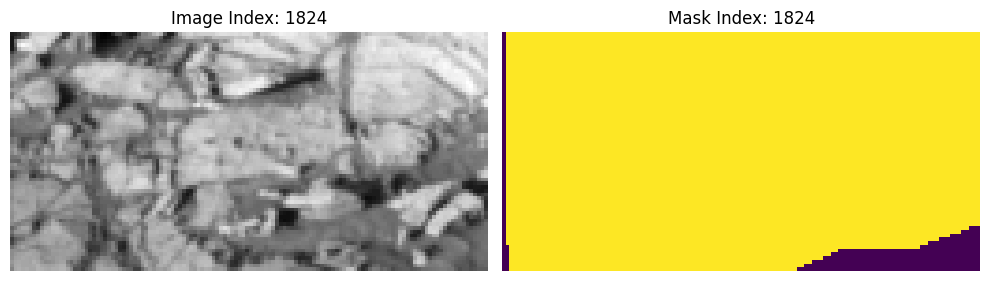

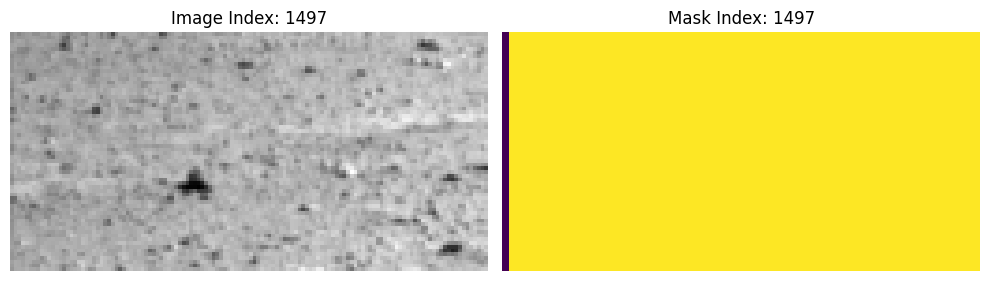

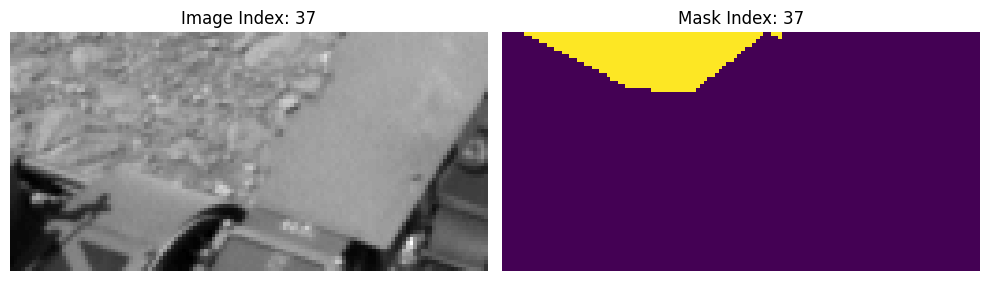

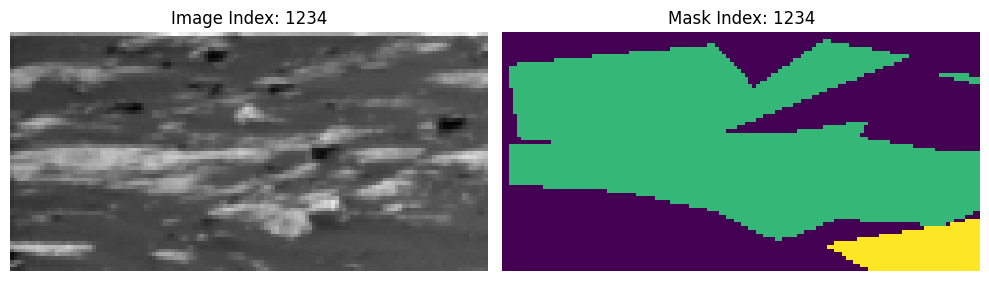

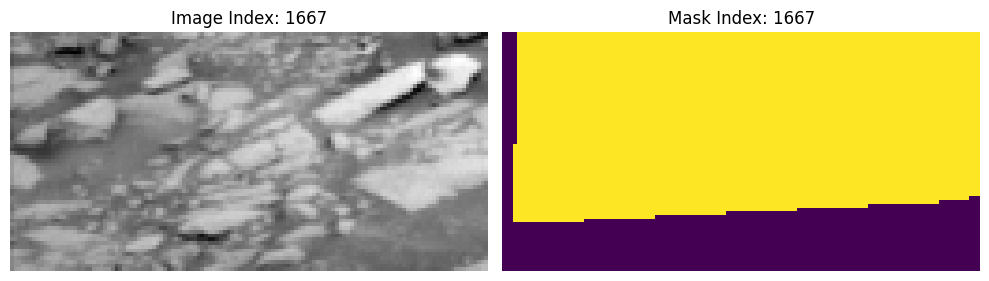

In [14]:
import random

# Visualize random image-mask pairs
for _ in range(5):
    idx = random.randint(0, len(X_train) - 1)
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    # Display input image
    ax[0].imshow(X_train[idx], cmap="gray")
    ax[0].set_title(f"Image Index: {idx}")
    ax[0].axis("off")

    # Display corresponding mask
    ax[1].imshow(y_train[idx], cmap="viridis")
    ax[1].set_title(f"Mask Index: {idx}")
    ax[1].axis("off")

    plt.tight_layout()
    plt.show()

## LETS DO SOME AUGMENTATION!!

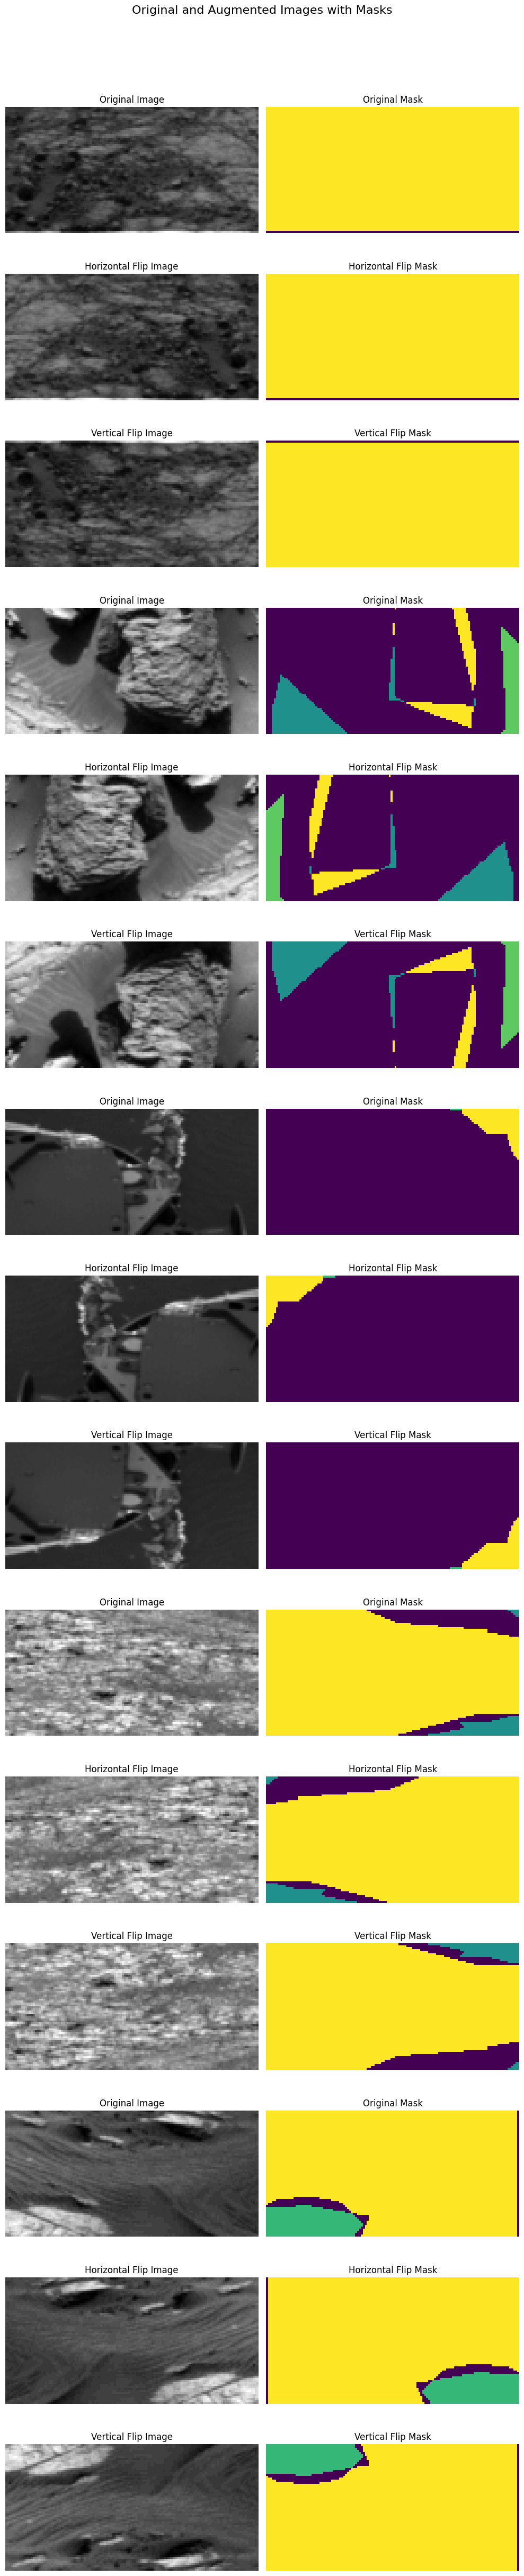

In [15]:
# Helper functions for applying augmentations
def augment_image_and_mask(image, mask, augment_type):
    if augment_type == "Horizontal Flip":
        return np.fliplr(image), np.fliplr(mask)
    elif augment_type == "Vertical Flip":
        return np.flipud(image), np.flipud(mask)
    """elif augment_type == "Rotation 20°":
        angle = random.uniform(-20, 20)
        return rotate(image, angle, reshape=False), rotate(mask, angle, reshape=False, order=0)
    elif augment_type == "Zoom (0.8-1.2)":
        zoom_factor = random.uniform(0.8, 1.2)
        zoom_image = np.clip(image * zoom_factor, 0, 255)
        return zoom_image, mask
    elif augment_type == "Shift (Width and Height)":
        shift_x, shift_y = random.uniform(-0.1, 0.1), random.uniform(-0.1, 0.1)
        return shift(image, [shift_x * image.shape[0], shift_y * image.shape[1]]), shift(mask, [shift_x * mask.shape[0], shift_y * mask.shape[1]], order=0)"""
    return image, mask

# Define augmentations
data_augmentations = {
    "Horizontal Flip": "Horizontal Flip",
    "Vertical Flip": "Vertical Flip",
    #"Rotation 20°": "Rotation 20°",
    #"Zoom (0.8-1.2)": "Zoom (0.8-1.2)",
    #"Shift (Width and Height)": "Shift (Width and Height)",
}

# Visualize 5 random images and masks with augmentations
random_indices = np.random.choice(len(X_train), size=5, replace=False)
# Adjusting to display original image/mask with augmentations below each
fig, axes = plt.subplots(len(random_indices) * (1 + len(data_augmentations)), 2, figsize=(10, 50))
fig.suptitle("Original and Augmented Images with Masks", fontsize=16)

for idx, random_idx in enumerate(random_indices):
    original_image = X_train[random_idx]
    original_mask = y_train[random_idx]

    # Plot original image and mask
    row = idx * (1 + len(data_augmentations))  # Calculate starting row for each original image
    axes[row, 0].imshow(original_image, cmap='gray')
    axes[row, 0].set_title("Original Image")
    axes[row, 0].axis('off')

    axes[row, 1].imshow(original_mask)
    axes[row, 1].set_title("Original Mask")
    axes[row, 1].axis('off')

    # Apply augmentations and plot augmented images and masks
    for aug_idx, (augmentation_name, augment_type) in enumerate(data_augmentations.items()):
        augmented_image, augmented_mask = augment_image_and_mask(original_image, original_mask, augment_type)

        axes[row + aug_idx + 1, 0].imshow(augmented_image , cmap='gray' )
        axes[row + aug_idx + 1, 0].set_title(f"{augmentation_name} Image")
        axes[row + aug_idx + 1, 0].axis('off')

        axes[row + aug_idx + 1, 1].imshow(augmented_mask)
        axes[row + aug_idx + 1, 1].set_title(f"{augmentation_name} Mask")
        axes[row + aug_idx + 1, 1].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [16]:
import os
import matplotlib.pyplot as plt

# Directory where augmented files are stored
output_dir = "augmented_data"
os.makedirs(output_dir, exist_ok=True)

# Re-save augmented datasets to the directory with structured filenames
for augmentation_name, augment_type in data_augmentations.items():
    augmented_images = []
    augmented_masks = []

    for image, mask in zip(X_train, y_train):
        aug_image, aug_mask = augment_image_and_mask(image, mask, augment_type)
        augmented_images.append(aug_image)
        augmented_masks.append(aug_mask)

    # Convert lists to numpy arrays
    augmented_images = np.array(augmented_images)
    augmented_masks = np.array(augmented_masks)

    # Save to npz file
    output_path = os.path.join(output_dir, f"{augmentation_name.replace(' ', '_').lower()}.npz")
    np.savez_compressed(output_path, augmented_images=augmented_images, augmented_masks=augmented_masks)


File: horizontal_flip.npz
  Key: augmented_images, Shape: (2004, 64, 128)
  Key: augmented_masks, Shape: (2004, 64, 128)


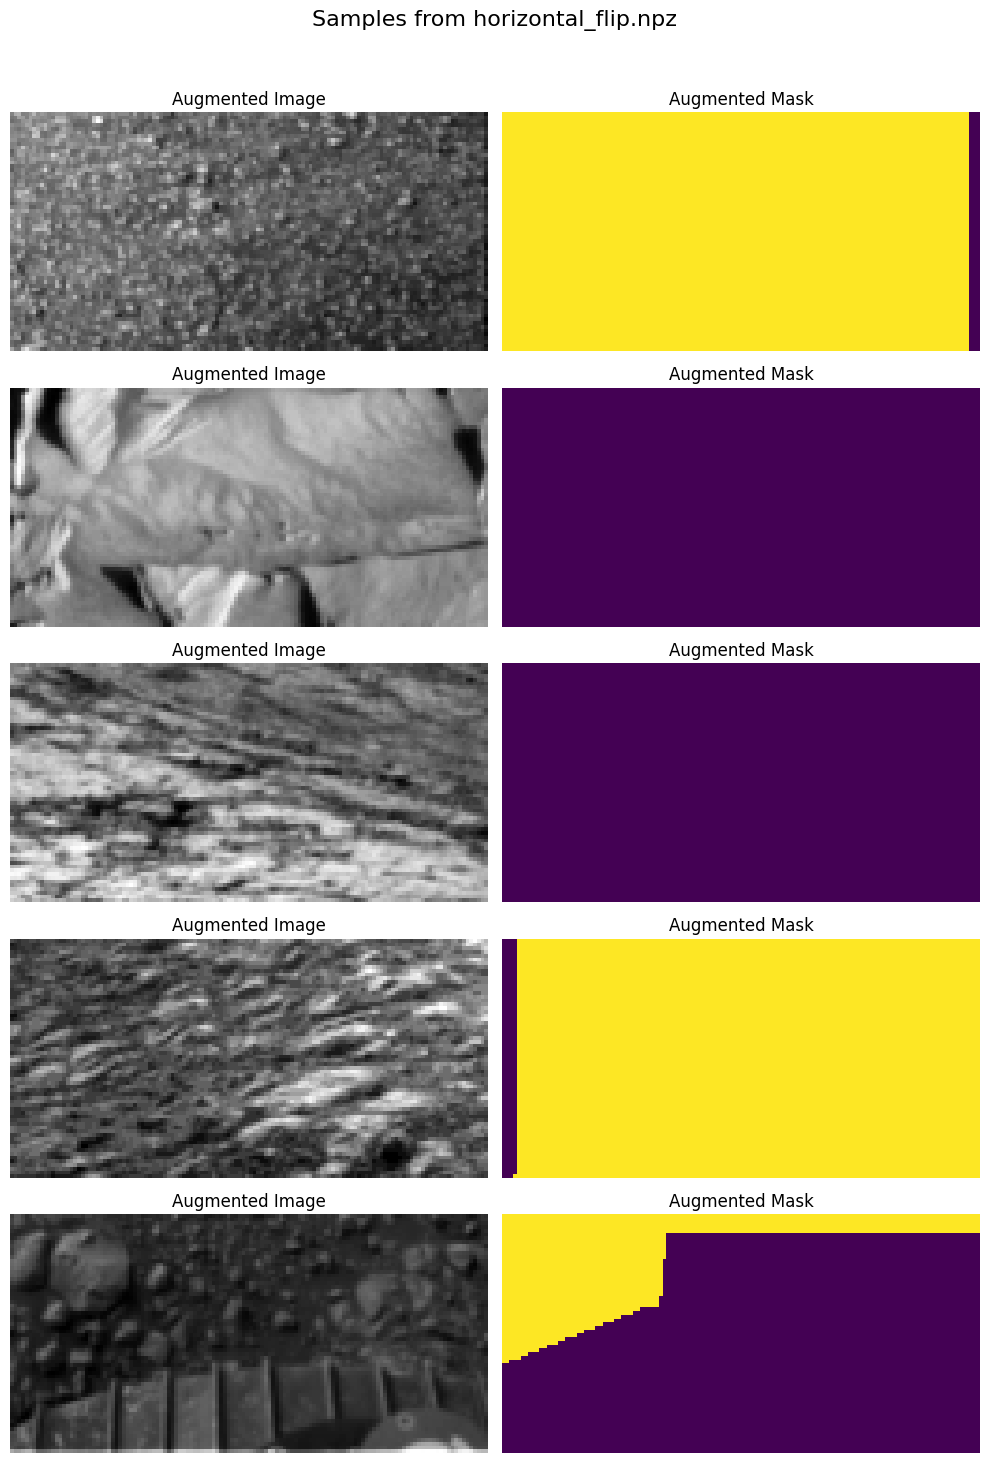

File: vertical_flip.npz
  Key: augmented_images, Shape: (2004, 64, 128)
  Key: augmented_masks, Shape: (2004, 64, 128)


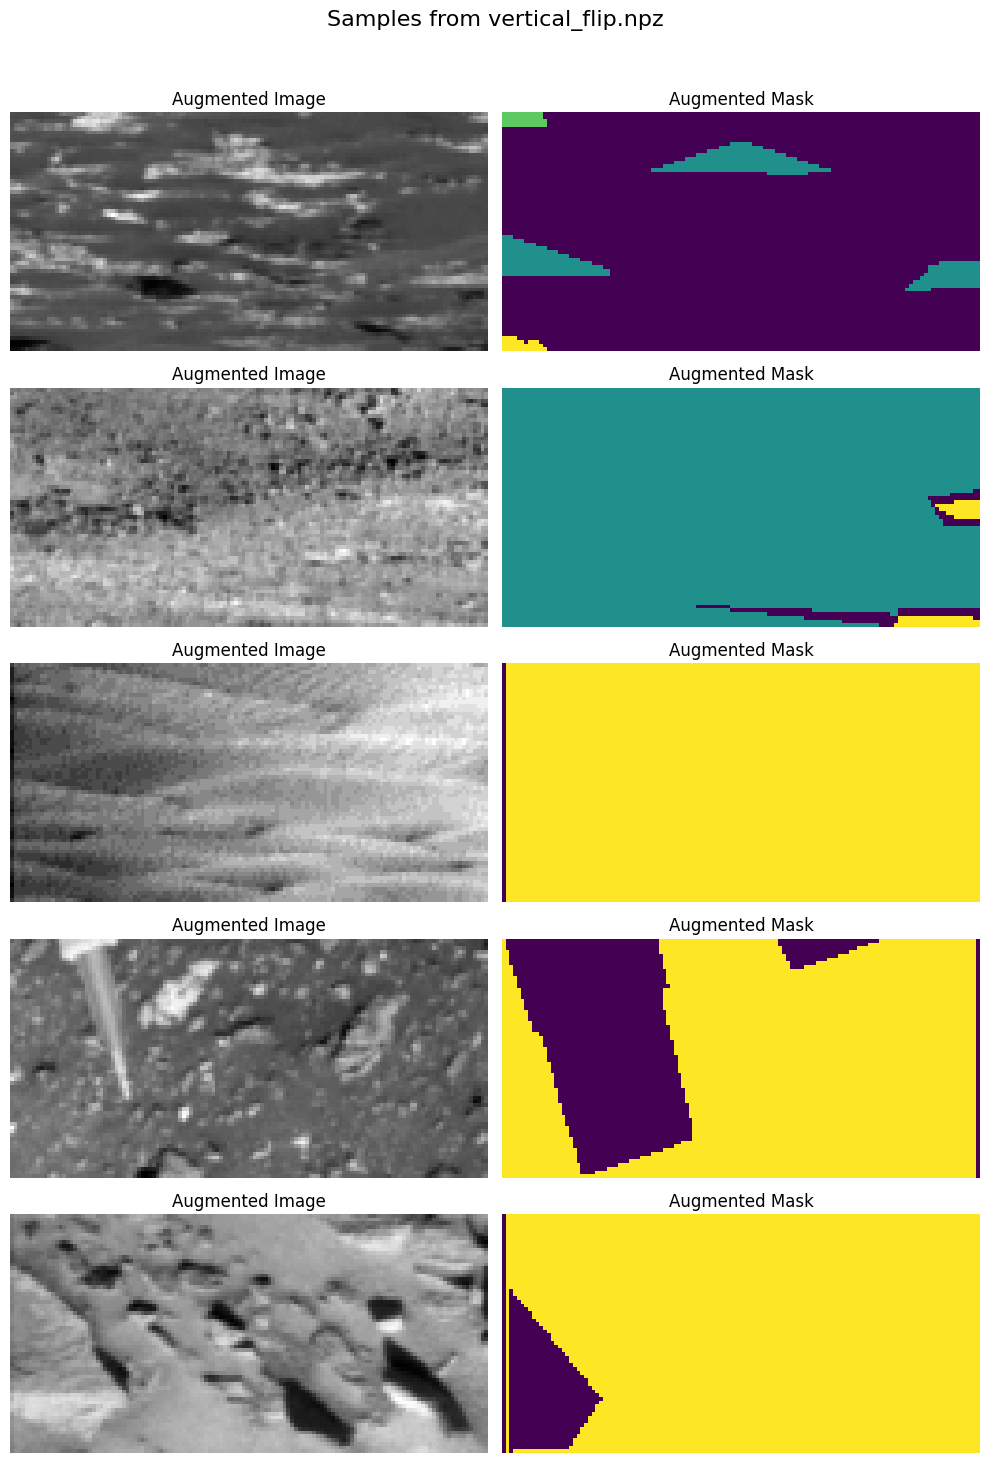

In [17]:
# Read the saved files and display details
for file_name in os.listdir(output_dir):
    if file_name.endswith(".npz"):
        file_path = os.path.join(output_dir, file_name)
        data = np.load(file_path)

        # Display keys and their shapes
        print(f"File: {file_name}")
        for key in data.keys():
            print(f"  Key: {key}, Shape: {data[key].shape}")

        # Plot 5 random images and masks
        fig, axes = plt.subplots(5, 2, figsize=(10, 15))
        fig.suptitle(f"Samples from {file_name}", fontsize=16)
        for i in range(5):
            random_idx = np.random.randint(data["augmented_images"].shape[0])
            axes[i, 0].imshow(data["augmented_images"][random_idx], cmap="gray")
            axes[i, 0].set_title("Augmented Image")
            axes[i, 0].axis("off")
            axes[i, 1].imshow(data["augmented_masks"][random_idx])
            axes[i, 1].set_title("Augmented Mask")
            axes[i, 1].axis("off")
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

## 🛠️ Train and Save the Model

In [18]:
# Load the rotation augmentation dataset
rotation_file_path = os.path.join("/kaggle/working/augmented_data/horizontal_flip.npz")
rotation_data = np.load(rotation_file_path)

# Extract augmented images and masks
augmented_images = rotation_data["augmented_images"]
augmented_masks = rotation_data["augmented_masks"]

# Merge with original X_train and y_train
X_train = np.concatenate([X_train, augmented_images], axis=0)
y_train = np.concatenate([y_train, augmented_masks], axis=0)

# Display the new shapes
print(f"New X_train shape: {X_train.shape}")
print(f"New y_train shape: {y_train.shape}")

New X_train shape: (4008, 64, 128)
New y_train shape: (4008, 64, 128)


In [19]:
# Load the rotation augmentation dataset
rotation_file_path = os.path.join("/kaggle/working/augmented_data/vertical_flip.npz")
rotation_data = np.load(rotation_file_path)

# Extract augmented images and masks
augmented_images = rotation_data["augmented_images"]
augmented_masks = rotation_data["augmented_masks"]

# Merge with original X_train and y_train
X_train = np.concatenate([X_train, augmented_images], axis=0)
y_train = np.concatenate([y_train, augmented_masks], axis=0)

# Display the new shapes
print(f"New X_train shape: {X_train.shape}")
print(f"New y_train shape: {y_train.shape}")

New X_train shape: (6012, 64, 128)
New y_train shape: (6012, 64, 128)


In [20]:
# Add color channel and rescale pixels between 0 and 1
X_train = X_train[..., np.newaxis] / 255.0
X_test = X_test[..., np.newaxis] / 255.0

input_shape = X_train.shape[1:]
num_classes = len(np.unique(y_train))

print(f"Input shape: {input_shape}")
print(f"Number of classes: {num_classes}")

Input shape: (64, 128, 1)
Number of classes: 5


In [21]:
X_val = X_val[..., np.newaxis] / 255.0

In [22]:
print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_train shape: {y_train.shape}")

X_train shape: (6012, 64, 128, 1)
X_val shape: (501, 64, 128, 1)
y_train shape: (6012, 64, 128)


In [23]:
# Custom callback for visualization
class VisualizeSegmentationCallback(tf.keras.callbacks.Callback):
    def __init__(self, X_train, y_train, num_images=2):
        super().__init__()
        self.X_train = X_train
        self.y_train = y_train
        self.num_images = num_images
        self.selected_indices = []

        # Identify images containing at least 4 classes
        for i in range(len(y_train)):
            if len(np.unique(y_train[i])) >= 4:  # Check for at least 4 classes
                self.selected_indices.append(i)
            if len(self.selected_indices) == num_images:
                break

    def on_epoch_end(self, epoch, logs=None):
        # Plot predictions for the selected images
        fig, axes = plt.subplots(self.num_images, 3, figsize=(15, self.num_images * 5))

        for idx, i in enumerate(self.selected_indices):
            # Extract image and ground truth
            X_sample = self.X_train[i:i + 1]  # Add batch dimension
            y_sample = self.y_train[i]

            # Predict on the image
            predicted_mask = self.model.predict(X_sample)
            predicted_mask = np.argmax(predicted_mask, axis=-1)[0]  # Convert to class labels

            # Visualize the input, ground truth, and predicted mask
            axes[idx, 0].imshow(X_sample[0].squeeze(), cmap="gray")
            axes[idx, 0].set_title("Input Image")
            axes[idx, 0].axis("off")

            axes[idx, 1].imshow(y_sample, cmap="viridis")
            axes[idx, 1].set_title("Ground Truth Mask")
            axes[idx, 1].axis("off")

            axes[idx, 2].imshow(predicted_mask, cmap="viridis")
            axes[idx, 2].set_title(f"Predicted Mask (Epoch {epoch + 1})")
            axes[idx, 2].axis("off")

        plt.tight_layout()
        plt.show()

## Adding advanced tecnics

In [24]:
# Ensure the input shape for both images and masks is correct
X_train = np.squeeze(X_train)  # Remove any singleton dimensions
y_train = np.squeeze(y_train)  # Remove any singleton dimensions

# Check if the channel dimension exists, otherwise add it
if X_train.ndim == 3:  # If missing the channel dimension, add it
    X_train = X_train[..., np.newaxis]

if y_train.ndim == 3:  # Ensure y_train has the correct shape
    y_train = y_train[..., np.newaxis]

print(f"Shape of X_train after reshaping: {X_train.shape}")
print(f"Shape of y_train after reshaping: {y_train.shape}")

Shape of X_train after reshaping: (6012, 64, 128, 1)
Shape of y_train after reshaping: (6012, 64, 128, 1)


In [25]:
# Ensure the input shape for both images and masks is correct
X_val = np.squeeze(X_val)  # Remove any singleton dimensions
y_val= np.squeeze(y_val)  # Remove any singleton dimensions

# Check if the channel dimension exists, otherwise add it
if X_val.ndim == 3:  # If missing the channel dimension, add it
    X_val = X_val[..., np.newaxis]

if y_val.ndim == 3:  # Ensure y_train has the correct shape
    y_val = y_val[..., np.newaxis]

print(f"Shape of X_train after reshaping: {X_val.shape}")
print(f"Shape of y_train after reshaping: {y_val.shape}")

Shape of X_train after reshaping: (501, 64, 128, 1)
Shape of y_train after reshaping: (501, 64, 128, 1)


In [49]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Ensure the input shape for both images and masks is correct
X_train = np.squeeze(X_train)  # Remove singleton dimensions
if X_train.ndim == 3:  # If missing the channel dimension, add it
    X_train = X_train[..., np.newaxis]

y_train = np.squeeze(y_train)  # Ensure that y_train has the correct shape

print(f"Shape of X_train after reshaping: {X_train.shape}")
print(f"Shape of y_train after reshaping: {y_train.shape}")

# Data Augmentation for Images and Masks
image_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],  # Adjust brightness
)

# Masks should only be flipped or translated without interpolation
mask_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

# Ensure y_train has the correct shape for augmentation
y_train = np.expand_dims(y_train, axis=-1)  # Add channel dimension to masks

# Fit augmentations to the data
image_datagen.fit(X_train)
mask_datagen.fit(y_train)

# Create the generators
image_generator = image_datagen.flow(X_train, batch_size=32, seed=42)
mask_generator = mask_datagen.flow(y_train, batch_size=32, seed=42)

train_generator = zip(image_generator, mask_generator)

# Weighted Loss Function for Class Imbalance
def weighted_categorical_crossentropy(weights):
    weights = tf.constant(weights, dtype=tf.float32)

    def loss(y_true, y_pred):
        # Remove the extra dimension from y_true using tf.squeeze
        y_true = tf.squeeze(y_true, axis=-1)

        y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=len(weights))
        y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())
        return -tf.reduce_sum(y_true * tf.math.log(y_pred) * weights, axis=-1)

    return loss

# Convert y_train to integers for class count
y_train_int = y_train.astype(np.int32)

# Calculate class weights based on pixel proportions
class_pixel_counts = np.bincount(y_train_int.flatten(), minlength=num_classes)  # Count pixels for each class
total_pixels = np.sum(class_pixel_counts)  # Total number of pixels
class_weights = total_pixels / (class_pixel_counts + 1e-6)  # Inverse frequency
class_weights /= np.sum(class_weights)  # Normalize to sum to 1

print(f"Class pixel counts: {class_pixel_counts}")
print(f"Calculated class weights: {class_weights}")

# Use the calculated weights in the loss function
loss = weighted_categorical_crossentropy(class_weights)

# Define the U-Net Model
def unet_model(input_shape, num_classes):
    inputs = tf.keras.layers.Input(input_shape)

    # Encoder
    c1 = tf.keras.layers.Conv2D(64, (3, 3), activation="relu", padding="same")(inputs)
    c1 = tf.keras.layers.Conv2D(64, (3, 3), activation="relu", padding="same")(c1)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

    c2 = tf.keras.layers.Conv2D(128, (3, 3), activation="relu", padding="same")(p1)
    c2 = tf.keras.layers.Conv2D(128, (3, 3), activation="relu", padding="same")(c2)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

    # Decoder
    u1 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding="same")(c2)
    u1 = tf.keras.layers.concatenate([u1, c1])
    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation="relu", padding="same")(u1)
    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation="relu", padding="same")(c3)

    outputs = tf.keras.layers.Conv2D(num_classes, (1, 1), activation="softmax")(c3)
    return tf.keras.Model(inputs, outputs)

# Initialize the model
input_shape = X_train.shape[1:]
model = unet_model(input_shape, num_classes)
model.compile(optimizer="adam", loss=loss, metrics=["accuracy"])
model.summary()

# Updated EarlyStopping with min_delta to ignore minimal improvements
early_stopping = EarlyStopping(
    monitor="val_loss",  # Monitor loss instead of validation loss
    patience=15,
    restore_best_weights=True,
    min_delta=1e-4  # Minimum change to qualify as an improvement
)


model_checkpoint = ModelCheckpoint(
    filepath="best_model.keras",
    monitor="val_loss",  # Monitor loss instead of validation loss
    save_best_only=True,
    mode="min",
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",  # Monitor loss instead of validation loss
    factor=0.5,
    patience=5,
    verbose=1,
    mode="min",
    min_lr=1e-6
)

# Visualization Callback for Two Images with At Least 4 Classes
visualize_callback = VisualizeSegmentationCallback(X_val, y_val, num_images=2)

# Custom Data Generator
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, image_datagen, mask_datagen, X_train, y_train, batch_size):
        self.image_datagen = image_datagen
        self.mask_datagen = mask_datagen
        self.X_train = X_train
        self.y_train = y_train
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.X_train) / float(self.batch_size)))

    def __getitem__(self, idx):
      # Get the batch indices
      batch_x = self.X_train[idx * self.batch_size:(idx + 1) * self.batch_size]
      batch_y = self.y_train[idx * self.batch_size:(idx + 1) * self.batch_size]

      # Apply augmentation
      # Use __next__() instead of next() for NumpyArrayIterator
      image_batch = self.image_datagen.flow(batch_x, batch_size=self.batch_size, shuffle=False).__next__()
      mask_batch = self.mask_datagen.flow(batch_y, batch_size=self.batch_size, shuffle=False).__next__()

      return image_batch, mask_batch  # Return image and mask batches


Shape of X_train after reshaping: (6012, 64, 128, 1)
Shape of y_train after reshaping: (6012, 64, 128)
Class pixel counts: [11939679 16596486 11773779  8876373    63987]
Calculated class weights: [0.00524455 0.00377298 0.00531845 0.00705449 0.97860952]


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 64, 128,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_29 (Conv2D)  │ (None, 64, 128,   │        640 │ input_layer_2[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_30 (Conv2D)  │ (None, 64, 128,   │     36,928 │ conv2d_29[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 32, 64,    │          0 │ conv2d_30[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_31 (Conv2D)  │ (None, 32, 64,    │     73,856 │ max_pooling2d_5[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_32 (Conv2D)  │ (None, 32, 64,    │    147,584 │ conv2d_31[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_4  │ (None, 64, 128,   │     32,832 │ conv2d_32[0][0]   │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 64, 128,   │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 128)              │            │ conv2d_30[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_33 (Conv2D)  │ (None, 64, 128,   │     73,792 │ concatenate_4[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_34 (Conv2D)  │ (None, 64, 128,   │     36,928 │ conv2d_33[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_35 (Conv2D)  │ (None, 64, 128,   │        325 │ conv2d_34[0][0]   │
│                     │ 5)                │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 402,885 (1.54 MB)

 Trainable params: 402,885 (1.54 MB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 64, 128,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 64, 128,   │        640 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 64, 128,   │     36,928 │ conv2d_7[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 64, 128,   │        128 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 64, 128,   │          0 │ conv2d_8[0][0],   │
│                     │ 64)               │            │ conv2d_9[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 64,    │          0 │ add[0][0]         │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 32, 64,    │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 32, 64,    │    147,584 │ conv2d_10[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 32, 64,    │      8,320 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 32, 64,    │          0 │ conv2d_11[0][0],  │
│                     │ 128)              │            │ conv2d_12[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 32,    │          0 │ add_1[0][0]       │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 16, 32,    │    295,168 │ max_pooling2d_3[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 16, 32,    │    590,080 │ conv2d_13[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 16, 32,    │     33,024 │ max_pooling2d_3[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 16, 32,    │          0 │ conv2d_14[0][0],  │
│                     │ 256)              │            │ conv2d_15[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 8, 16,     │          0 │ add_2[0][0]       │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 8, 16,     │  1,180,160 │ max_pooling2d_4[

 Total params: 8,041,989 (30.68 MB)

 Trainable params: 8,041,989 (30.68 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/1000


I0000 00:00:1733167427.644657     114 service.cc:145] XLA service 0x58576d8081c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733167427.644712     114 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1733167427.644718     114 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
W0000 00:00:1733167428.195353     114 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
I0000 00:00:1733167460.458722     114 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


187/188 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.3250 - loss: 1.4109 - mean_io_u: 0.1002

W0000 00:00:1733167493.926924     113 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step - accuracy: 0.3251 - loss: 1.4105 - mean_io_u: 0.1002

W0000 00:00:1733167528.493881     113 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1733167530.072020     111 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert



Epoch 1: val_loss improved from inf to 1.21220, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


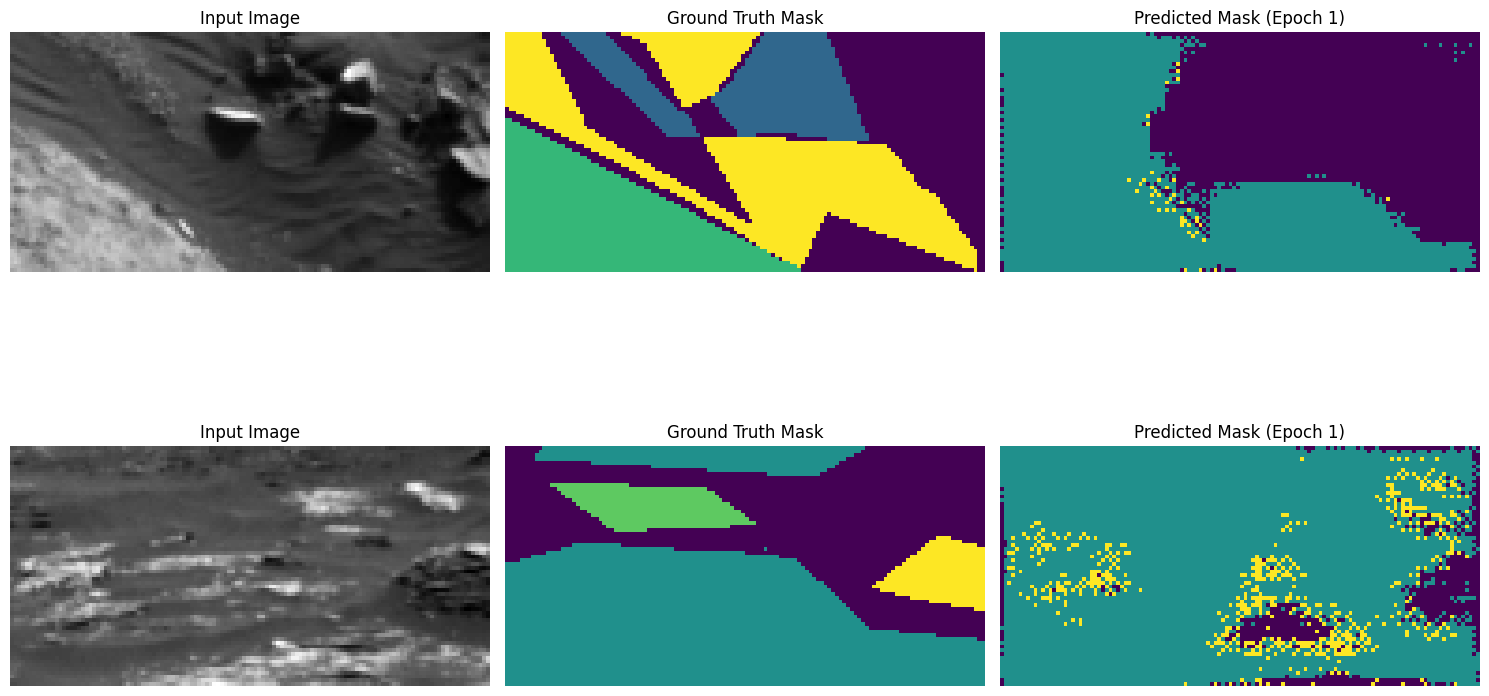

188/188 ━━━━━━━━━━━━━━━━━━━━ 120s 435ms/step - accuracy: 0.3253 - loss: 1.4102 - mean_io_u: 0.1003 - val_accuracy: 0.4601 - val_loss: 1.2122 - val_mean_io_u: 0.1737 - learning_rate: 1.0000e-04
Epoch 2/1000
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.4573 - loss: 1.1770 - mean_io_u: 0.2191
Epoch 2: val_loss improved from 1.21220 to 1.09879, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


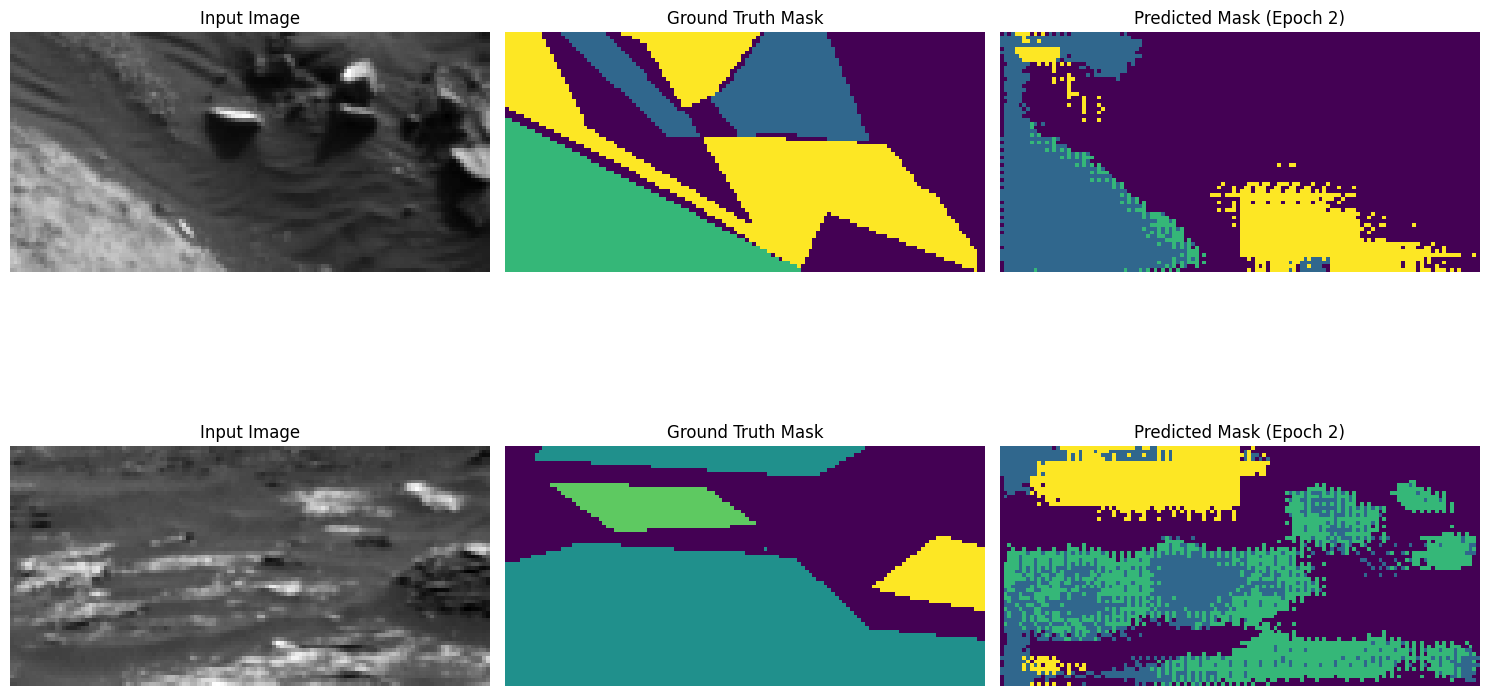

188/188 ━━━━━━━━━━━━━━━━━━━━ 38s 200ms/step - accuracy: 0.4573 - loss: 1.1769 - mean_io_u: 0.2191 - val_accuracy: 0.5271 - val_loss: 1.0988 - val_mean_io_u: 0.2234 - learning_rate: 1.0000e-04
Epoch 3/1000
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.5155 - loss: 1.0885 - mean_io_u: 0.2416
Epoch 3: val_loss improved from 1.09879 to 1.05142, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


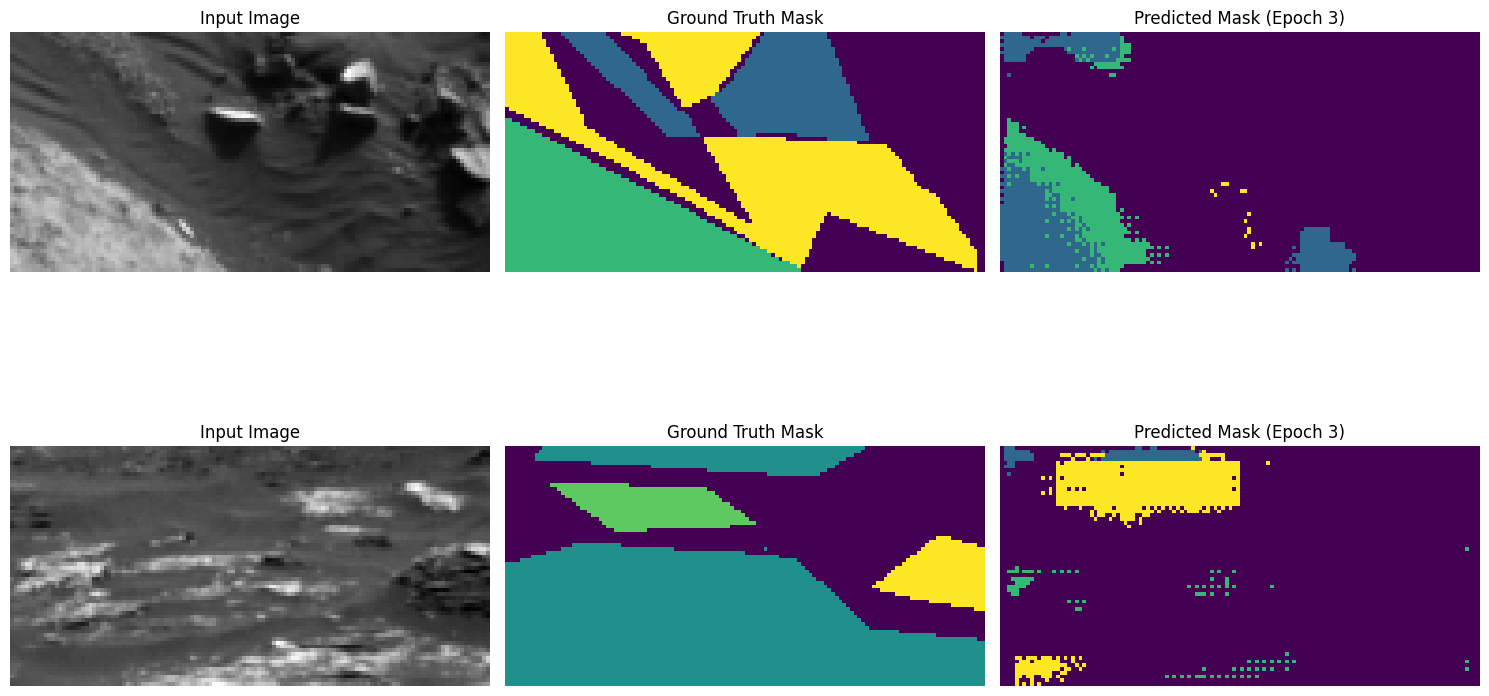

188/188 ━━━━━━━━━━━━━━━━━━━━ 37s 199ms/step - accuracy: 0.5156 - loss: 1.0883 - mean_io_u: 0.2416 - val_accuracy: 0.5646 - val_loss: 1.0514 - val_mean_io_u: 0.2541 - learning_rate: 1.0000e-04
Epoch 4/1000
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.5598 - loss: 1.0179 - mean_io_u: 0.2741
Epoch 4: val_loss improved from 1.05142 to 1.01476, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


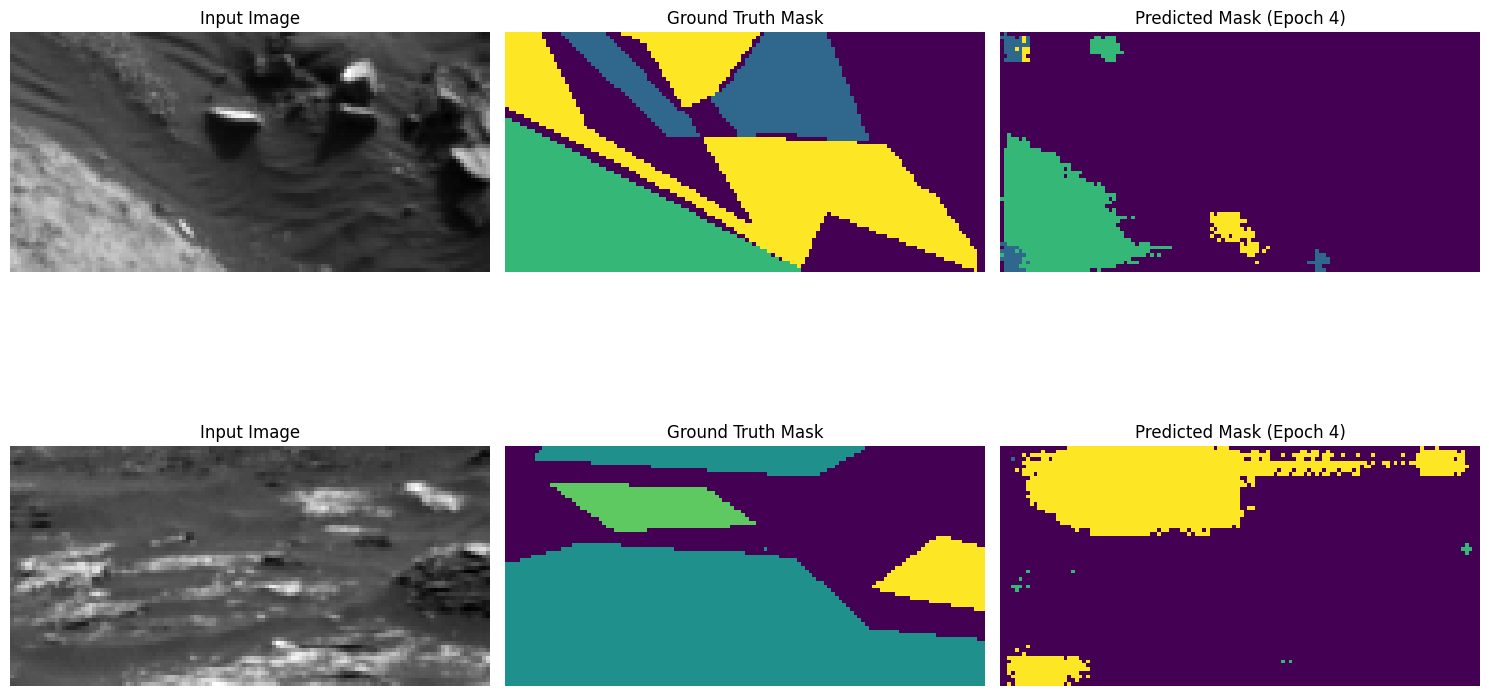

188/188 ━━━━━━━━━━━━━━━━━━━━ 38s 201ms/step - accuracy: 0.5599 - loss: 1.0178 - mean_io_u: 0.2741 - val_accuracy: 0.5766 - val_loss: 1.0148 - val_mean_io_u: 0.2894 - learning_rate: 1.0000e-04
Epoch 5/1000
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.6053 - loss: 0.9547 - mean_io_u: 0.3200
Epoch 5: val_loss improved from 1.01476 to 1.00224, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


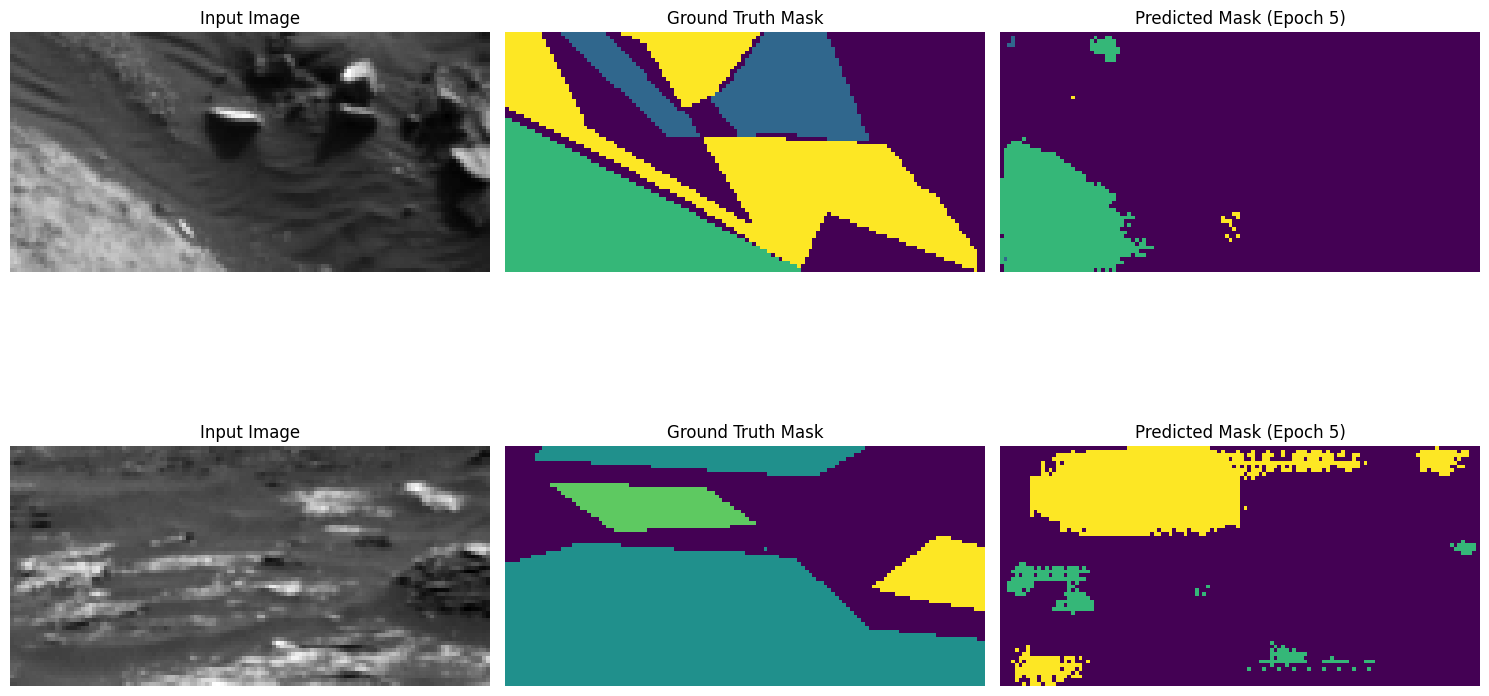

188/188 ━━━━━━━━━━━━━━━━━━━━ 38s 200ms/step - accuracy: 0.6053 - loss: 0.9547 - mean_io_u: 0.3200 - val_accuracy: 0.5839 - val_loss: 1.0022 - val_mean_io_u: 0.2966 - learning_rate: 1.0000e-04
Epoch 6/1000
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.6349 - loss: 0.9028 - mean_io_u: 0.3461
Epoch 6: val_loss did not improve from 1.00224
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


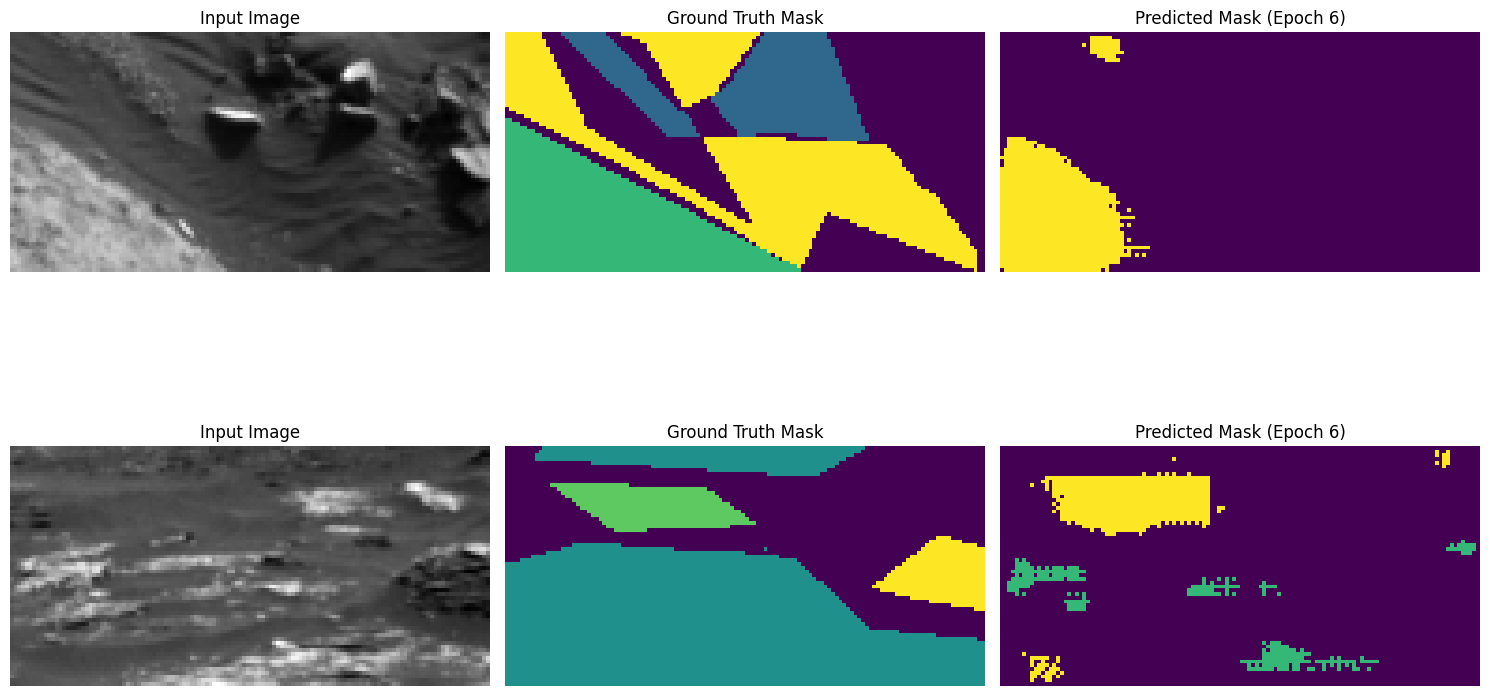

188/188 ━━━━━━━━━━━━━━━━━━━━ 37s 197ms/step - accuracy: 0.6349 - loss: 0.9029 - mean_io_u: 0.3460 - val_accuracy: 0.5640 - val_loss: 1.0207 - val_mean_io_u: 0.2788 - learning_rate: 1.0000e-04
Epoch 7/1000
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.6508 - loss: 0.8720 - mean_io_u: 0.3602
Epoch 7: val_loss did not improve from 1.00224
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


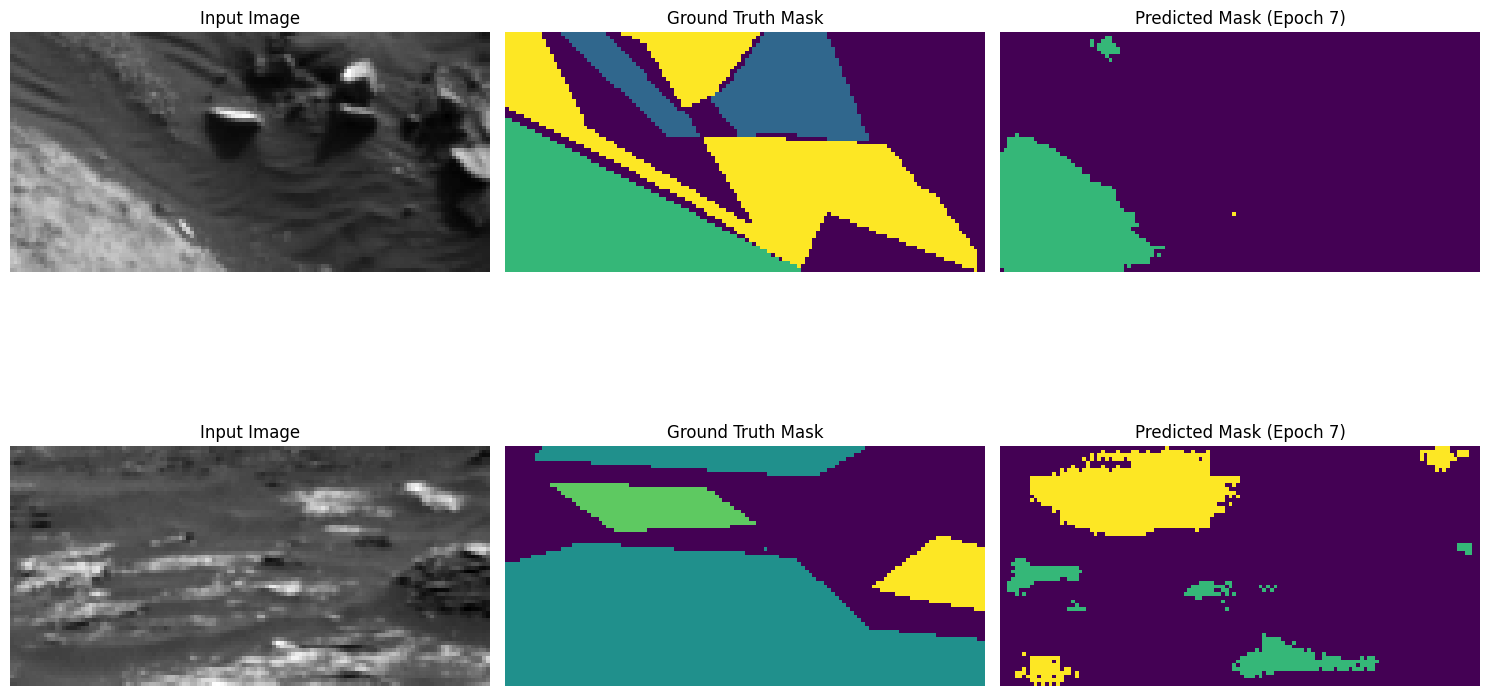

188/188 ━━━━━━━━━━━━━━━━━━━━ 37s 197ms/step - accuracy: 0.6508 - loss: 0.8720 - mean_io_u: 0.3602 - val_accuracy: 0.5672 - val_loss: 1.0316 - val_mean_io_u: 0.2831 - learning_rate: 1.0000e-04
Epoch 8/1000
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.6705 - loss: 0.8360 - mean_io_u: 0.3770
Epoch 8: val_loss improved from 1.00224 to 0.95559, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


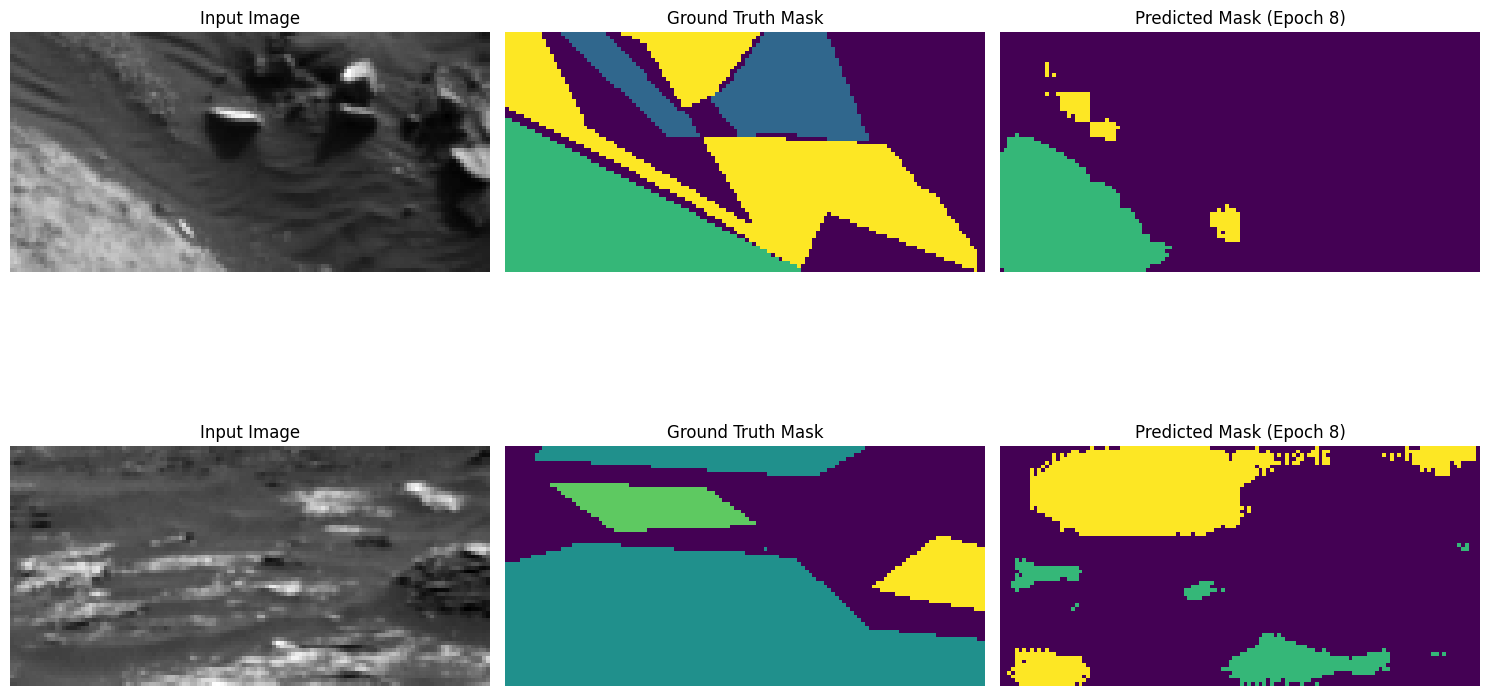

188/188 ━━━━━━━━━━━━━━━━━━━━ 38s 200ms/step - accuracy: 0.6705 - loss: 0.8360 - mean_io_u: 0.3770 - val_accuracy: 0.6220 - val_loss: 0.9556 - val_mean_io_u: 0.3292 - learning_rate: 1.0000e-04
Epoch 9/1000
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.6863 - loss: 0.8018 - mean_io_u: 0.3902
Epoch 9: val_loss improved from 0.95559 to 0.87781, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


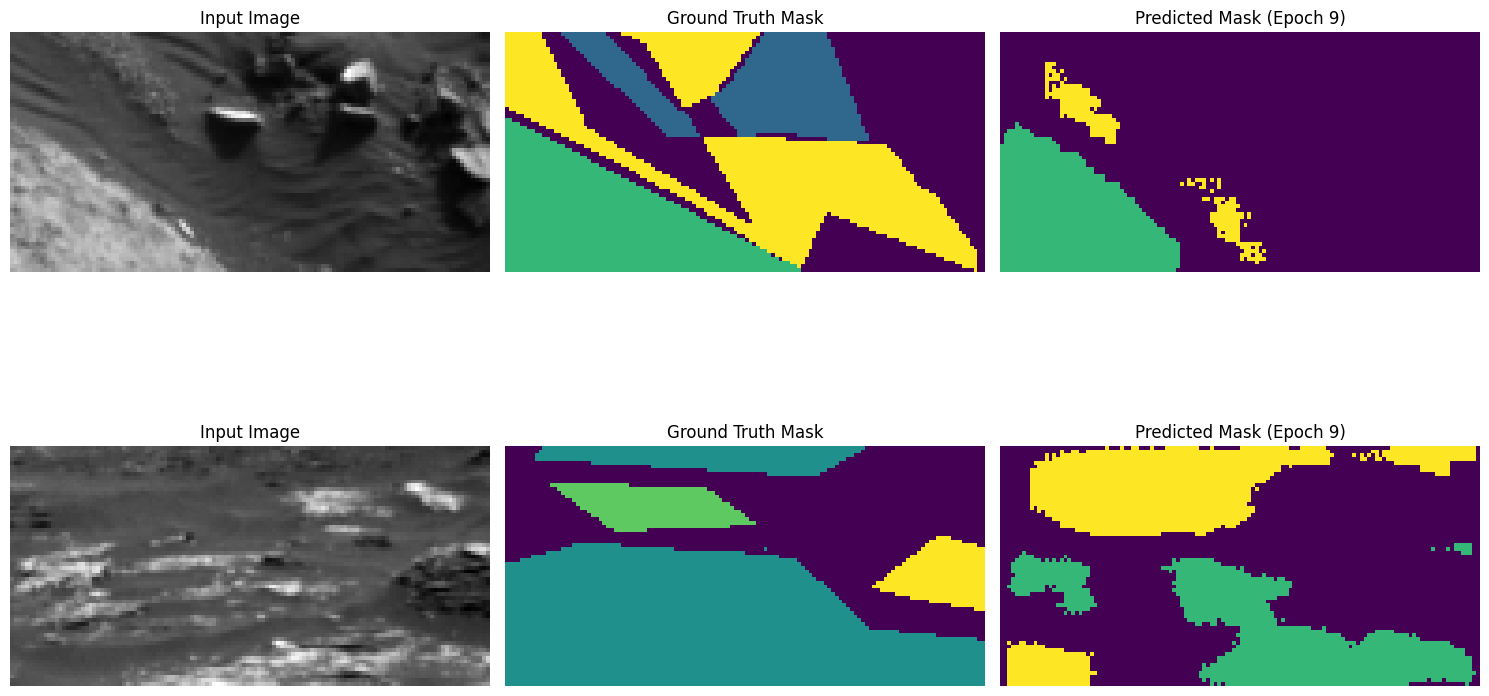

188/188 ━━━━━━━━━━━━━━━━━━━━ 38s 202ms/step - accuracy: 0.6863 - loss: 0.8018 - mean_io_u: 0.3902 - val_accuracy: 0.6615 - val_loss: 0.8778 - val_mean_io_u: 0.3652 - learning_rate: 1.0000e-04
Epoch 10/1000
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.6994 - loss: 0.7730 - mean_io_u: 0.4021
Epoch 10: val_loss improved from 0.87781 to 0.85401, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


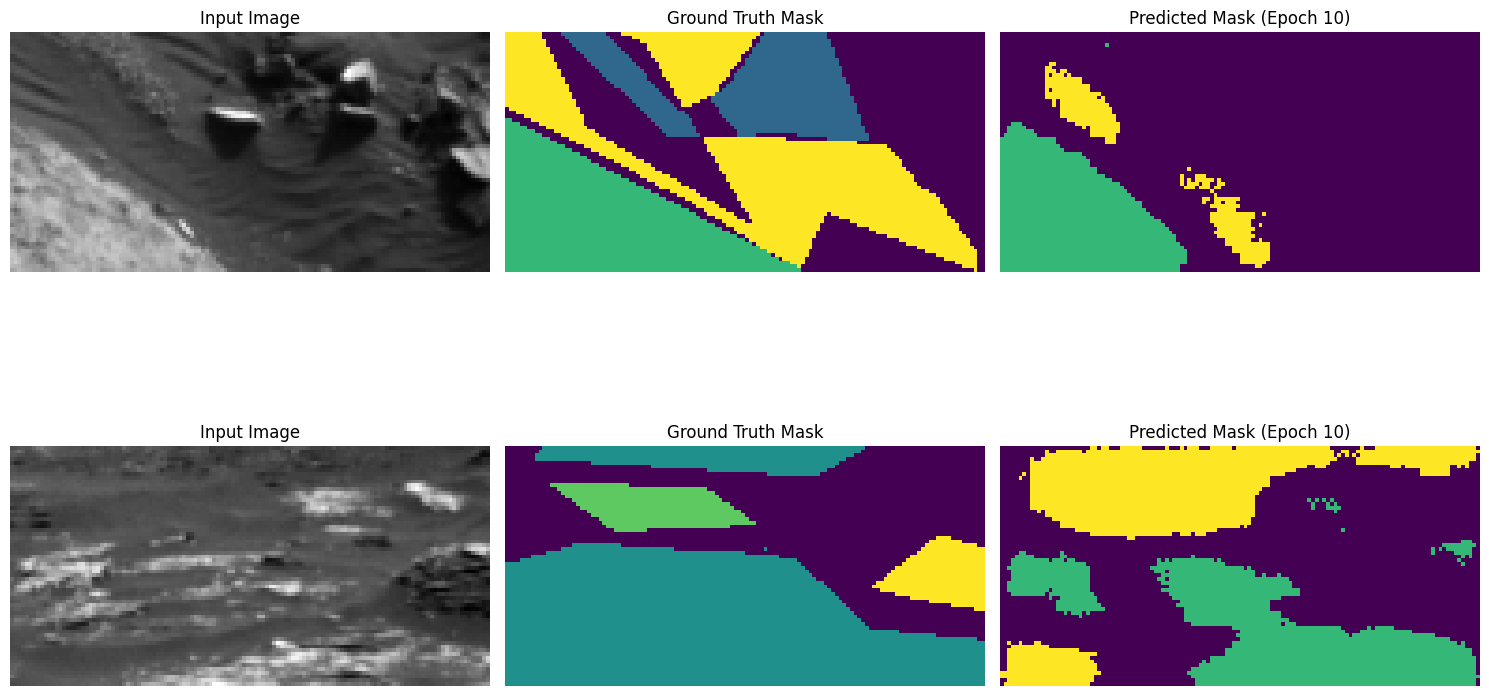

188/188 ━━━━━━━━━━━━━━━━━━━━ 38s 201ms/step - accuracy: 0.6994 - loss: 0.7730 - mean_io_u: 0.4020 - val_accuracy: 0.6736 - val_loss: 0.8540 - val_mean_io_u: 0.3778 - learning_rate: 1.0000e-04
Epoch 11/1000
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.7074 - loss: 0.7527 - mean_io_u: 0.4094
Epoch 11: val_loss improved from 0.85401 to 0.85279, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


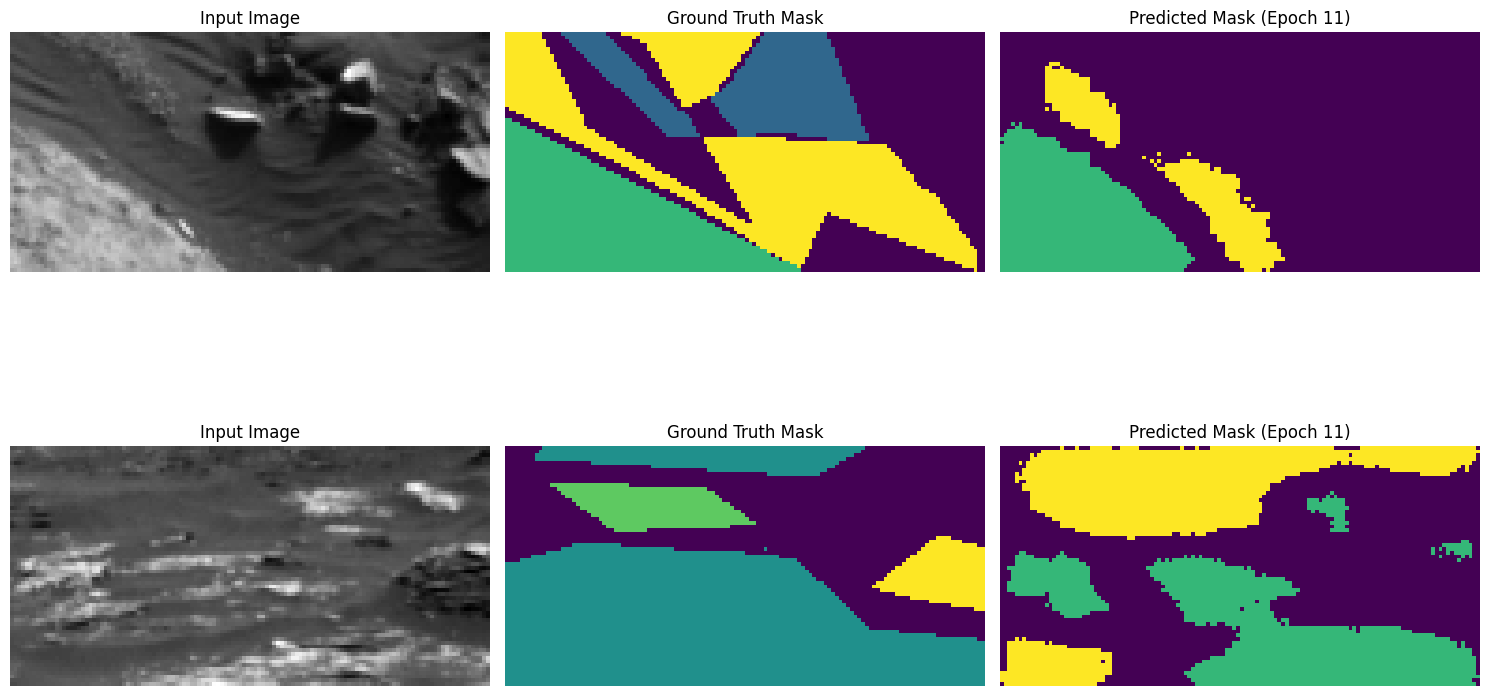

188/188 ━━━━━━━━━━━━━━━━━━━━ 38s 201ms/step - accuracy: 0.7074 - loss: 0.7527 - mean_io_u: 0.4093 - val_accuracy: 0.6764 - val_loss: 0.8528 - val_mean_io_u: 0.3802 - learning_rate: 1.0000e-04
Epoch 12/1000
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.7150 - loss: 0.7338 - mean_io_u: 0.4163
Epoch 12: val_loss improved from 0.85279 to 0.80685, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


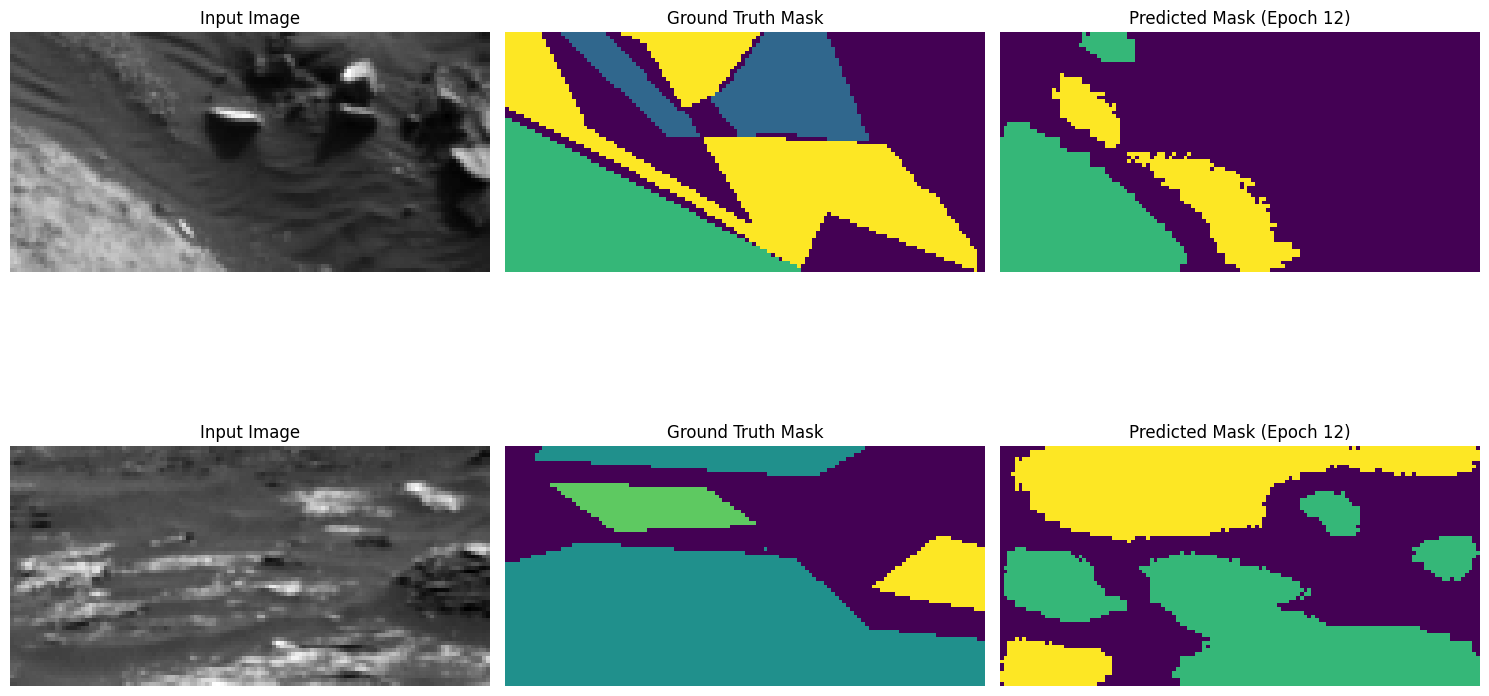

188/188 ━━━━━━━━━━━━━━━━━━━━ 38s 200ms/step - accuracy: 0.7150 - loss: 0.7339 - mean_io_u: 0.4162 - val_accuracy: 0.6986 - val_loss: 0.8069 - val_mean_io_u: 0.4044 - learning_rate: 1.0000e-04
Epoch 13/1000
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.7219 - loss: 0.7173 - mean_io_u: 0.4229
Epoch 13: val_loss improved from 0.80685 to 0.76614, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


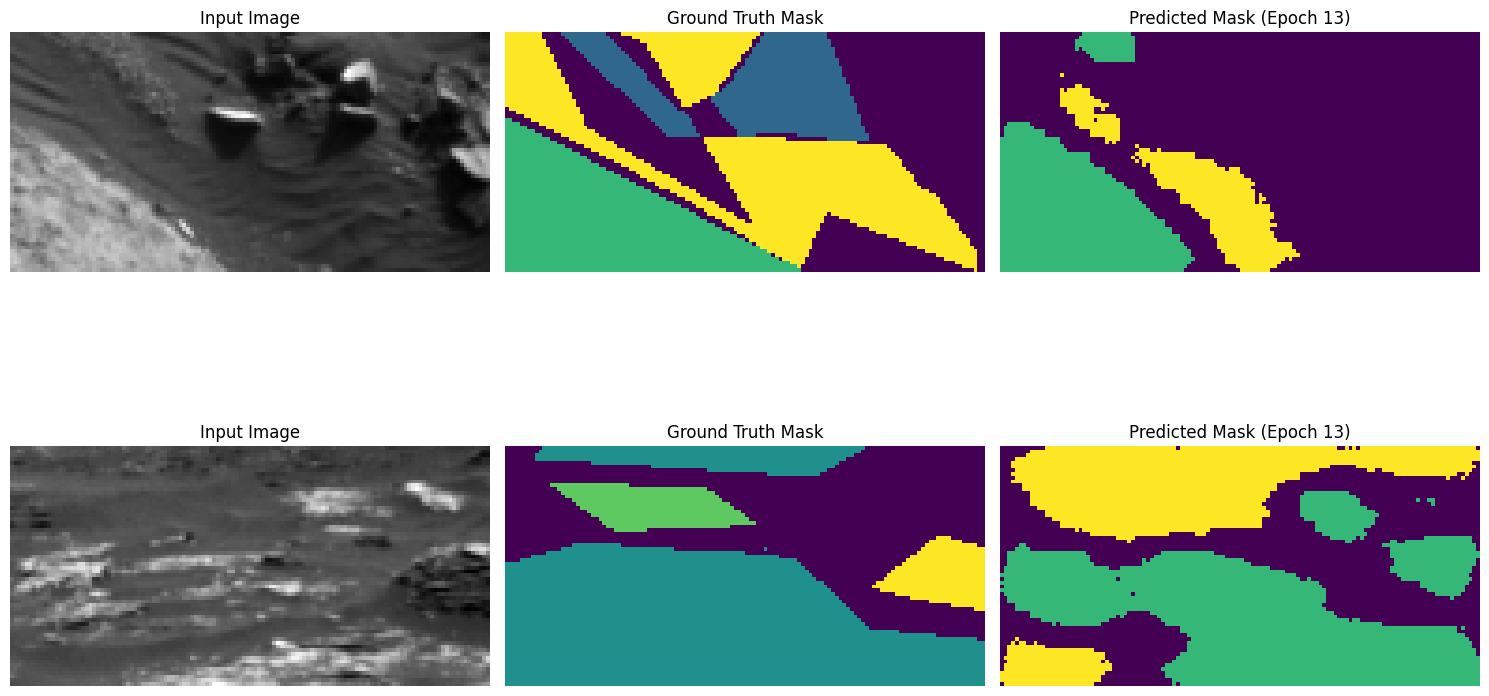

188/188 ━━━━━━━━━━━━━━━━━━━━ 38s 201ms/step - accuracy: 0.7219 - loss: 0.7174 - mean_io_u: 0.4228 - val_accuracy: 0.7141 - val_loss: 0.7661 - val_mean_io_u: 0.4223 - learning_rate: 1.0000e-04
Epoch 14/1000
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.7272 - loss: 0.7042 - mean_io_u: 0.4280
Epoch 14: val_loss improved from 0.76614 to 0.74704, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


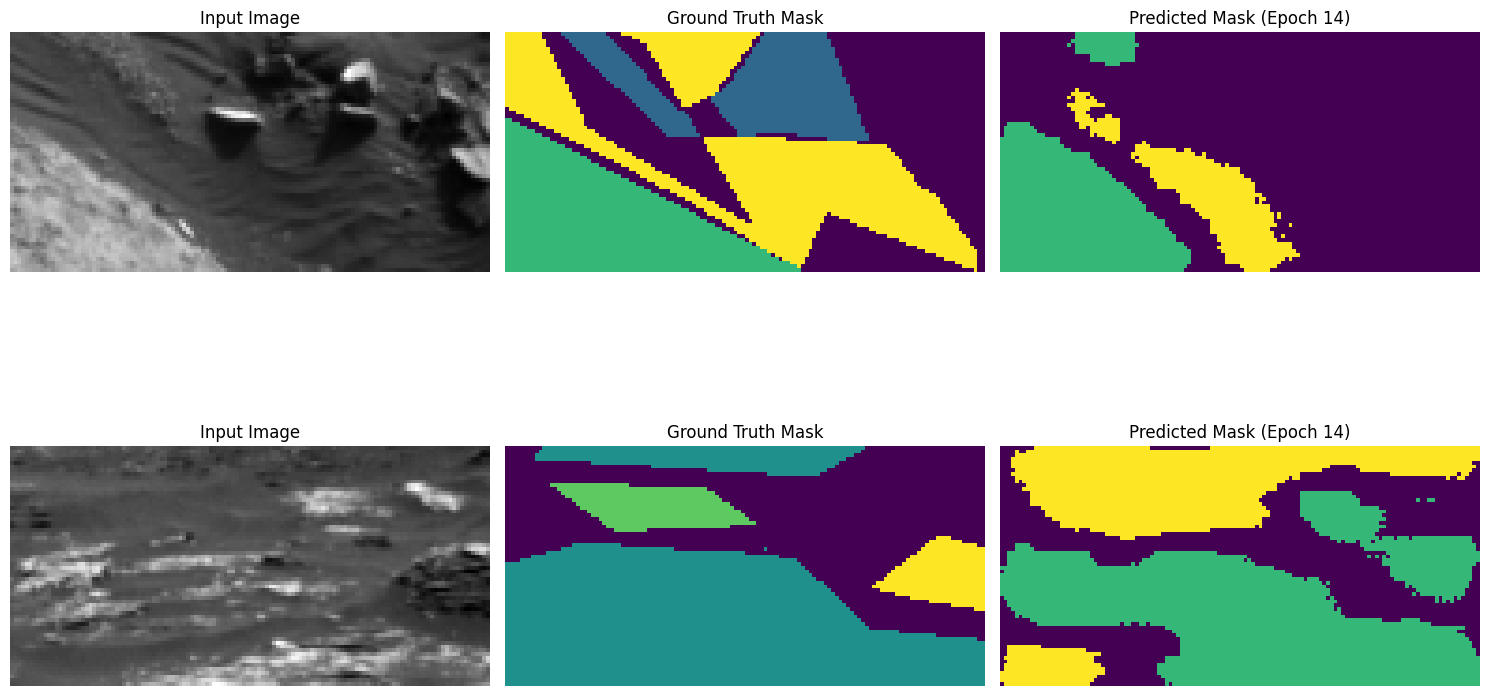

188/188 ━━━━━━━━━━━━━━━━━━━━ 38s 200ms/step - accuracy: 0.7272 - loss: 0.7042 - mean_io_u: 0.4280 - val_accuracy: 0.7219 - val_loss: 0.7470 - val_mean_io_u: 0.4306 - learning_rate: 1.0000e-04
Epoch 15/1000
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.7328 - loss: 0.6911 - mean_io_u: 0.4334
Epoch 15: val_loss improved from 0.74704 to 0.74516, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


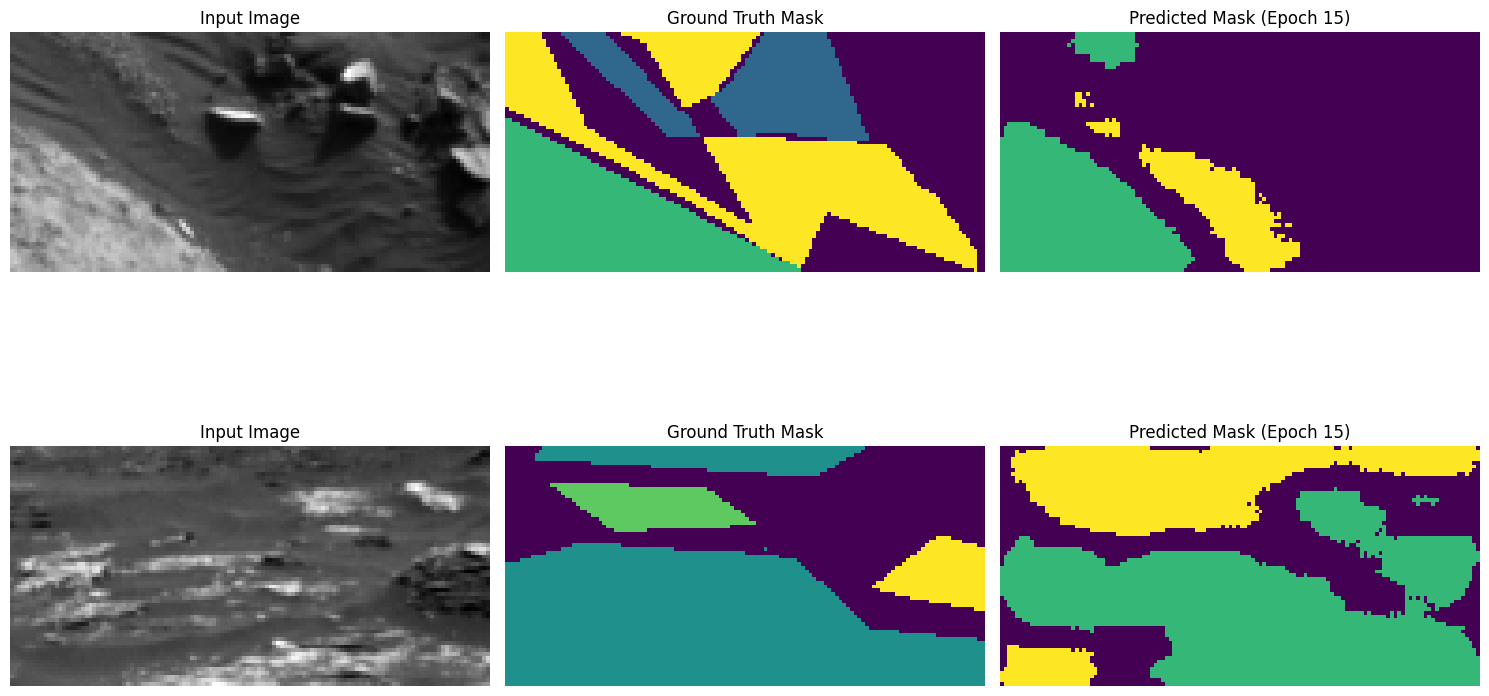

188/188 ━━━━━━━━━━━━━━━━━━━━ 38s 200ms/step - accuracy: 0.7328 - loss: 0.6911 - mean_io_u: 0.4333 - val_accuracy: 0.7230 - val_loss: 0.7452 - val_mean_io_u: 0.4324 - learning_rate: 1.0000e-04
Epoch 16/1000
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.7382 - loss: 0.6771 - mean_io_u: 0.4391
Epoch 16: val_loss improved from 0.74516 to 0.73590, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


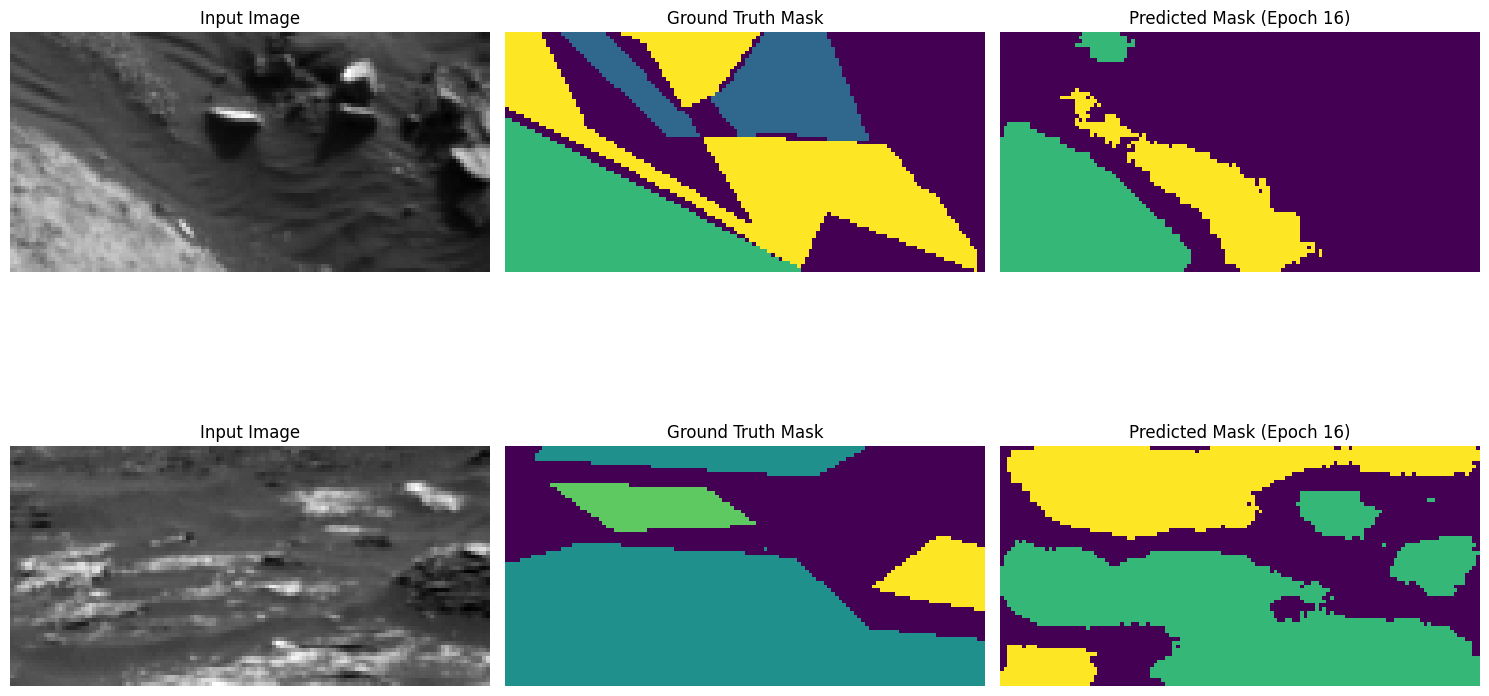

188/188 ━━━━━━━━━━━━━━━━━━━━ 38s 200ms/step - accuracy: 0.7382 - loss: 0.6771 - mean_io_u: 0.4391 - val_accuracy: 0.7277 - val_loss: 0.7359 - val_mean_io_u: 0.4360 - learning_rate: 1.0000e-04
Epoch 17/1000
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.7429 - loss: 0.6634 - mean_io_u: 0.4435
Epoch 17: val_loss did not improve from 0.73590
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


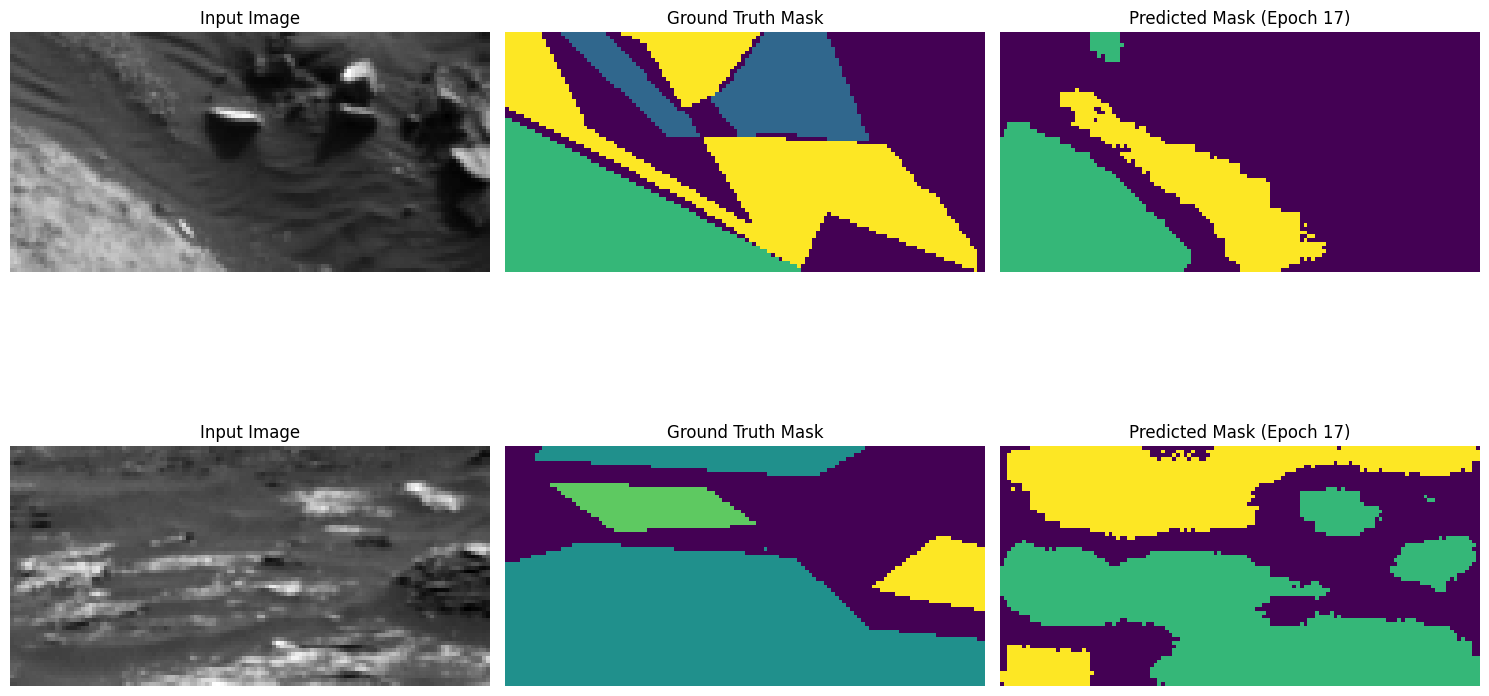

188/188 ━━━━━━━━━━━━━━━━━━━━ 37s 198ms/step - accuracy: 0.7428 - loss: 0.6635 - mean_io_u: 0.4435 - val_accuracy: 0.7284 - val_loss: 0.7385 - val_mean_io_u: 0.4368 - learning_rate: 1.0000e-04
Epoch 18/1000
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.7476 - loss: 0.6502 - mean_io_u: 0.4474
Epoch 18: val_loss improved from 0.73590 to 0.73544, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


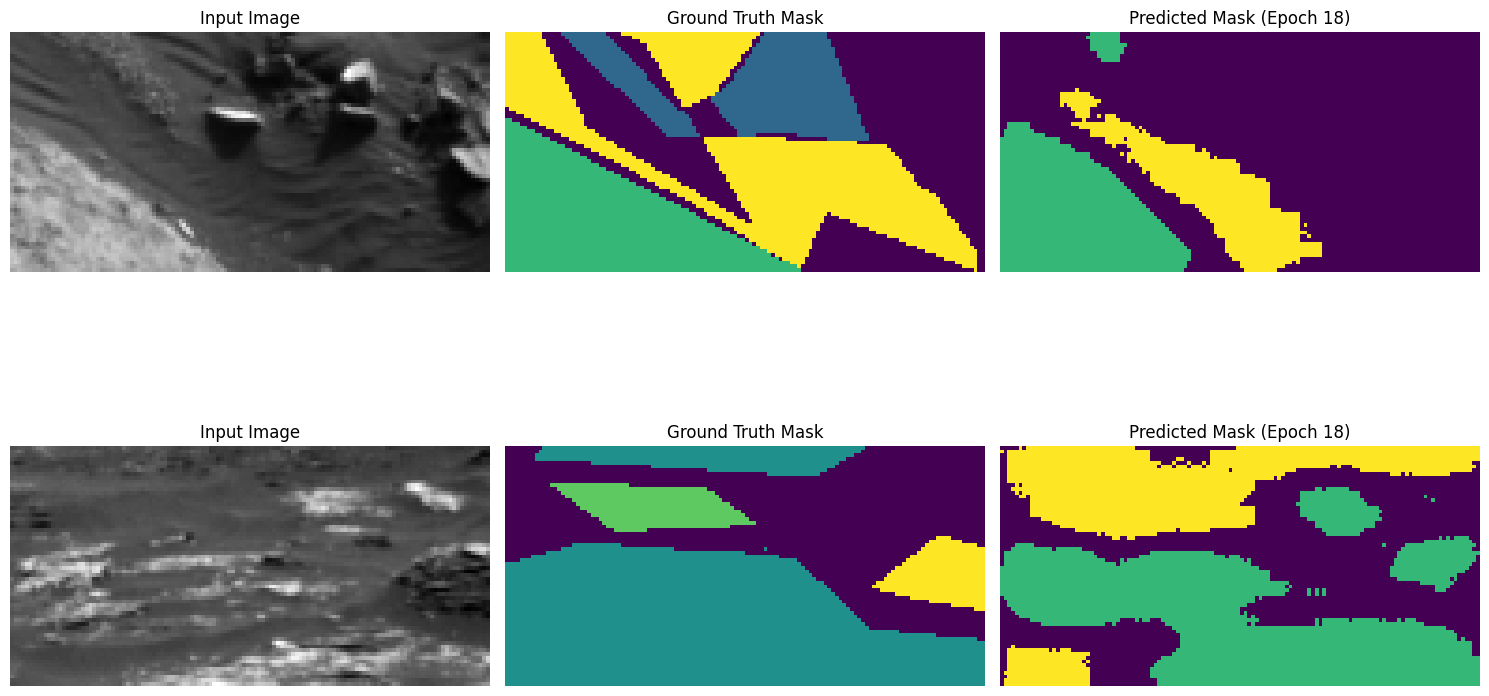

188/188 ━━━━━━━━━━━━━━━━━━━━ 38s 200ms/step - accuracy: 0.7476 - loss: 0.6502 - mean_io_u: 0.4474 - val_accuracy: 0.7280 - val_loss: 0.7354 - val_mean_io_u: 0.4358 - learning_rate: 1.0000e-04
Epoch 19/1000
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.7518 - loss: 0.6380 - mean_io_u: 0.4509
Epoch 19: val_loss improved from 0.73544 to 0.72921, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


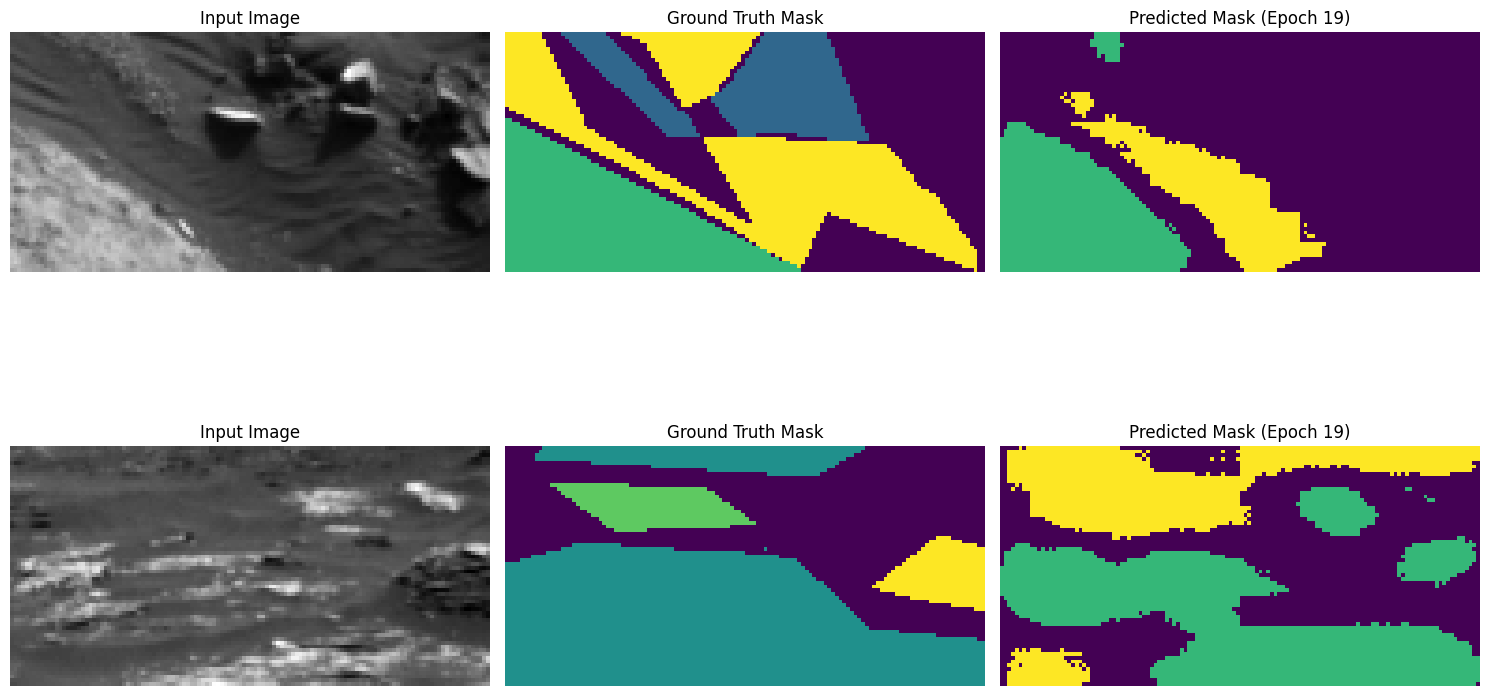

188/188 ━━━━━━━━━━━━━━━━━━━━ 38s 203ms/step - accuracy: 0.7518 - loss: 0.6381 - mean_io_u: 0.4509 - val_accuracy: 0.7288 - val_loss: 0.7292 - val_mean_io_u: 0.4349 - learning_rate: 1.0000e-04
Epoch 20/1000
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.7532 - loss: 0.6347 - mean_io_u: 0.4517
Epoch 20: val_loss did not improve from 0.72921
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


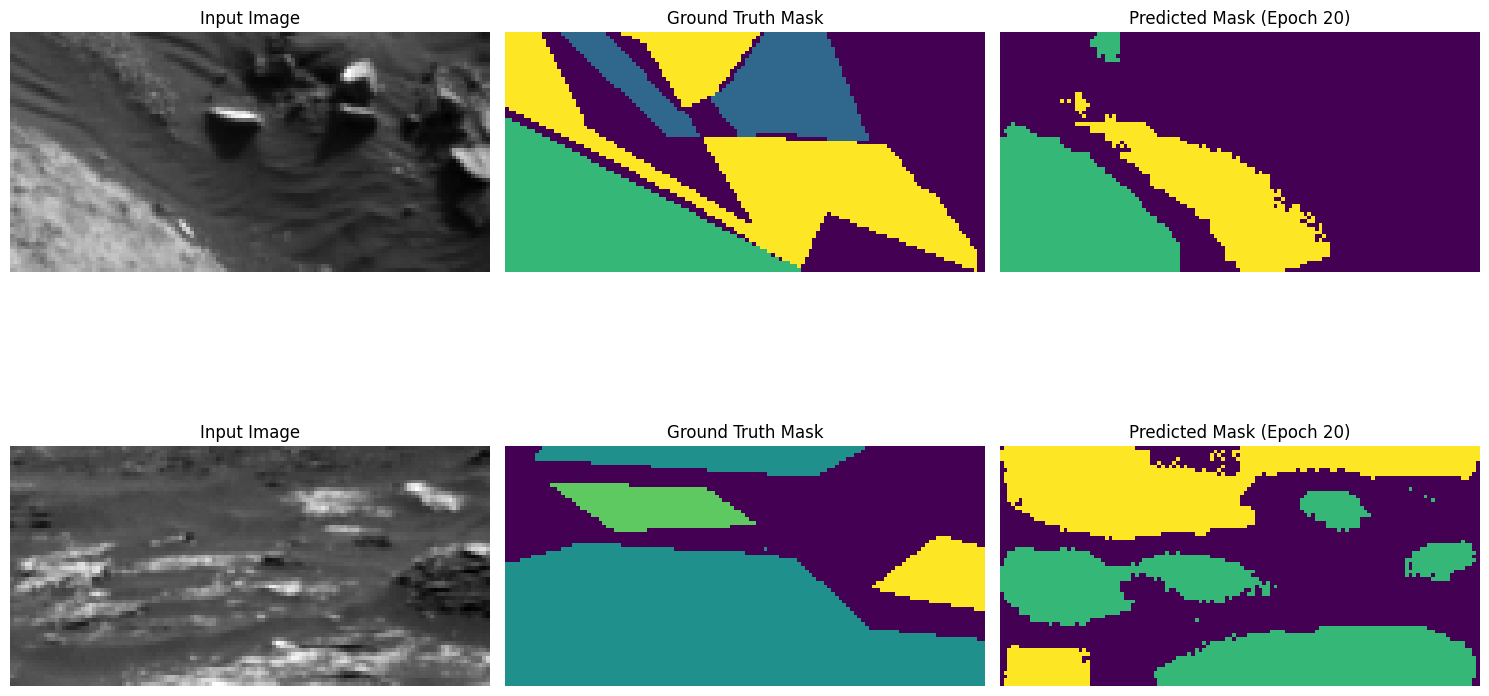

188/188 ━━━━━━━━━━━━━━━━━━━━ 37s 199ms/step - accuracy: 0.7532 - loss: 0.6347 - mean_io_u: 0.4517 - val_accuracy: 0.7200 - val_loss: 0.7653 - val_mean_io_u: 0.4267 - learning_rate: 1.0000e-04
Epoch 21/1000
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.7575 - loss: 0.6251 - mean_io_u: 0.4563
Epoch 21: val_loss did not improve from 0.72921
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


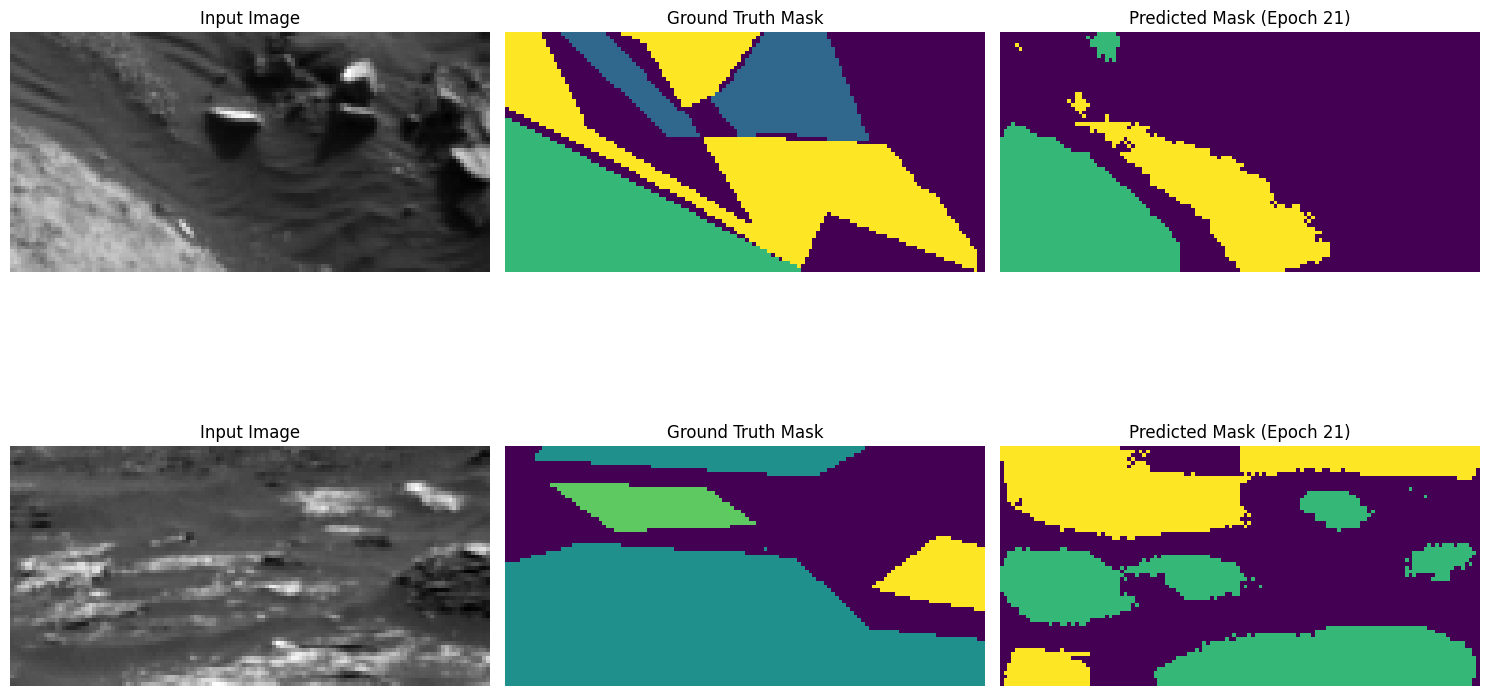

188/188 ━━━━━━━━━━━━━━━━━━━━ 37s 198ms/step - accuracy: 0.7575 - loss: 0.6251 - mean_io_u: 0.4563 - val_accuracy: 0.7189 - val_loss: 0.7762 - val_mean_io_u: 0.4234 - learning_rate: 1.0000e-04
Epoch 22/1000
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.7609 - loss: 0.6163 - mean_io_u: 0.4590
Epoch 22: val_loss did not improve from 0.72921
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


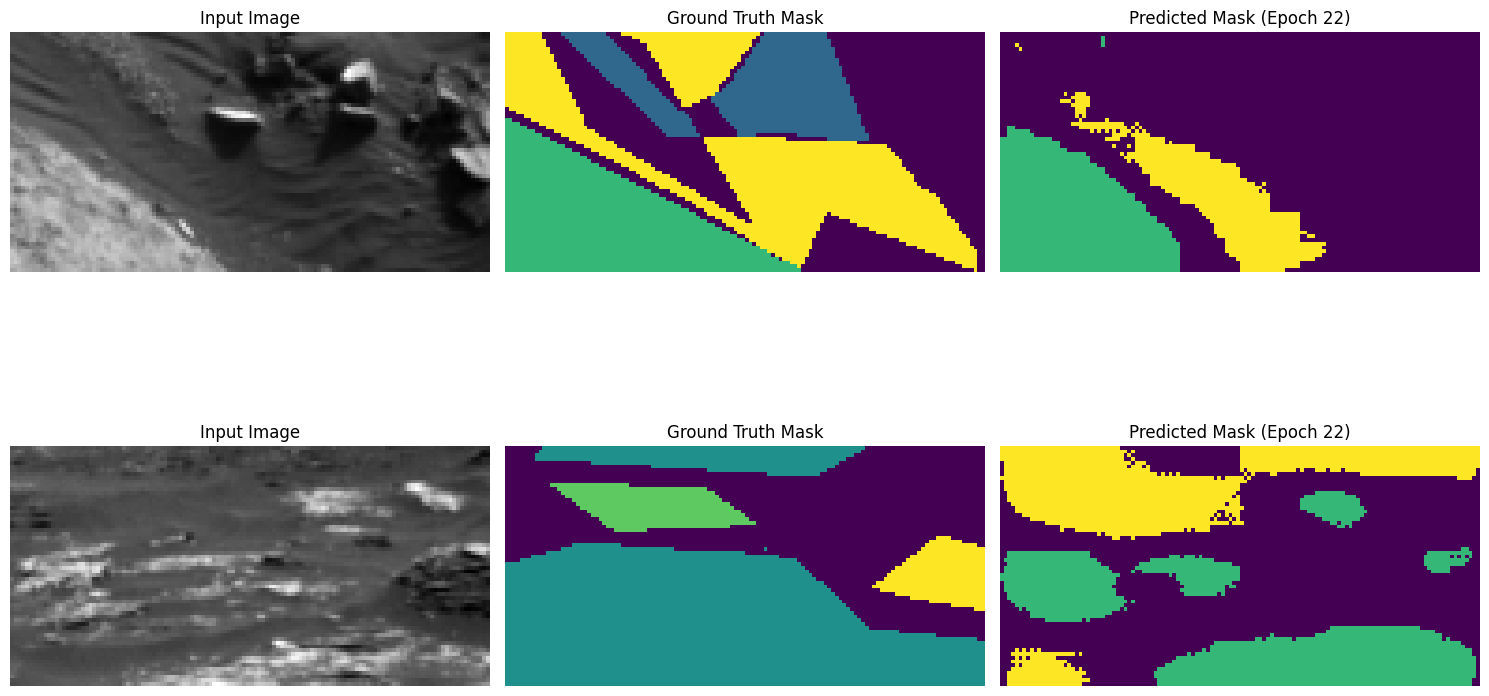

188/188 ━━━━━━━━━━━━━━━━━━━━ 37s 197ms/step - accuracy: 0.7609 - loss: 0.6163 - mean_io_u: 0.4590 - val_accuracy: 0.7194 - val_loss: 0.7724 - val_mean_io_u: 0.4199 - learning_rate: 1.0000e-04
Epoch 23/1000
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.7638 - loss: 0.6086 - mean_io_u: 0.4613
Epoch 23: val_loss did not improve from 0.72921
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


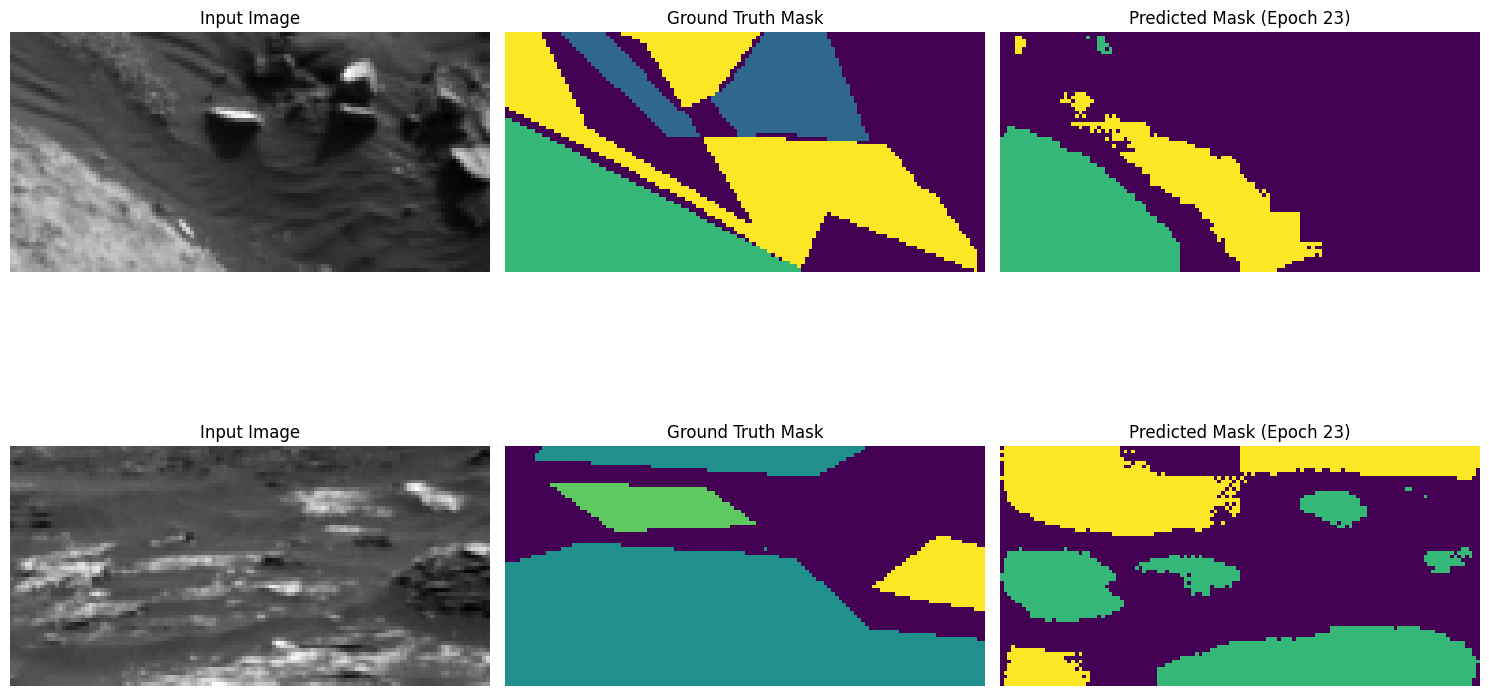

188/188 ━━━━━━━━━━━━━━━━━━━━ 37s 197ms/step - accuracy: 0.7638 - loss: 0.6086 - mean_io_u: 0.4613 - val_accuracy: 0.7145 - val_loss: 0.7789 - val_mean_io_u: 0.4147 - learning_rate: 1.0000e-04
Epoch 24/1000
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.7682 - loss: 0.5973 - mean_io_u: 0.4653
Epoch 24: val_loss improved from 0.72921 to 0.72876, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


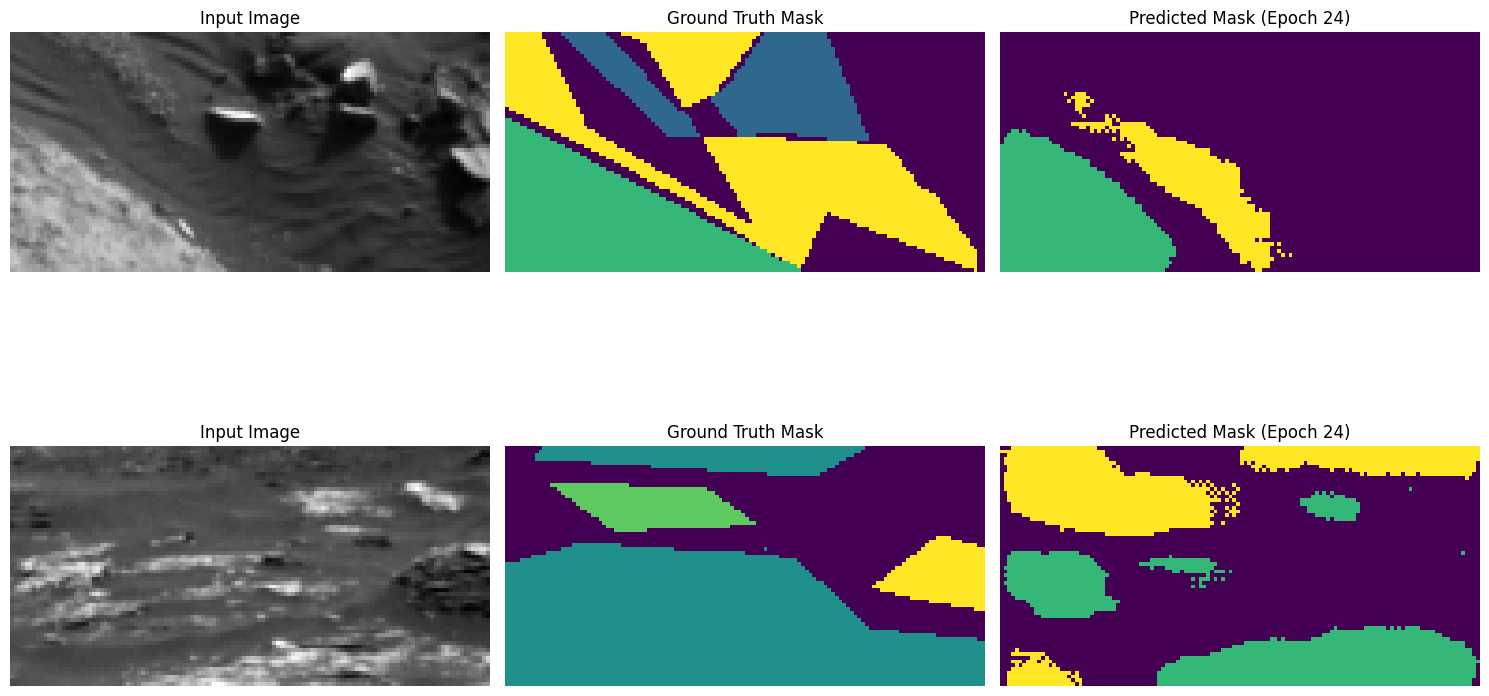

188/188 ━━━━━━━━━━━━━━━━━━━━ 37s 199ms/step - accuracy: 0.7682 - loss: 0.5973 - mean_io_u: 0.4653 - val_accuracy: 0.7274 - val_loss: 0.7288 - val_mean_io_u: 0.4242 - learning_rate: 1.0000e-04
Epoch 25/1000
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.7731 - loss: 0.5830 - mean_io_u: 0.4699
Epoch 25: val_loss improved from 0.72876 to 0.70792, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


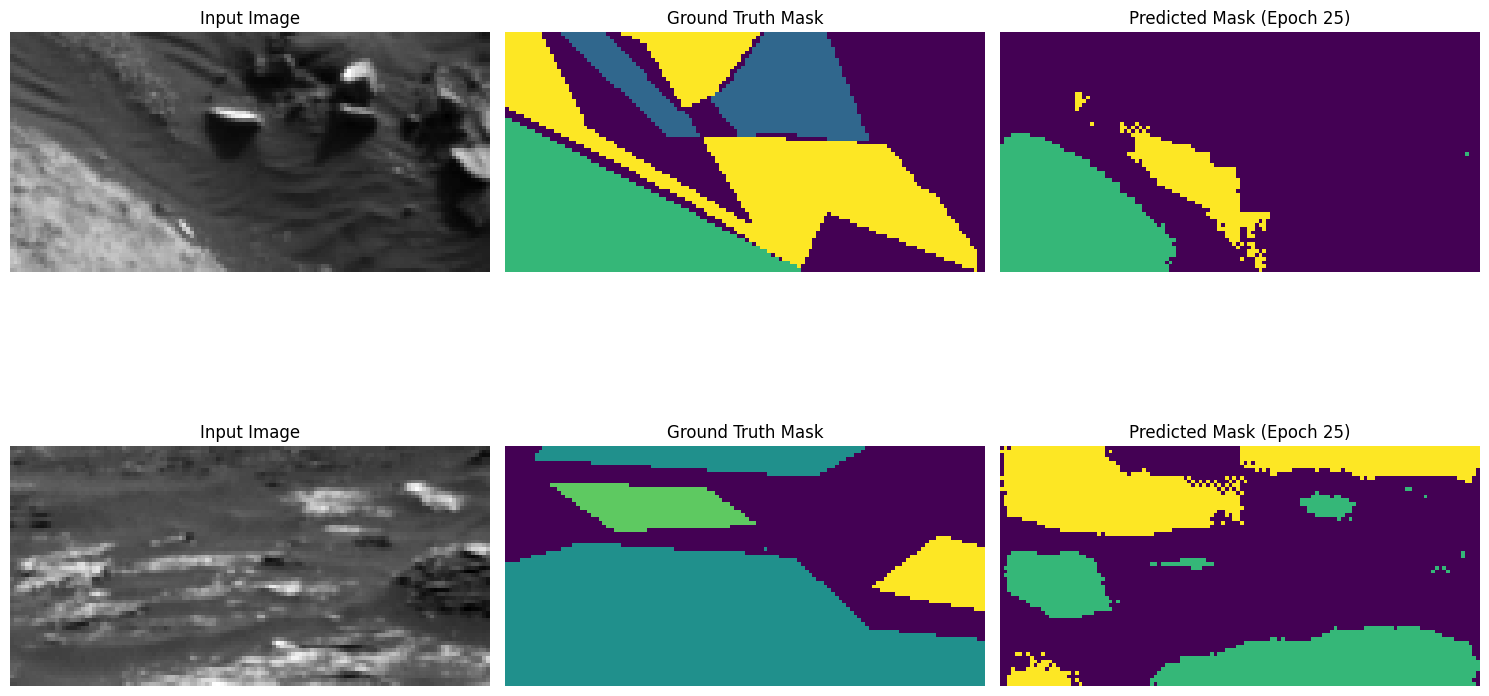

188/188 ━━━━━━━━━━━━━━━━━━━━ 37s 199ms/step - accuracy: 0.7731 - loss: 0.5830 - mean_io_u: 0.4699 - val_accuracy: 0.7349 - val_loss: 0.7079 - val_mean_io_u: 0.4307 - learning_rate: 1.0000e-04
Epoch 26/1000
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.7801 - loss: 0.5661 - mean_io_u: 0.4765
Epoch 26: val_loss improved from 0.70792 to 0.70606, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


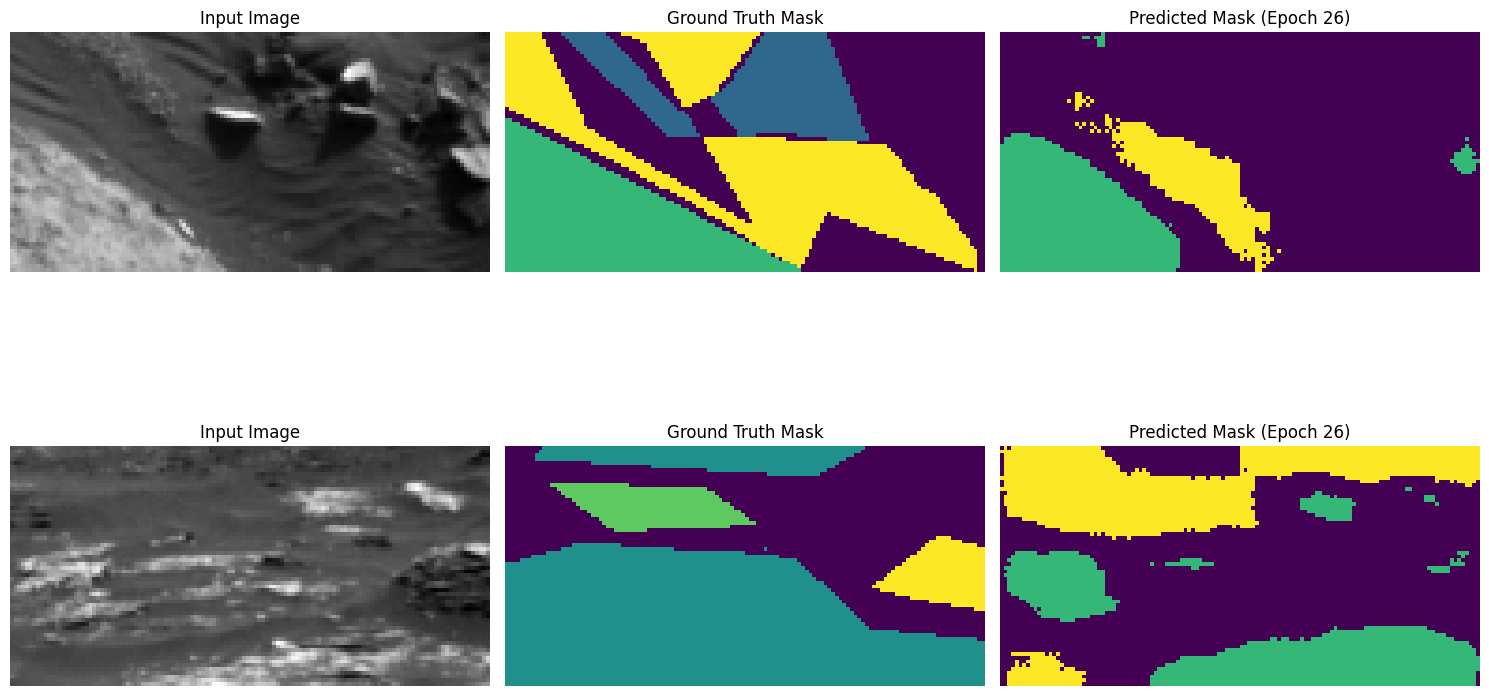

188/188 ━━━━━━━━━━━━━━━━━━━━ 38s 201ms/step - accuracy: 0.7801 - loss: 0.5661 - mean_io_u: 0.4764 - val_accuracy: 0.7352 - val_loss: 0.7061 - val_mean_io_u: 0.4325 - learning_rate: 1.0000e-04
Epoch 27/1000
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.7856 - loss: 0.5531 - mean_io_u: 0.4809
Epoch 27: val_loss did not improve from 0.70606
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


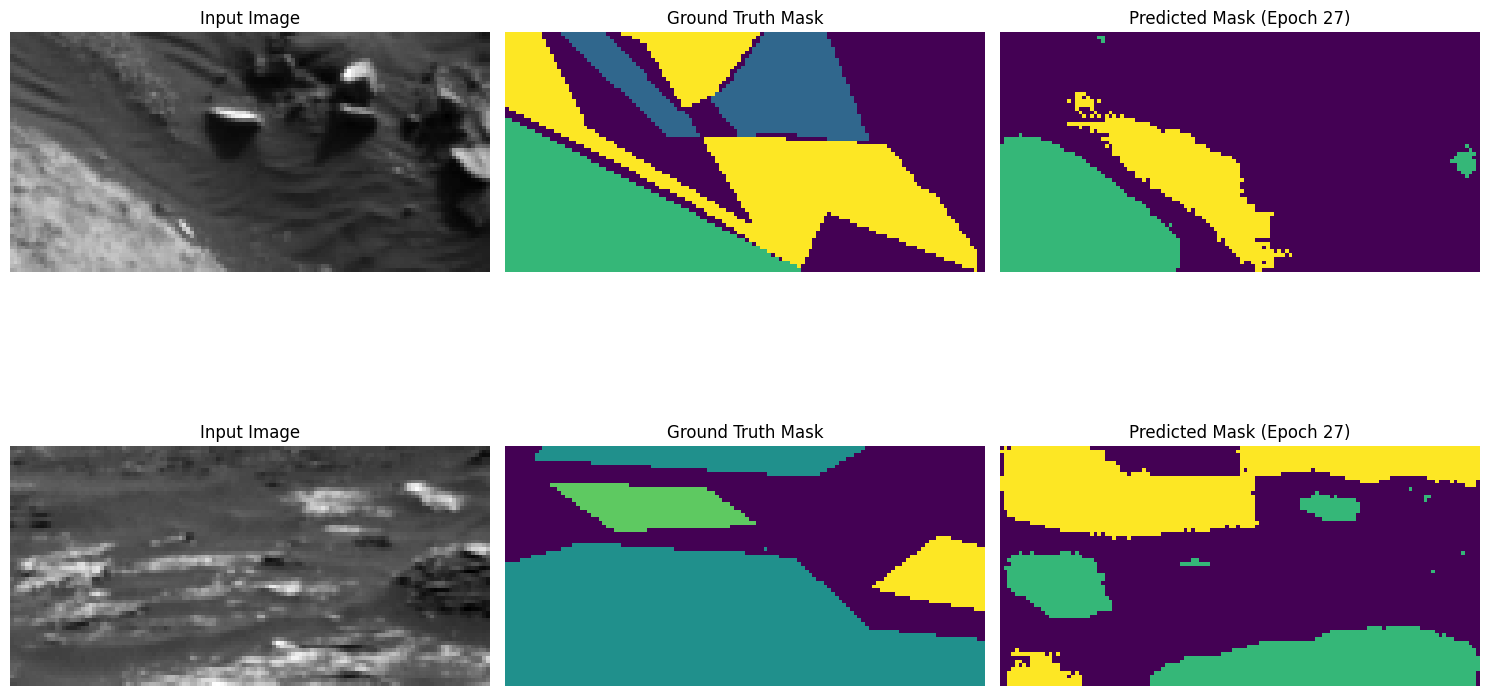

188/188 ━━━━━━━━━━━━━━━━━━━━ 37s 198ms/step - accuracy: 0.7856 - loss: 0.5531 - mean_io_u: 0.4808 - val_accuracy: 0.7340 - val_loss: 0.7173 - val_mean_io_u: 0.4295 - learning_rate: 1.0000e-04
Epoch 28/1000
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.7885 - loss: 0.5458 - mean_io_u: 0.4830
Epoch 28: val_loss did not improve from 0.70606
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


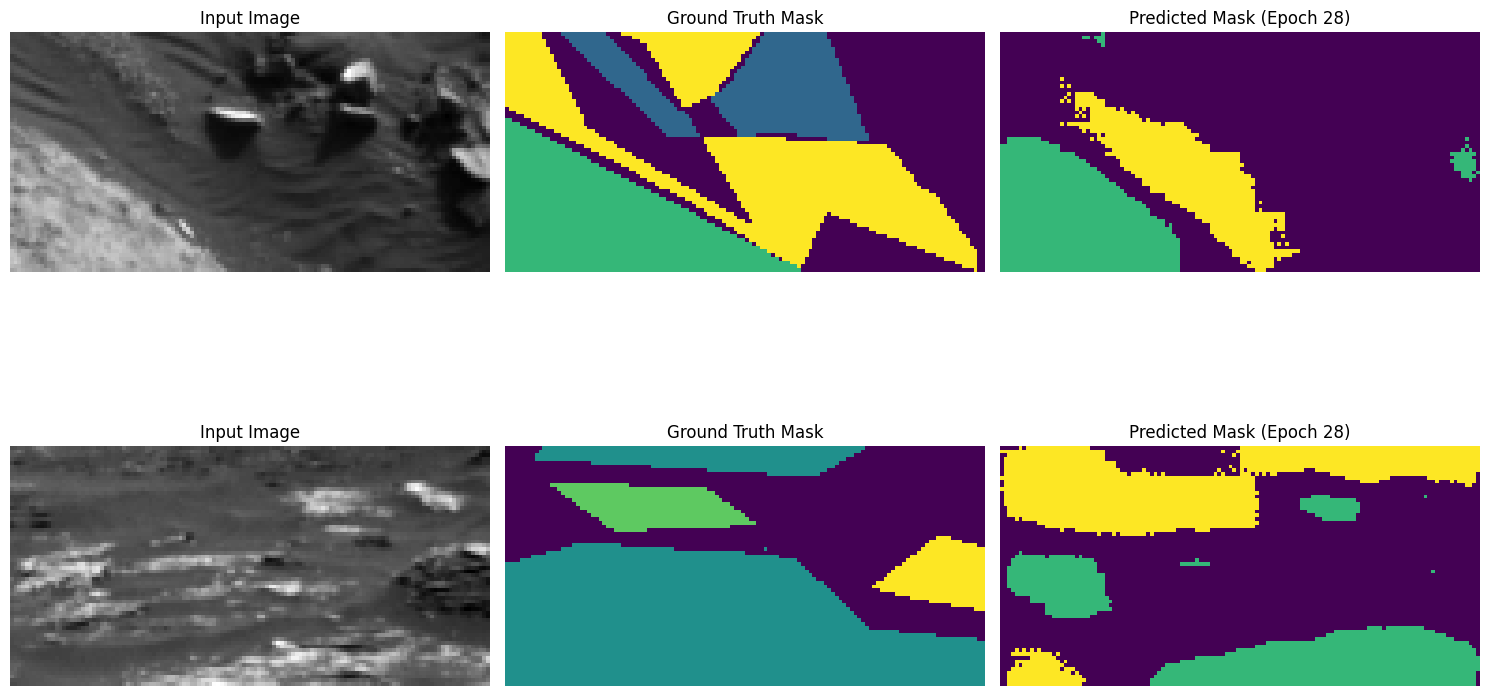

188/188 ━━━━━━━━━━━━━━━━━━━━ 37s 199ms/step - accuracy: 0.7885 - loss: 0.5458 - mean_io_u: 0.4830 - val_accuracy: 0.7354 - val_loss: 0.7162 - val_mean_io_u: 0.4303 - learning_rate: 1.0000e-04
Epoch 29/1000
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.7907 - loss: 0.5389 - mean_io_u: 0.4846
Epoch 29: val_loss did not improve from 0.70606
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


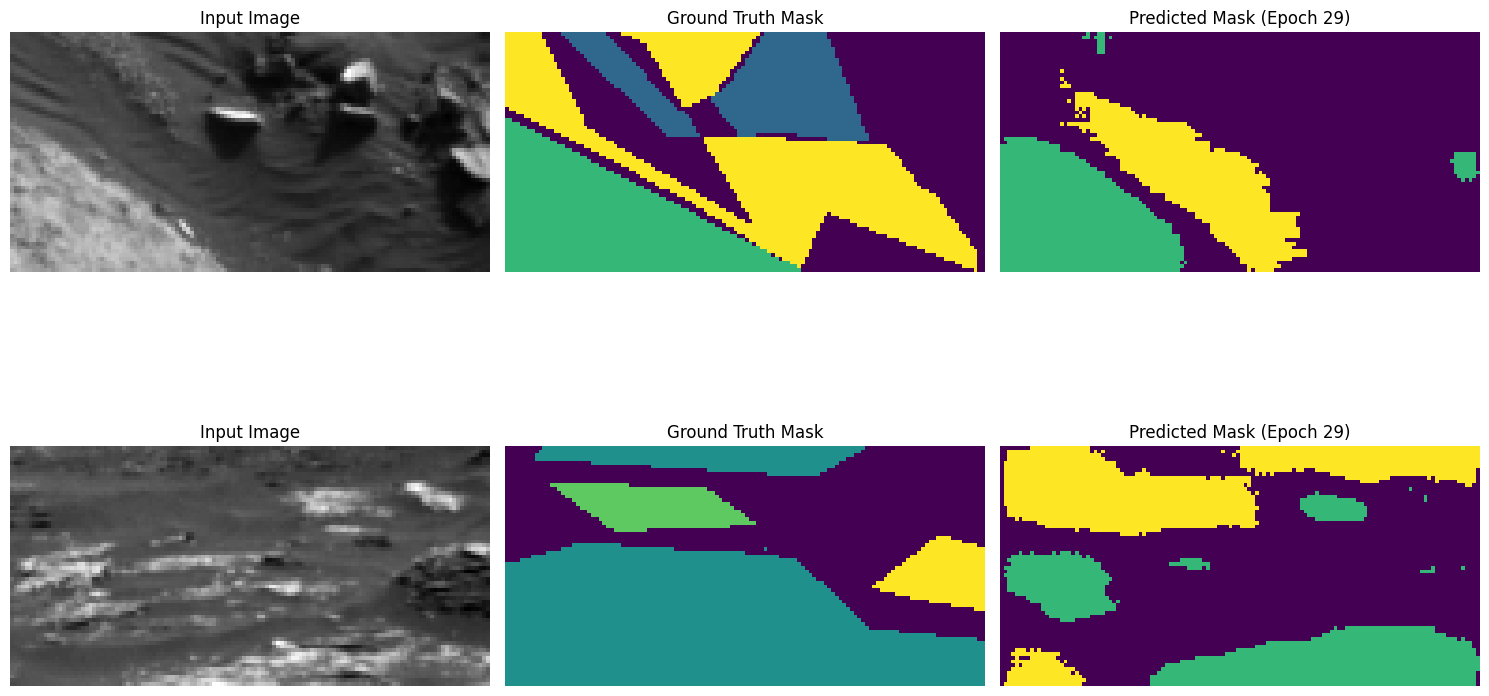

188/188 ━━━━━━━━━━━━━━━━━━━━ 37s 198ms/step - accuracy: 0.7906 - loss: 0.5389 - mean_io_u: 0.4846 - val_accuracy: 0.7364 - val_loss: 0.7198 - val_mean_io_u: 0.4299 - learning_rate: 1.0000e-04
Epoch 30/1000
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.7939 - loss: 0.5299 - mean_io_u: 0.4871
Epoch 30: val_loss did not improve from 0.70606
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


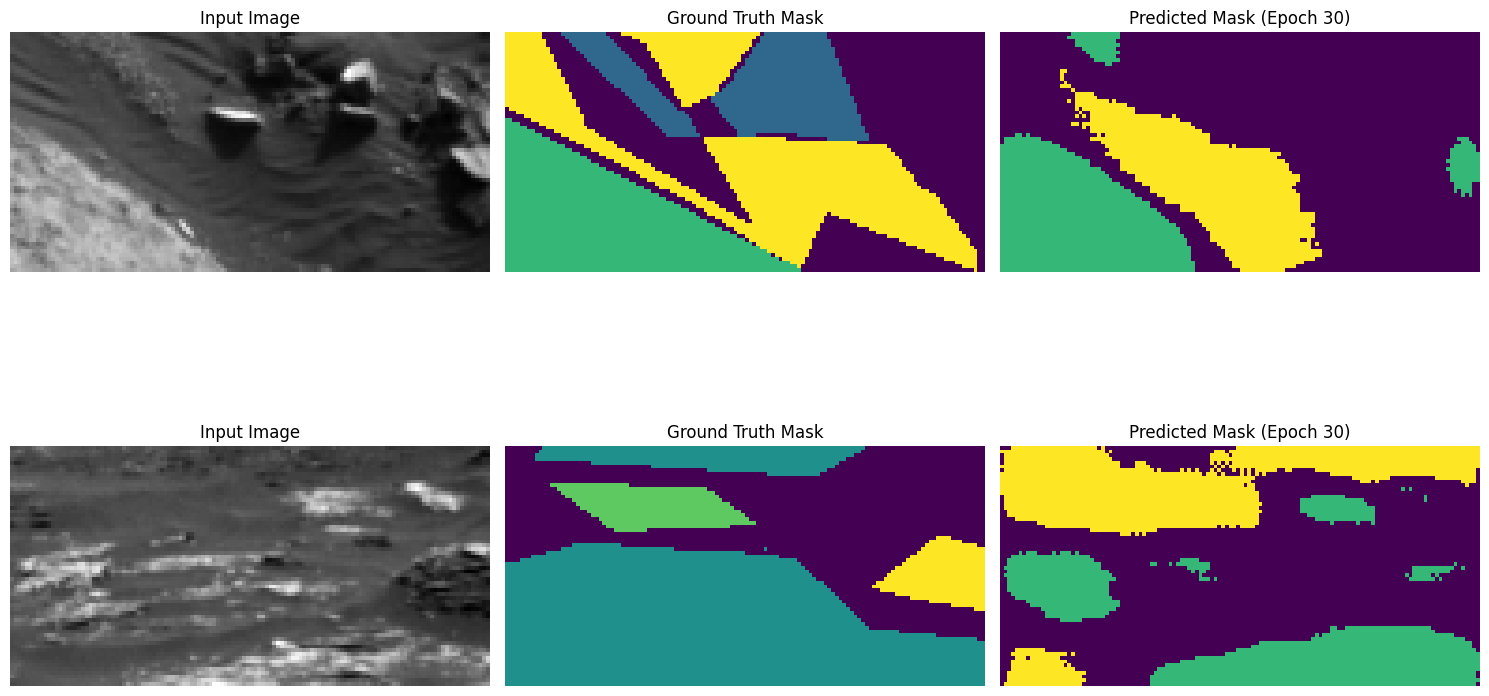

188/188 ━━━━━━━━━━━━━━━━━━━━ 37s 199ms/step - accuracy: 0.7938 - loss: 0.5299 - mean_io_u: 0.4871 - val_accuracy: 0.7312 - val_loss: 0.7407 - val_mean_io_u: 0.4272 - learning_rate: 1.0000e-04
Epoch 31/1000
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.7997 - loss: 0.5164 - mean_io_u: 0.4930
Epoch 31: val_loss did not improve from 0.70606

Epoch 31: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


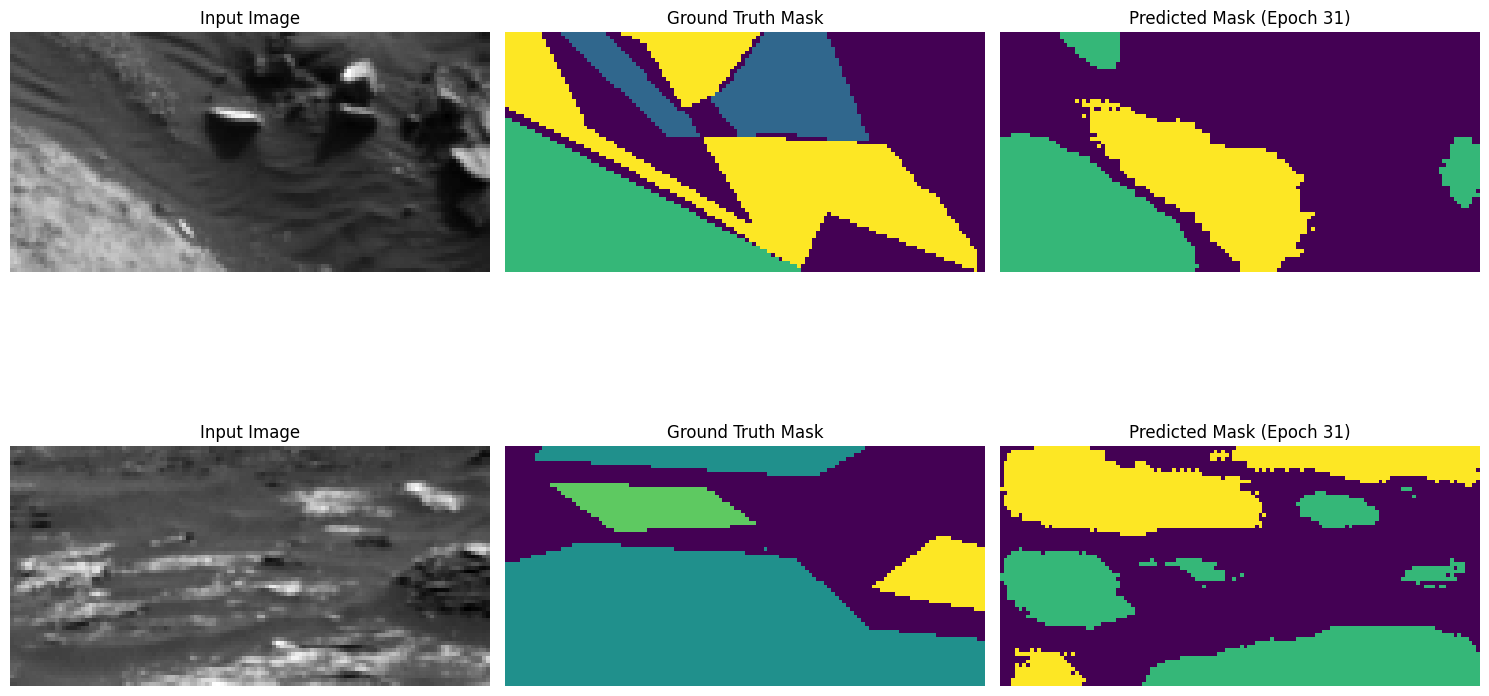

188/188 ━━━━━━━━━━━━━━━━━━━━ 37s 197ms/step - accuracy: 0.7997 - loss: 0.5164 - mean_io_u: 0.4930 - val_accuracy: 0.7372 - val_loss: 0.7218 - val_mean_io_u: 0.4332 - learning_rate: 1.0000e-04
Epoch 32/1000
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.8117 - loss: 0.4831 - mean_io_u: 0.5047
Epoch 32: val_loss improved from 0.70606 to 0.63298, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


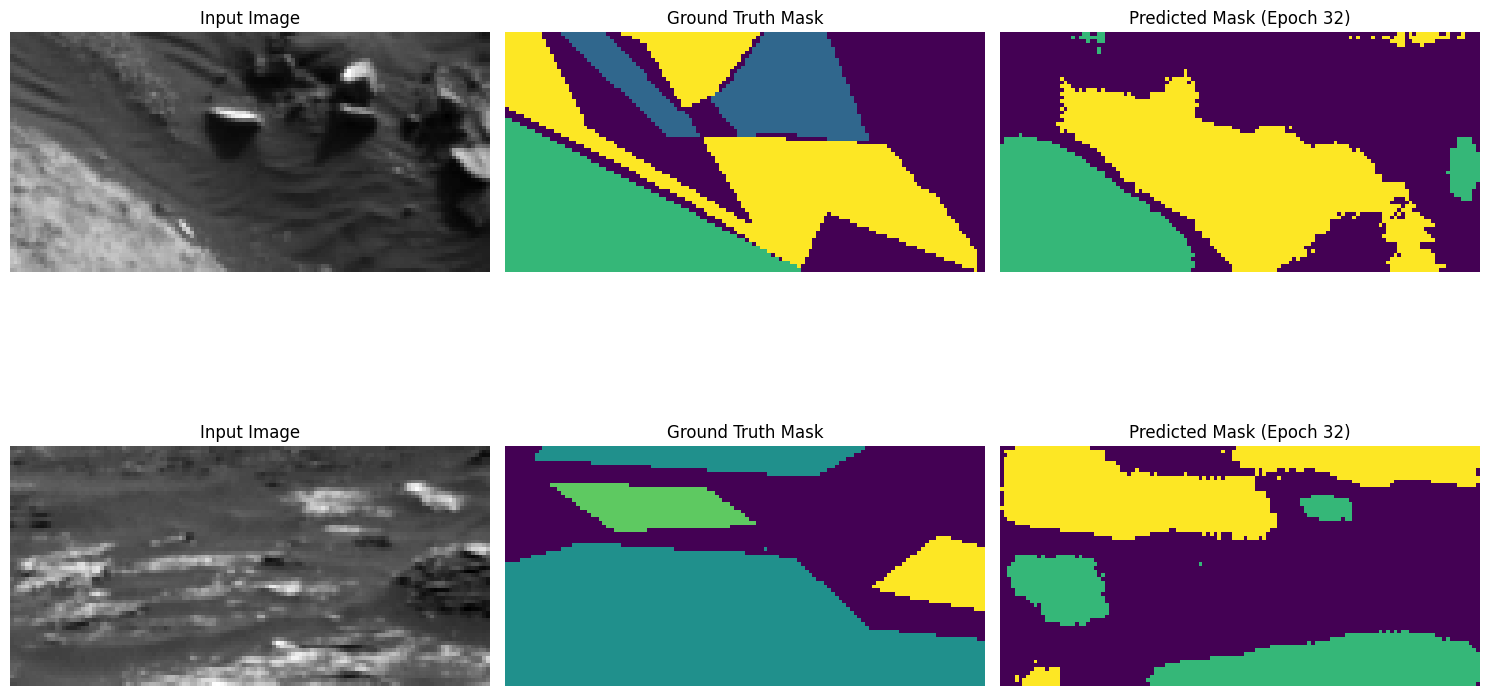

188/188 ━━━━━━━━━━━━━━━━━━━━ 38s 200ms/step - accuracy: 0.8117 - loss: 0.4831 - mean_io_u: 0.5047 - val_accuracy: 0.7665 - val_loss: 0.6330 - val_mean_io_u: 0.4597 - learning_rate: 5.0000e-05
Epoch 33/1000
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.8192 - loss: 0.4657 - mean_io_u: 0.5120
Epoch 33: val_loss improved from 0.63298 to 0.63277, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


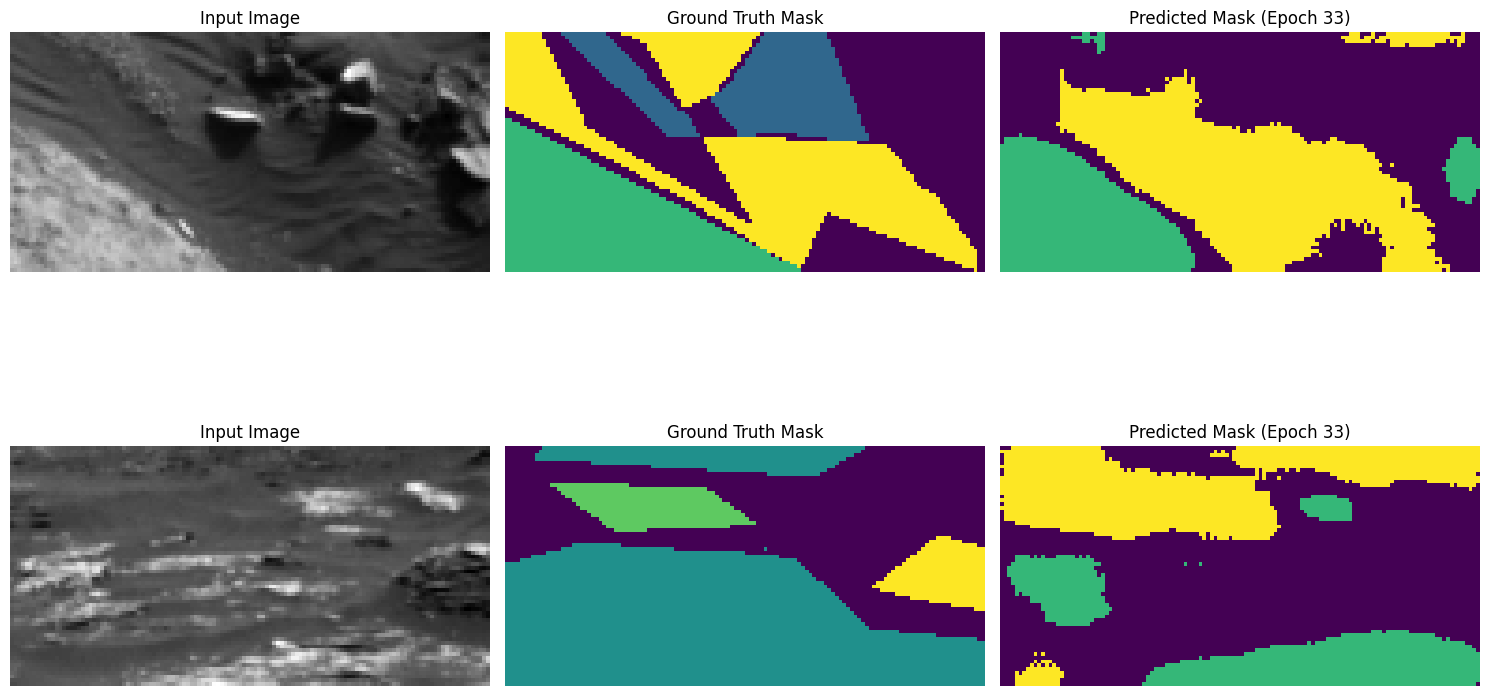

188/188 ━━━━━━━━━━━━━━━━━━━━ 38s 201ms/step - accuracy: 0.8191 - loss: 0.4658 - mean_io_u: 0.5120 - val_accuracy: 0.7669 - val_loss: 0.6328 - val_mean_io_u: 0.4609 - learning_rate: 5.0000e-05
Epoch 34/1000
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.8232 - loss: 0.4553 - mean_io_u: 0.5163
Epoch 34: val_loss did not improve from 0.63277
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


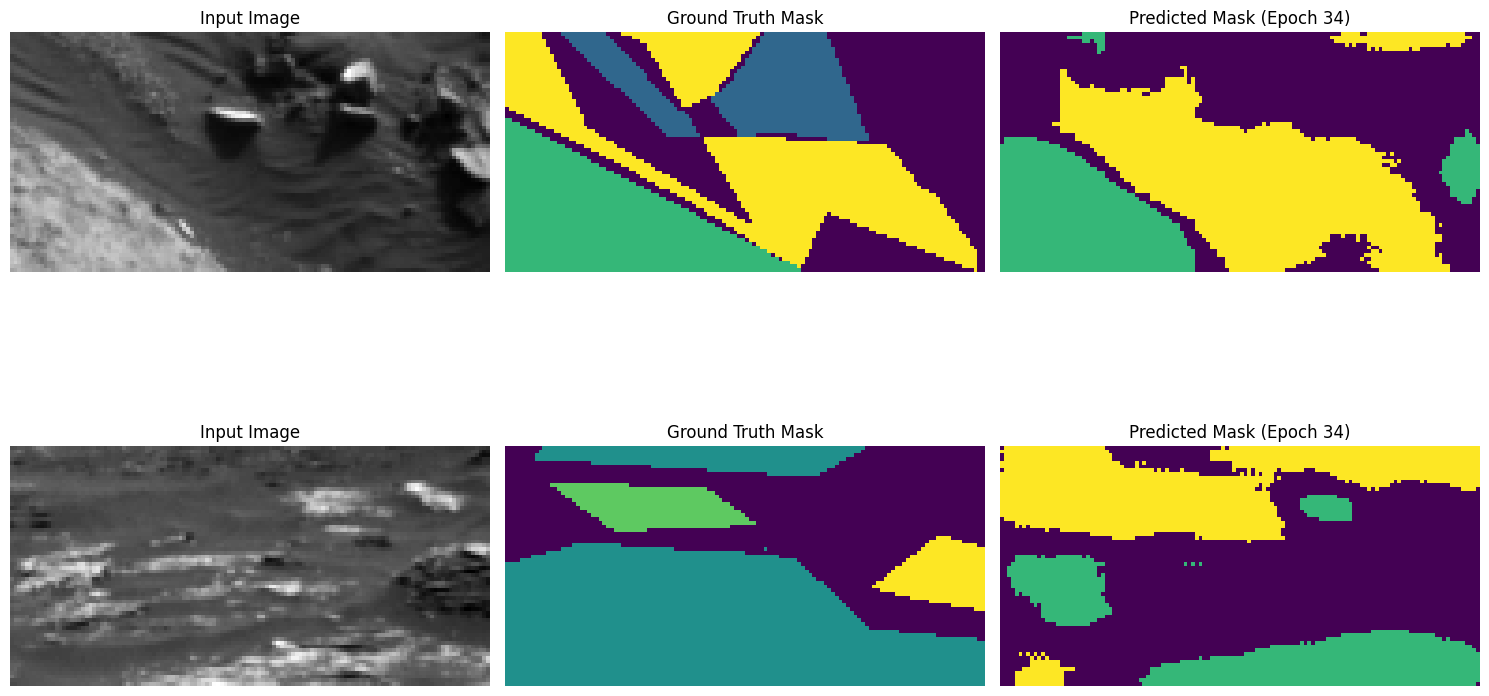

188/188 ━━━━━━━━━━━━━━━━━━━━ 37s 199ms/step - accuracy: 0.8232 - loss: 0.4553 - mean_io_u: 0.5163 - val_accuracy: 0.7666 - val_loss: 0.6348 - val_mean_io_u: 0.4622 - learning_rate: 5.0000e-05
Epoch 35/1000
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.8271 - loss: 0.4452 - mean_io_u: 0.5206
Epoch 35: val_loss did not improve from 0.63277
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


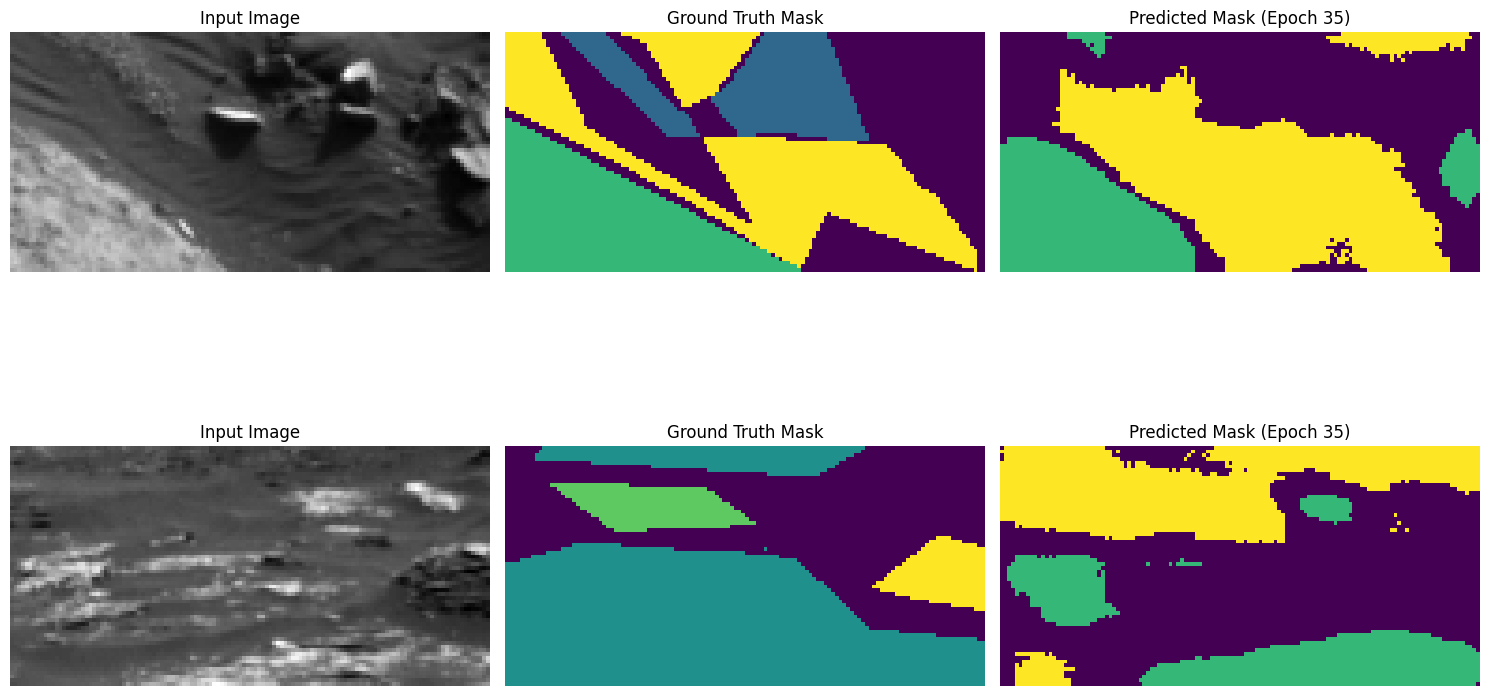

188/188 ━━━━━━━━━━━━━━━━━━━━ 37s 198ms/step - accuracy: 0.8271 - loss: 0.4452 - mean_io_u: 0.5206 - val_accuracy: 0.7657 - val_loss: 0.6386 - val_mean_io_u: 0.4626 - learning_rate: 5.0000e-05
Epoch 36/1000
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.8312 - loss: 0.4346 - mean_io_u: 0.5256
Epoch 36: val_loss did not improve from 0.63277
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


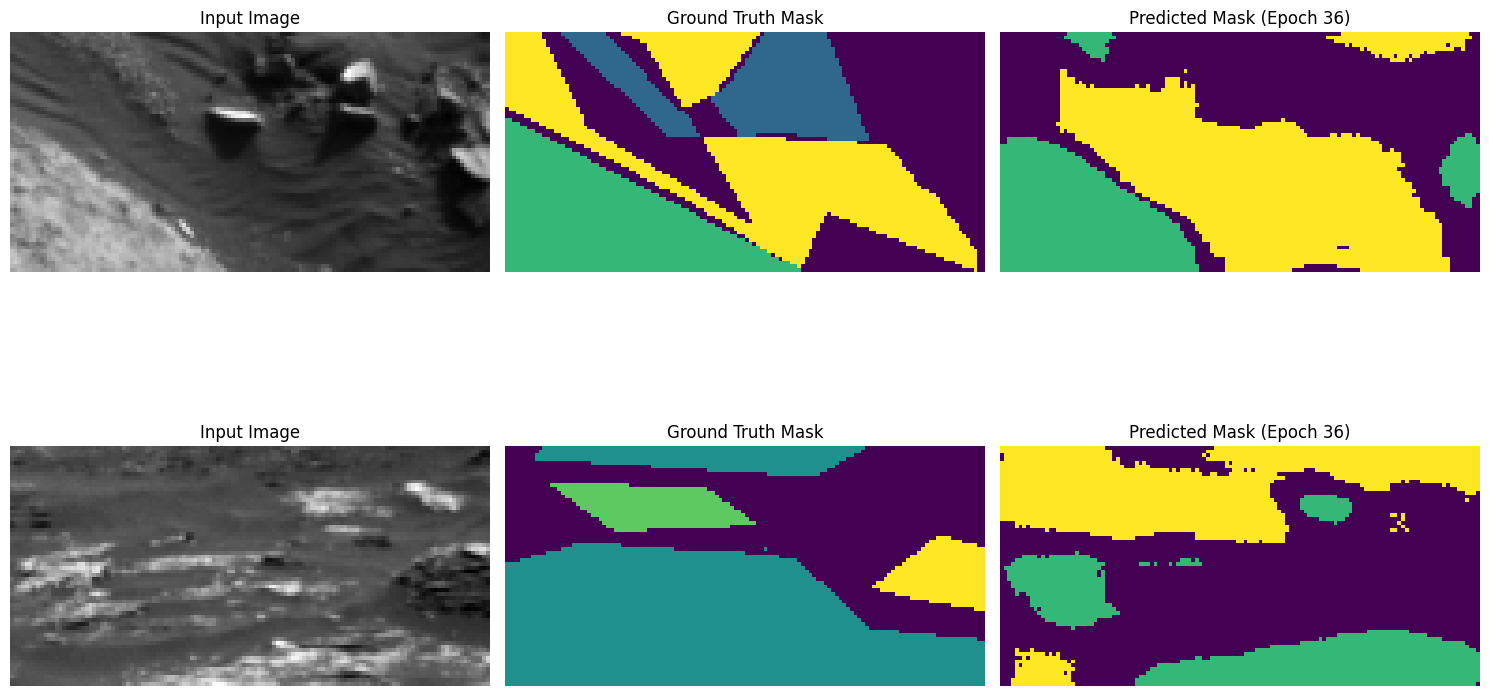

188/188 ━━━━━━━━━━━━━━━━━━━━ 37s 197ms/step - accuracy: 0.8312 - loss: 0.4347 - mean_io_u: 0.5255 - val_accuracy: 0.7645 - val_loss: 0.6433 - val_mean_io_u: 0.4619 - learning_rate: 5.0000e-05
Epoch 37/1000
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.8353 - loss: 0.4241 - mean_io_u: 0.5309
Epoch 37: val_loss did not improve from 0.63277
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


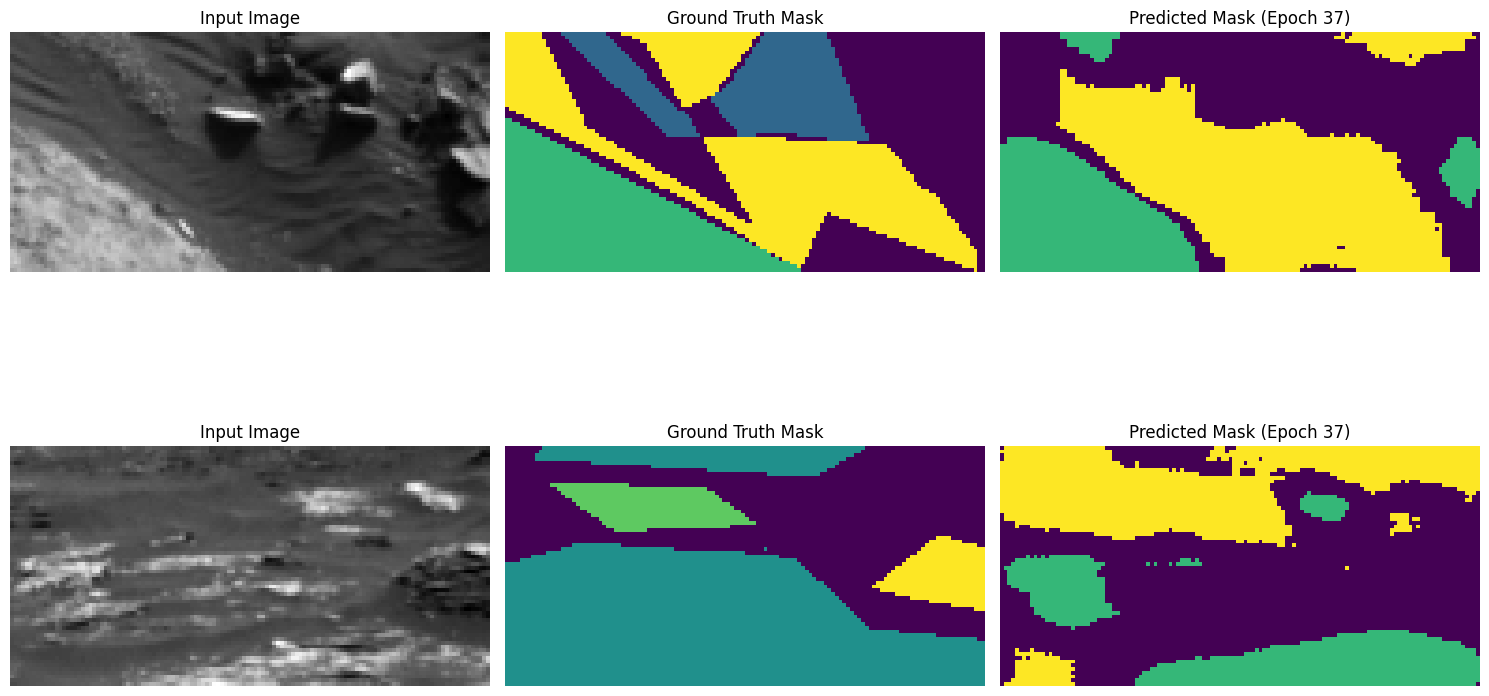

188/188 ━━━━━━━━━━━━━━━━━━━━ 37s 198ms/step - accuracy: 0.8353 - loss: 0.4241 - mean_io_u: 0.5309 - val_accuracy: 0.7641 - val_loss: 0.6477 - val_mean_io_u: 0.4611 - learning_rate: 5.0000e-05
Epoch 38/1000
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.8395 - loss: 0.4136 - mean_io_u: 0.5366
Epoch 38: val_loss did not improve from 0.63277

Epoch 38: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


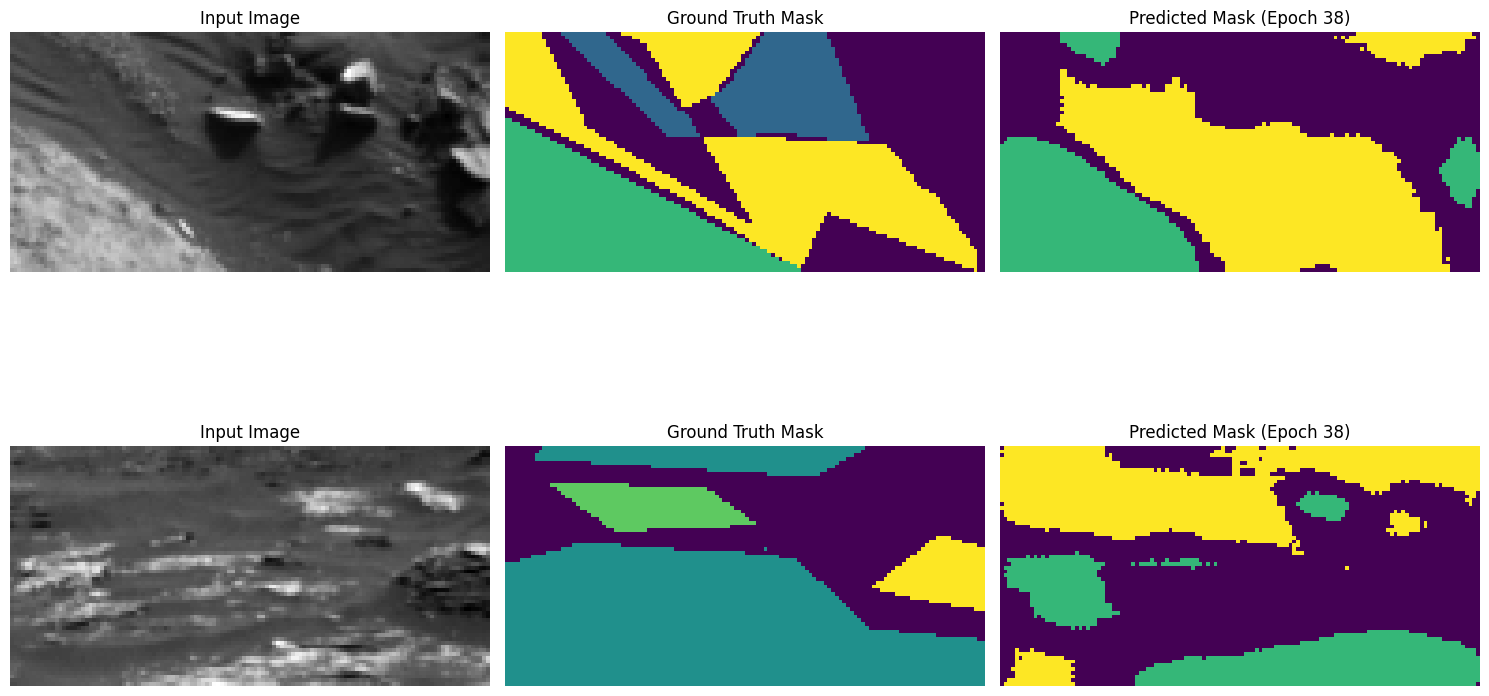

188/188 ━━━━━━━━━━━━━━━━━━━━ 37s 198ms/step - accuracy: 0.8395 - loss: 0.4137 - mean_io_u: 0.5366 - val_accuracy: 0.7633 - val_loss: 0.6540 - val_mean_io_u: 0.4608 - learning_rate: 5.0000e-05
Epoch 39/1000
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.8443 - loss: 0.3999 - mean_io_u: 0.5422
Epoch 39: val_loss did not improve from 0.63277
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


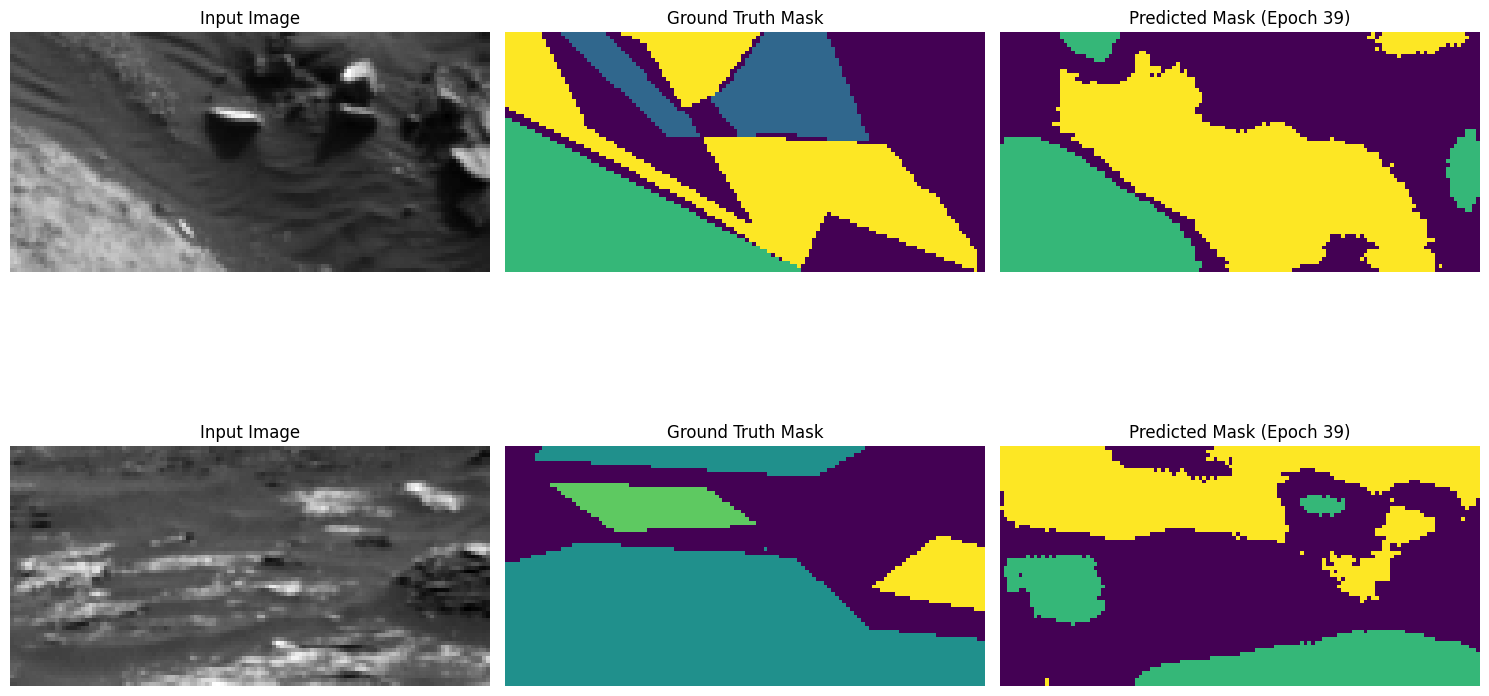

188/188 ━━━━━━━━━━━━━━━━━━━━ 37s 199ms/step - accuracy: 0.8443 - loss: 0.3999 - mean_io_u: 0.5422 - val_accuracy: 0.7675 - val_loss: 0.6638 - val_mean_io_u: 0.4625 - learning_rate: 2.5000e-05
Epoch 40/1000
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.8465 - loss: 0.3930 - mean_io_u: 0.5479
Epoch 40: val_loss did not improve from 0.63277
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


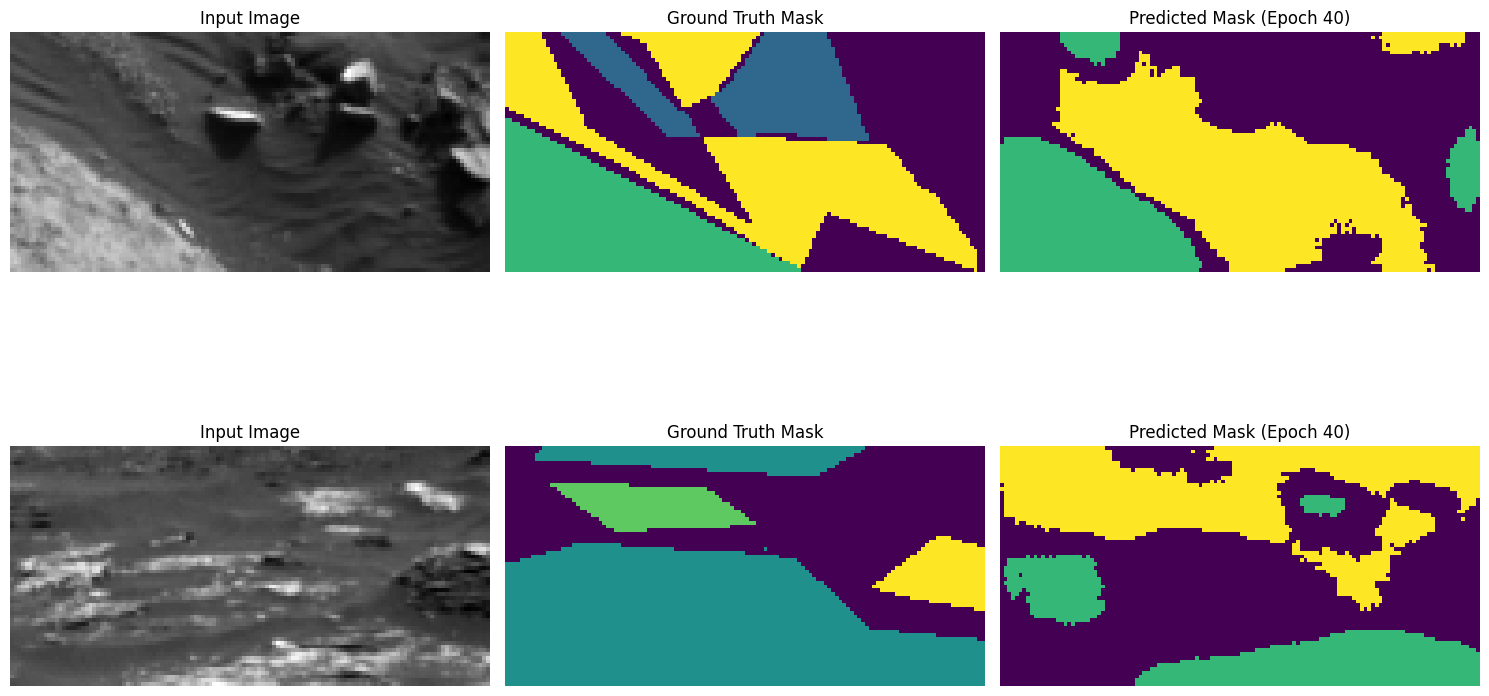

188/188 ━━━━━━━━━━━━━━━━━━━━ 37s 198ms/step - accuracy: 0.8465 - loss: 0.3930 - mean_io_u: 0.5478 - val_accuracy: 0.7681 - val_loss: 0.6650 - val_mean_io_u: 0.4624 - learning_rate: 2.5000e-05
Epoch 41/1000
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.8498 - loss: 0.3847 - mean_io_u: 0.5514
Epoch 41: val_loss did not improve from 0.63277
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


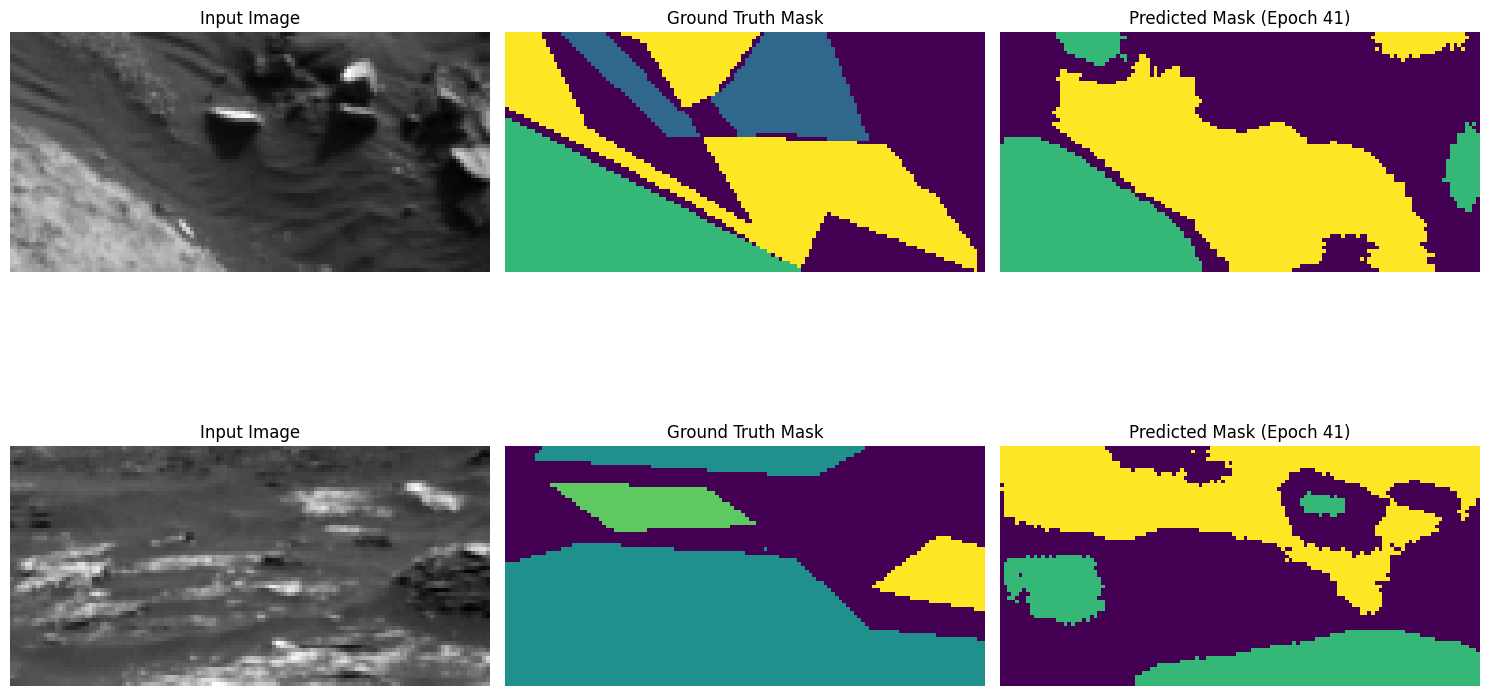

188/188 ━━━━━━━━━━━━━━━━━━━━ 38s 200ms/step - accuracy: 0.8498 - loss: 0.3847 - mean_io_u: 0.5514 - val_accuracy: 0.7671 - val_loss: 0.6711 - val_mean_io_u: 0.4620 - learning_rate: 2.5000e-05
Epoch 42/1000
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.8527 - loss: 0.3776 - mean_io_u: 0.5548
Epoch 42: val_loss did not improve from 0.63277
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


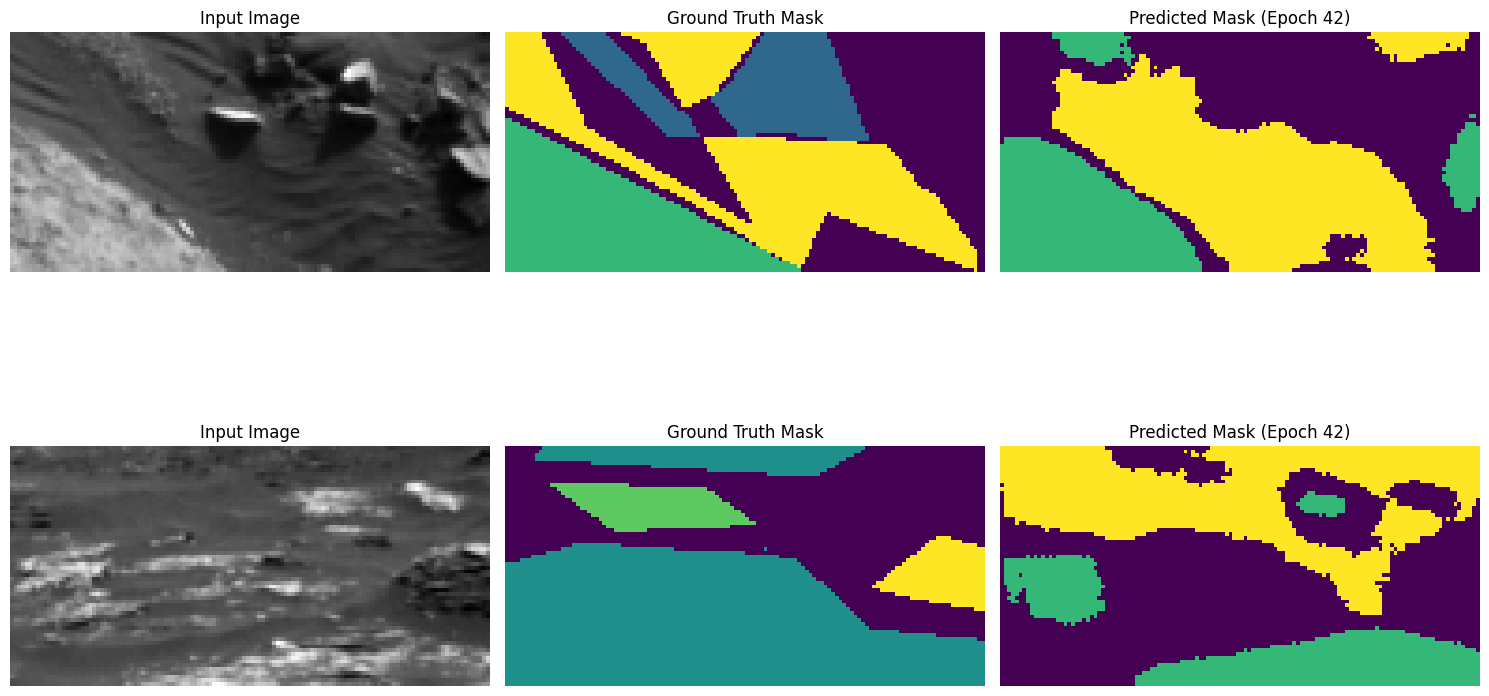

188/188 ━━━━━━━━━━━━━━━━━━━━ 37s 198ms/step - accuracy: 0.8527 - loss: 0.3776 - mean_io_u: 0.5548 - val_accuracy: 0.7667 - val_loss: 0.6759 - val_mean_io_u: 0.4622 - learning_rate: 2.5000e-05
Epoch 43/1000
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.8556 - loss: 0.3706 - mean_io_u: 0.5581
Epoch 43: val_loss did not improve from 0.63277

Epoch 43: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


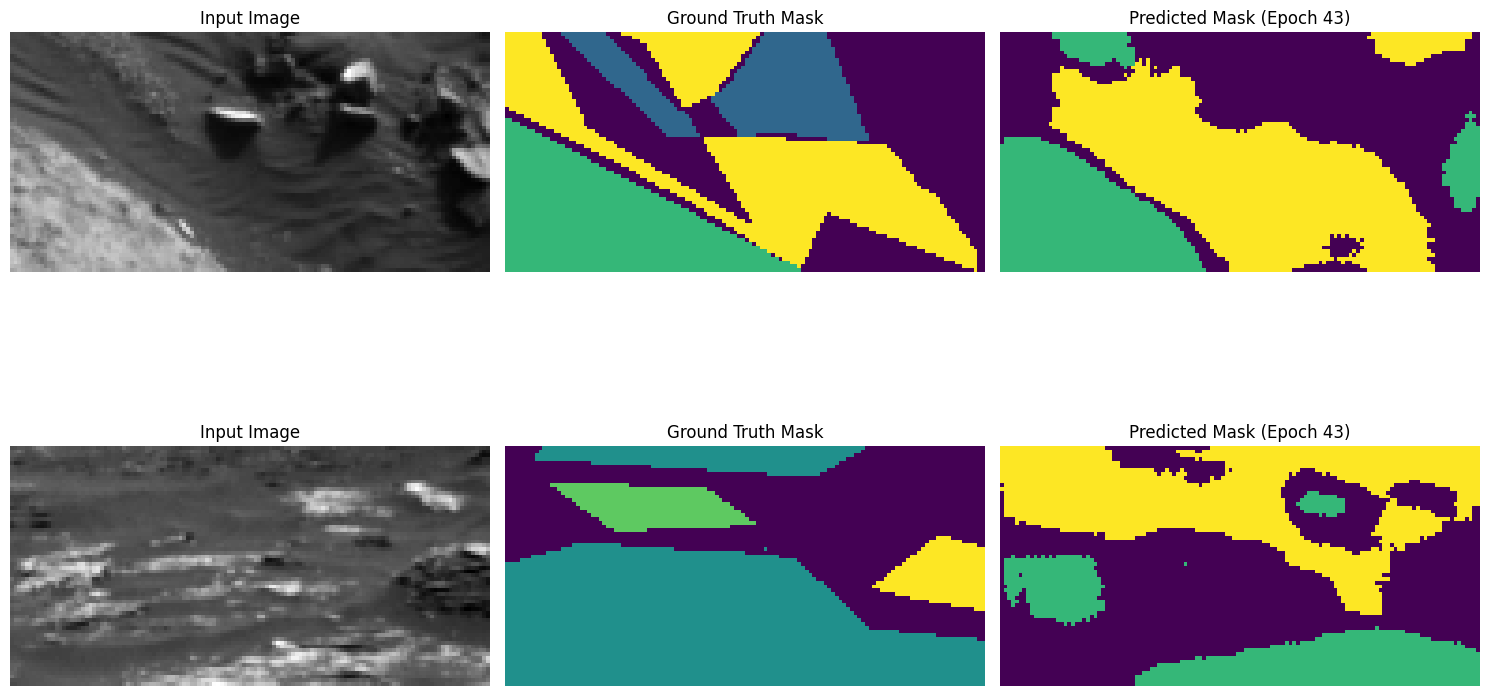

188/188 ━━━━━━━━━━━━━━━━━━━━ 38s 200ms/step - accuracy: 0.8556 - loss: 0.3706 - mean_io_u: 0.5581 - val_accuracy: 0.7662 - val_loss: 0.6817 - val_mean_io_u: 0.4622 - learning_rate: 2.5000e-05
Epoch 44/1000
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.8587 - loss: 0.3629 - mean_io_u: 0.5625
Epoch 44: val_loss did not improve from 0.63277
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


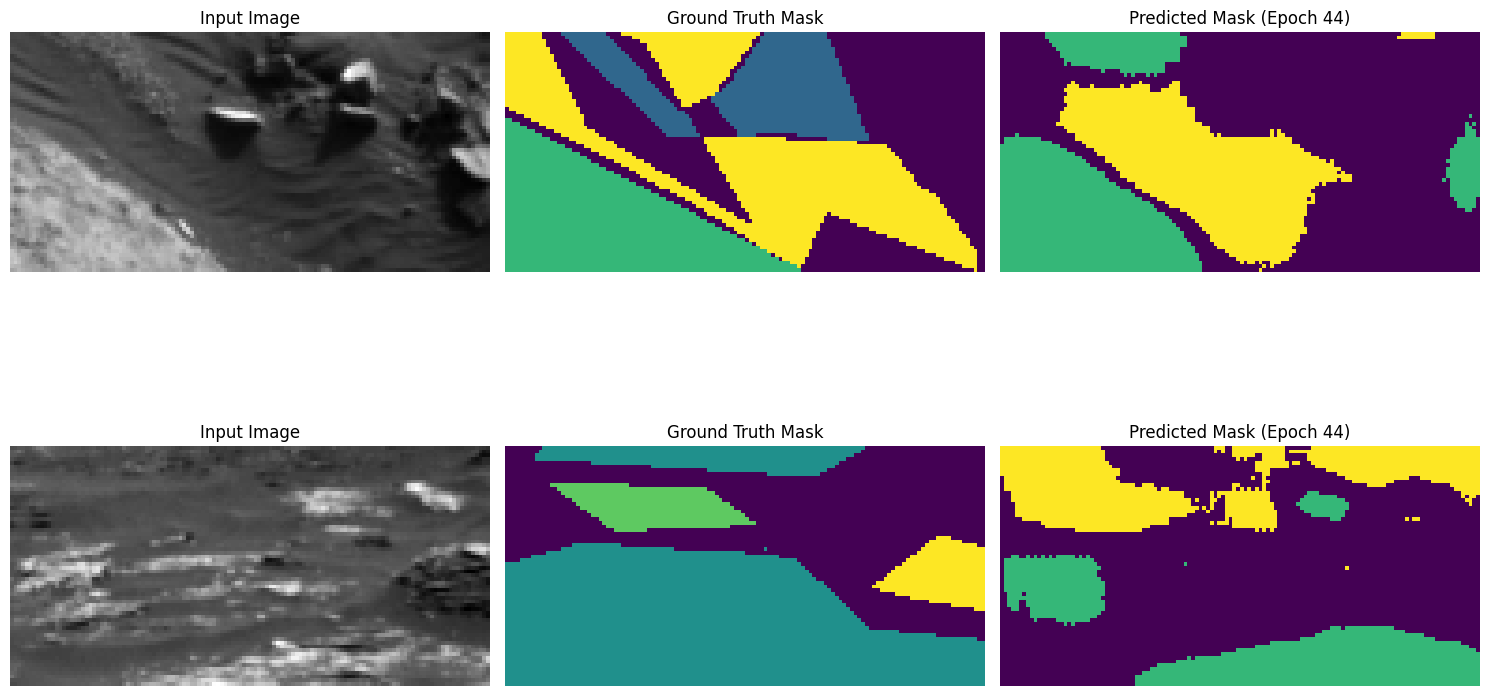

188/188 ━━━━━━━━━━━━━━━━━━━━ 37s 199ms/step - accuracy: 0.8587 - loss: 0.3630 - mean_io_u: 0.5625 - val_accuracy: 0.7666 - val_loss: 0.6879 - val_mean_io_u: 0.4564 - learning_rate: 1.2500e-05
Epoch 45/1000
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.8620 - loss: 0.3562 - mean_io_u: 0.5634
Epoch 45: val_loss did not improve from 0.63277
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


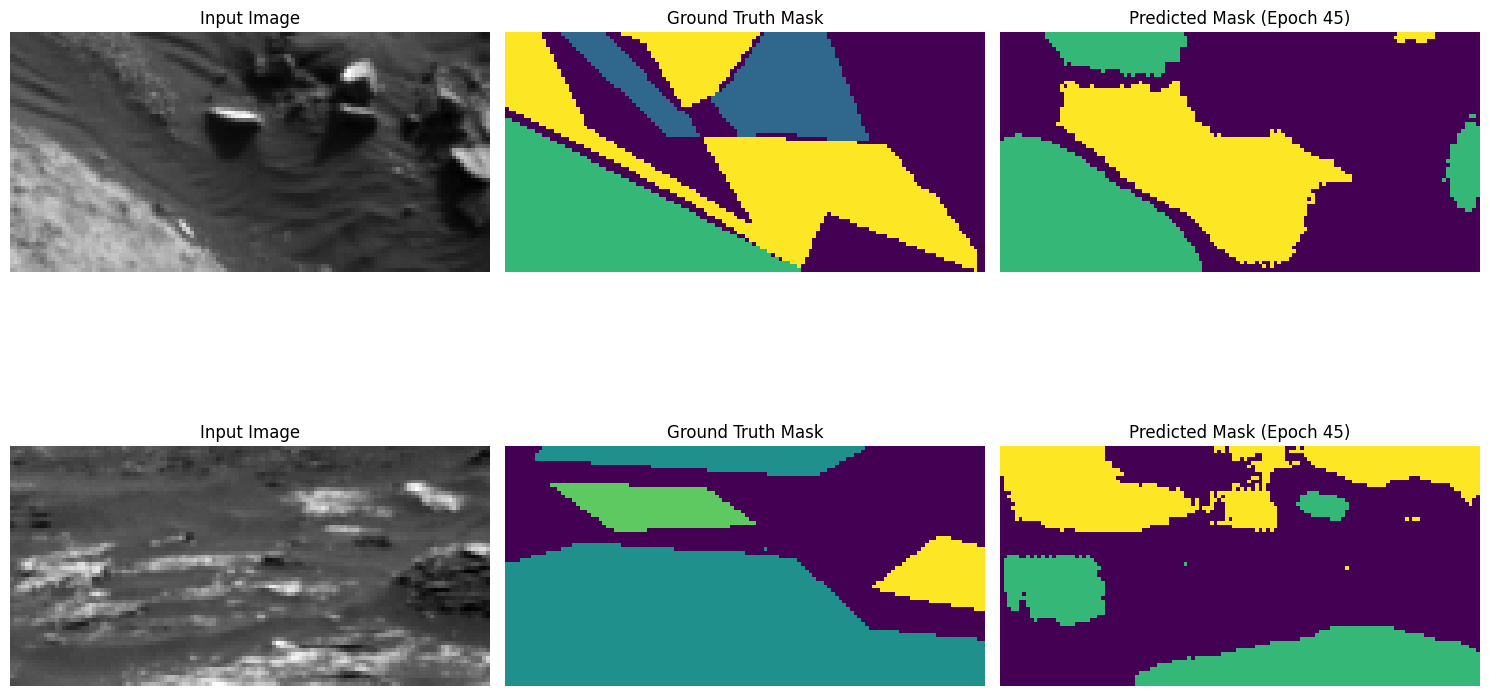

188/188 ━━━━━━━━━━━━━━━━━━━━ 37s 197ms/step - accuracy: 0.8620 - loss: 0.3562 - mean_io_u: 0.5633 - val_accuracy: 0.7663 - val_loss: 0.6925 - val_mean_io_u: 0.4563 - learning_rate: 1.2500e-05
Epoch 46/1000
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.8640 - loss: 0.3512 - mean_io_u: 0.5651
Epoch 46: val_loss did not improve from 0.63277
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


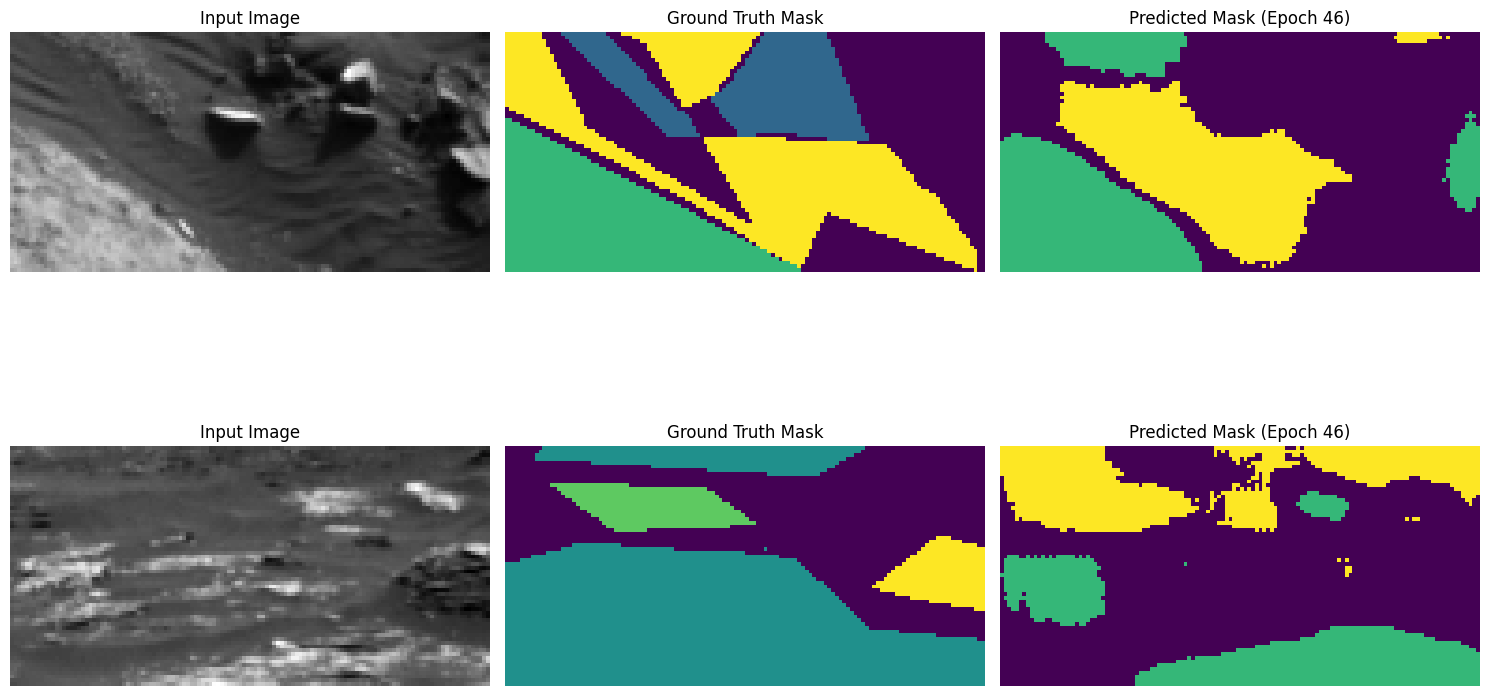

188/188 ━━━━━━━━━━━━━━━━━━━━ 37s 197ms/step - accuracy: 0.8640 - loss: 0.3512 - mean_io_u: 0.5651 - val_accuracy: 0.7659 - val_loss: 0.6978 - val_mean_io_u: 0.4561 - learning_rate: 1.2500e-05
Epoch 47/1000
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.8659 - loss: 0.3466 - mean_io_u: 0.5668
Epoch 47: val_loss did not improve from 0.63277
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


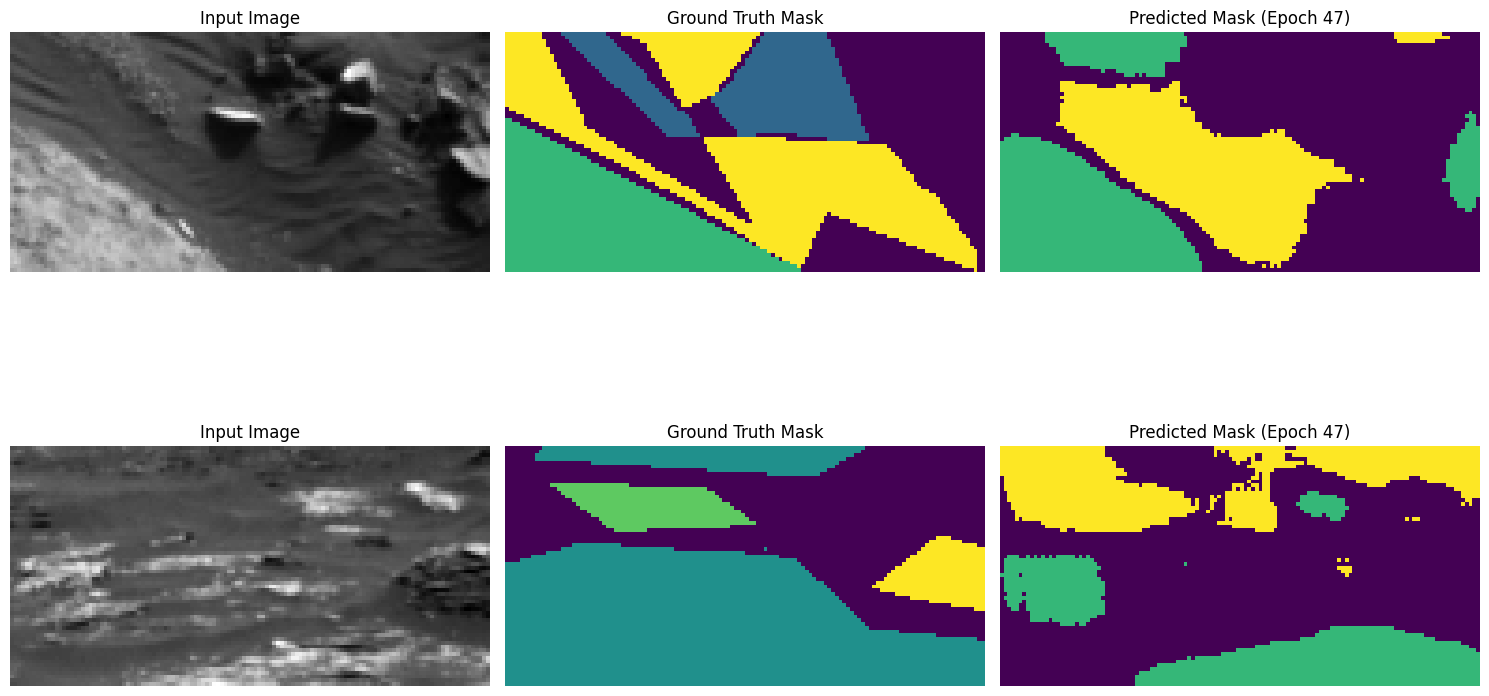

188/188 ━━━━━━━━━━━━━━━━━━━━ 37s 198ms/step - accuracy: 0.8658 - loss: 0.3467 - mean_io_u: 0.5668 - val_accuracy: 0.7656 - val_loss: 0.7031 - val_mean_io_u: 0.4560 - learning_rate: 1.2500e-05
Epoch 48/1000
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.8677 - loss: 0.3423 - mean_io_u: 0.5686
Epoch 48: val_loss did not improve from 0.63277

Epoch 48: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


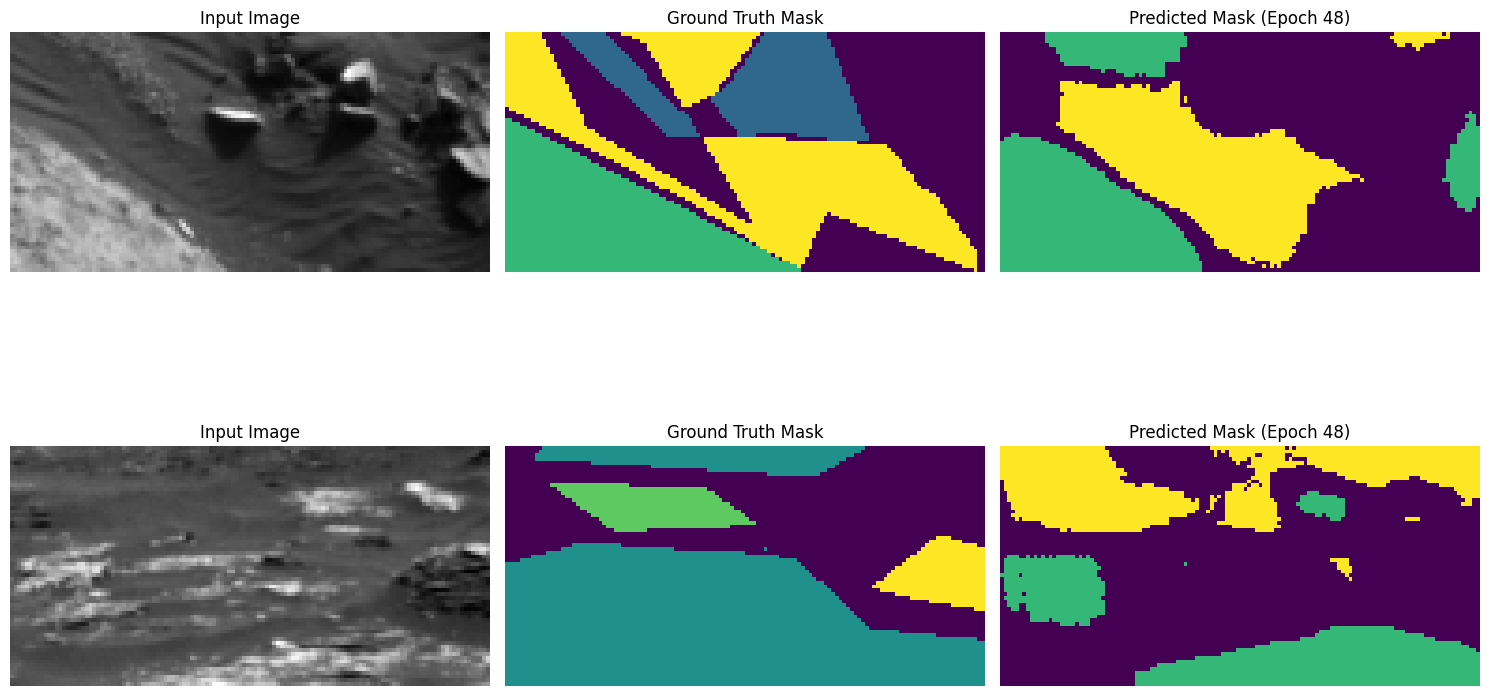

188/188 ━━━━━━━━━━━━━━━━━━━━ 37s 199ms/step - accuracy: 0.8676 - loss: 0.3423 - mean_io_u: 0.5686 - val_accuracy: 0.7653 - val_loss: 0.7083 - val_mean_io_u: 0.4559 - learning_rate: 1.2500e-05


In [27]:
import tensorflow as tf
from tensorflow.keras import layers as tfkl

# Residual Block
def residual_block(x, filters):
    shortcut = x
    x = tfkl.Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
    x = tfkl.Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
    shortcut = tfkl.Conv2D(filters, (1, 1), padding='same')(shortcut)
    return tfkl.add([x, shortcut])

# Dice Loss
def dice_loss(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred, axis=(1, 2, 3))
    denominator = tf.reduce_sum(y_true + y_pred, axis=(1, 2, 3))
    return tf.reduce_mean(1 - numerator / (denominator + tf.keras.backend.epsilon()))

# Hybrid Loss Function
def combined_loss(weights):
    ce_loss = weighted_categorical_crossentropy(weights)
    def loss(y_true, y_pred):
        return ce_loss(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss

# U-Net with Residual Connections
def unet_with_residual_blocks(input_shape, num_classes):
    inputs = tfkl.Input(input_shape)

    # Encoder
    c1 = residual_block(inputs, 64)
    p1 = tfkl.MaxPooling2D((2, 2))(c1)

    c2 = residual_block(p1, 128)
    p2 = tfkl.MaxPooling2D((2, 2))(c2)

    c3 = residual_block(p2, 256)
    p3 = tfkl.MaxPooling2D((2, 2))(c3)

    c4 = residual_block(p3, 512)

    # Decoder
    u1 = tfkl.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c4)
    u1 = tfkl.concatenate([u1, c3])
    d1 = residual_block(u1, 256)

    u2 = tfkl.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(d1)
    u2 = tfkl.concatenate([u2, c2])
    d2 = residual_block(u2, 128)

    u3 = tfkl.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(d2)
    u3 = tfkl.concatenate([u3, c1])
    d3 = residual_block(u3, 64)

    outputs = tfkl.Conv2D(num_classes, (1, 1), activation='softmax')(d3)

    return tf.keras.Model(inputs, outputs)

# Initialize the model
input_shape = X_train.shape[1:]
mean_iou = tfk.metrics.MeanIoU(num_classes=num_classes, ignore_class=0, sparse_y_pred=False)

model = unet_with_residual_blocks(input_shape, num_classes)
# Define the optimizer with a specific learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

# Compile the model
model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy", mean_iou])

model.summary()

# Training the model
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),  # Add validation data
    epochs=1000,
    callbacks=[early_stopping, model_checkpoint, reduce_lr, visualize_callback]
)

# Save the model
model.save("best_model_resunet.keras")


In [39]:
model=tf.keras.models.load_model(
    "/kaggle/working/best_model.keras"
)

In [40]:
model_filename = f"model_augmented_best.keras"
model.save(model_filename)

print(f"Model saved to {model_filename}")

Model saved to model_augmented_best.keras


## 📊 Prepare Your Submission

In our Kaggle competition, submissions are made as `csv` files. To create a proper `csv` file, you need to flatten your predictions and include an `id` column as the first column of your dataframe. To maintain consistency between your results and our solution, please avoid shuffling the test set. The code below demonstrates how to prepare the `csv` file from your model predictions.



In [41]:
import os
# If model_filename is not defined, load the most recent model from Google Drive
if "model_filename" not in globals() or model_filename is None:
    files = [f for f in os.listdir('.') if os.path.isfile(f) and f.startswith('model_') and f.endswith('.keras')]
    files.sort(key=lambda x: os.path.getmtime(x), reverse=True)
    if files:
        model_filename = files[0]
    else:
        raise FileNotFoundError("No model files found in the current directory.")

In [42]:
print(f"X_test shape before reshaping: {X_test.shape}")

X_test shape before reshaping: (10022, 64, 128, 1)


In [43]:
# Generate predictions
preds = model.predict(X_test)
preds = np.argmax(preds, axis=-1)  # Convert probabilities to class labels
print(f"Predictions shape: {preds.shape}")

314/314 ━━━━━━━━━━━━━━━━━━━━ 20s 61ms/step
Predictions shape: (10022, 64, 128)


In [44]:
model.save("model_resunet.keras")

Randomly selected indices for prediction (seed=42): [3543 5731 4801  416 5125 9915  293 5020 1765 4192 2288 1188  107 7583
  856 5090 9784 5192 6935  850]


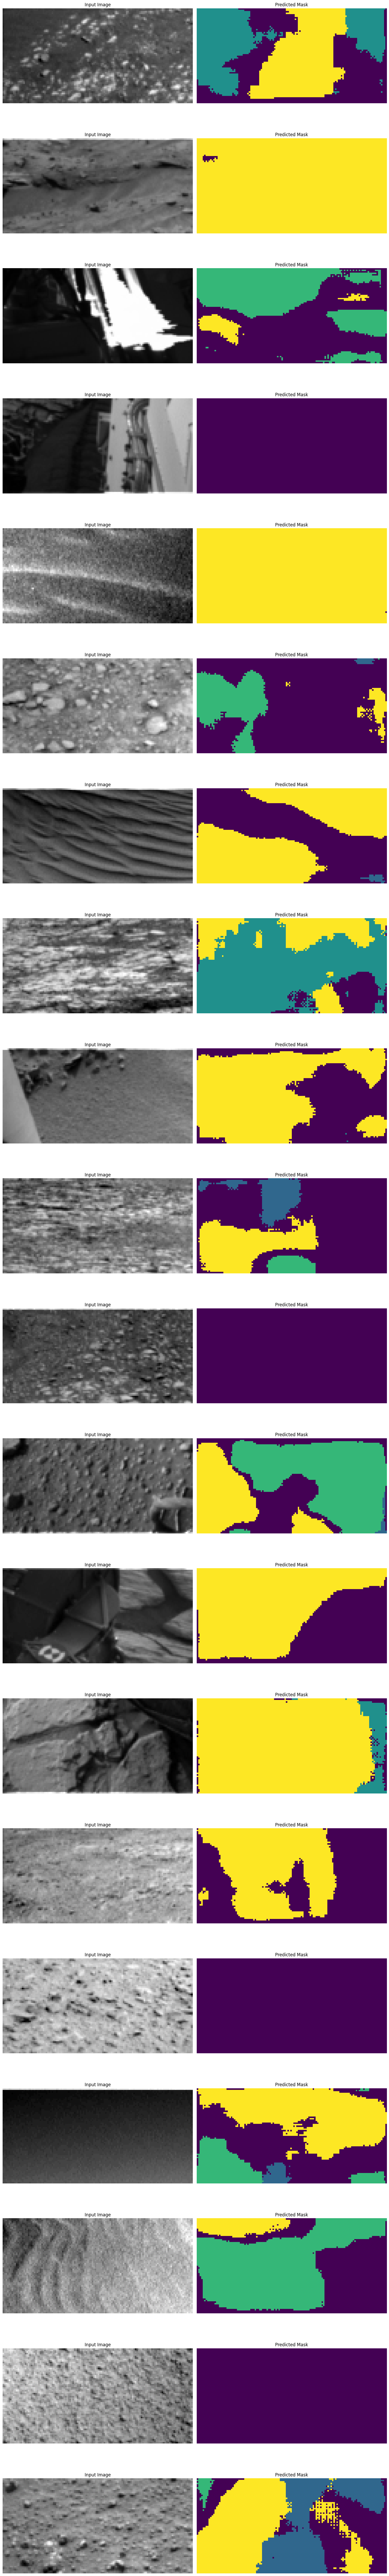

In [45]:
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)
# Randomly select 20 indices for prediction
random_indices = np.random.choice(X_test.shape[0], size=20, replace=False)
print(f"Randomly selected indices for prediction (seed=42): {random_indices}")

# Select 20 random samples and their corresponding masks
X_sample = X_test[random_indices]



predicted_masks = preds

# Visualize the predictions
num_images = len(X_sample)  # Number of images to visualize
fig, axes = plt.subplots(num_images, 2, figsize=(15, num_images * 5))

for i in range(num_images):
    # Original Image
    ax_img = axes[i, 0]
    ax_img.imshow(X_sample[i].squeeze(), cmap="gray")
    ax_img.set_title("Input Image")
    ax_img.axis("off")

    # Predicted Mask
    ax_pred = axes[i, 1]
    ax_pred.imshow(predicted_masks[i], cmap="viridis")
    ax_pred.set_title("Predicted Mask")
    ax_pred.axis("off")

plt.tight_layout()
plt.show()

In [46]:
def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [47]:
# Create and download the csv submission file
timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)



In [36]:
len(submission_df.columns)

8193

In [37]:
len(submission_df)

10022